# Обучение с учителем: качество модели

**Описание проекта:**
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Цель исследования:**

Целью исследования является нахождение лучшей модели, которая будет предсказывать вероятность снижения покупательской активности клиента в следующие три месяца, а также выделение сегмента покупателей, его анализ и предложение способов увеличения покупательской активности.

**Этапы исследования:**

Исследование будет включать следующие шаги:
1. **Загрузка и обзор данных**
    Загрузка данных из четырёх источников:
    - `market_file.csv` — данные о поведении покупателя на сайте,
    - `market_money.csv` — данные о выручке, которую получает магазин с покупателя,
    - `market_time.csv` — данные о времени, которое покупатель провёл на сайте в течении периода,
    - `money.csv` — данные о среднемесячной прибыли продавца за последние 3 месяца.
2. **Предобработка данных**
    - Приведение названий столбцов к единому виду в стиле `snake_case`
    - Поиск и устранение пропущенных значений
    - Поиск и обработка неявных и явных дубликатов.
3. **Исследовательский анализ данных**
    - Выведение основных статистик, выявление и обработка выбросов
    - Визуализация и описание основных характеристик признаков
4. **Объединение таблиц в один датафрейм**
    - Объединение таблиц `market_file.csv`, `market_money.csv`, `market_time.csv` в один датафрейм для использования при построении моделей
5. **Проведение корреляционного анализа**
    - Построение и анализ матрицы корреляций количественных признаков
6. **Создание и использование пайплайна для поиска лучшей модели**
    - Создание пайплайна для обработки количественных и категориальных признаков. Использование `GridSearchCV` с разными гиперпараметрами для каждой модели для поиска лучшей
7. **Анализ важности признаков модели с помощью SHAP**
    - Оценка важности признаков для лучшей модели и построение графиков важности
8. **Сегментация покупателей и советы по увеличению покупательской активности выбранной группы**
    - Выполнение сегментации покупателей с использованием результатов моделировани и данных о прибыльности покупателей из таблицы `money.csv`
    - Анализ выбранной группы покупателей и предложения по работе с сегментом для увеличения покупательской активности

#### Шаг 0.1 Установка и импорт нужных библиотек

In [265]:
# Установка нужных библиотек
%pip install -q missingno phik matplotlib==3.9.4 shap==0.47.2 scikit-learn==1.6.1 seaborn==0.13.2

Note: you may need to restart the kernel to use updated packages.


In [266]:
# Импорт стандартных библиотек
import re
import time

# Импорт основных библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Импорт специализированных сторонних библиотек
import missingno as msno
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

# Импорт библиотек машиннного обучения
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

**Значения констант**

In [267]:
# Сохраняем константу RANDOM_STATE
RANDOM_STATE = 42

#### Шаг 0.2 Функции для построения графиков.

Напишем функцию для построения гистограммы и ящика с усами распределения количественных переменных с разделением по целевому признаку.

In [268]:
def hist_and_boxplot(df, x_col, hue_col, title, x_label, bins=50):
    """
    Строит гистограмму и ящик с усами для переданного столбца с разделением по hue.
    """
    # Задаём группы для параметра hue
    hue_values = df[hue_col].unique()
    # Задаём цвета для групп
    palette = sns.color_palette("tab10", n_colors=len(hue_values))
    # Словарь: категория -> цвет
    colors = dict(zip(hue_values, palette))  
    
    # Гистограмма
    plt.figure(figsize=(15, 8))
    sns.histplot(data=df, x=x_col, hue=hue_col, bins=bins, multiple='dodge')

    # Создаём список для хранения элементов легенды линий средних и медиан
    lines_labels = []
    # Создаём список для хранения элементов легенды каждой группы
    labels = []

    # Добавляем линии среднего и медианы для каждой группы
    for hue_value in hue_values:
        # Выбираем группу
        group_df = df[df[hue_col] == hue_value][x_col]
        # Вычисляем значение среднего
        mean_val = group_df.mean()
        # Добавляем элемент легенды среднего значения текущей группы в список
        lines_labels.append(f'Среднее({hue_value})')
        # Вычисляем значение медианы
        median_val = group_df.median()
        # Добавляем элемент легенды значения медианы текущей группы в список
        lines_labels.append(f'Медиана({hue_value})')
        # Линия среднего
        plt.axvline(x=mean_val, color=colors.get(hue_value, 'black'), linestyle='-', alpha=0.75,
                    label=f'Среднее ({hue_value})')
        # Линия медианы
        plt.axvline(x=median_val, color=colors.get(hue_value, 'black'), linestyle='--', alpha=0.75,
                    label=f'Медиана ({hue_value})')
        # Добавляем элемент легенды текущей группы в список
        labels.append(hue_value)
    
    # Сортируем список с элементами легенд групп в обратном порядке из-за особенности sns.histplot
    labels.reverse()
    # Добавляем список с элементами легенд групп в конец списка с элементами легенд линий средних и медиан
    lines_labels.extend(labels)

    plt.xlabel(x_label)
    plt.ylabel('Частота')
    plt.title(f'{title}. Распределение')
    # Передаём список с элементами легенд
    plt.legend(title=hue_col, labels=lines_labels)
    plt.show()

    # Ящик с усами
    plt.figure(figsize=(11, 5))
    sns.boxplot(x=x_col, y=hue_col, data=df, hue=hue_col, legend=False)
    plt.xlabel(x_label)
    plt.ylabel(hue_col.capitalize().replace('_', ' '))
    plt.title(f'{title}. Ящик с усами')
    plt.show()

Напишем функцию для построения круговых диаграмм для категориальных признаков.

In [269]:
def pie_plot(column, title):
    """
    Строит круговую диаграмму для переданного столбца и выводит количество данных
    """
    # Создаём датафрейм с количеством
    category_counts = column.value_counts().sort_values(ascending=False)
    category_df = pd.DataFrame({
        title: category_counts.index,
        'Количество': category_counts.values
    })

    # Задаём размер графика
    plt.figure(figsize=(8, 8))
    # Строим круговую диаграмму
    plt.pie(
        category_counts.values,
        labels=category_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        labeldistance=1.1,
        pctdistance=0.8,
    )
    plt.title(title)
    plt.axis('equal')
    plt.show()

    display(category_df)

Напишем функцию для построения графиков countplot с разделением по целевому признаку `Покупательская активность`.

In [270]:
def countplot_with_hue(df, x_col, hue_col, title, x_label, rot=0):
    """
    Строит график countplot с разделением по hue.
    """
    plt.figure(figsize=(12, 8))
    sns.countplot(data=df, x=x_col, hue=hue_col, palette='tab10')
    plt.xlabel(x_label)
    plt.ylabel('Количество клиентов')
    plt.title(title)
    plt.xticks(rotation=rot)
    plt.legend(title=hue_col.capitalize().replace('_', ' '))
    plt.tight_layout()
    plt.show()

Напишем функцию для построения графиков barplot с разделением по целевому признаку `Покупательская активность`.

In [271]:
def barplot_with_hue(df, x_col, y_col, hue_col, title, x_label, y_label, rotation=0, order=None):
    """
    Строит график barplot с разделением по hue.
    """
    # Столбчатая диаграмма
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='tab10', order=order, estimator=sum)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

Напишем функцию для построения графиков scatter с разделением по целевому признаку `Покупательская активность`.

In [272]:
def create_scatter(df, x_col, y_col):
    """
    Строит график scatterplot с hue='покупательская_активность'
    """
    plt.figure(figsize=(15, 8))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='покупательская_активность')
    x_col = x_col.capitalize().replace('_', ' ')
    y_col = y_col.capitalize().replace('_', ' ')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{x_col}/{y_col}. Scatter')
    plt.show()

## Шаг 1. Загрузка данных

#### Шаг 1.1 Загрузка данных в датафреймы

Напишем функцию для загрузки данных из csv-файлов. Также напишем функцию для вывода первичной информации.

In [273]:
def load_data(names):
    """
    Создаёт датафреймы из переданных названий csv файлов
    """
    def load_table(filename):
        """
        Возвращает датафрейм из переданного csv файла
        """
        # Задаём разделитель
        sep, decimal = (';', ',') if filename == 'money' else (',', '.')

        try:
            sep =','
            return pd.read_csv(f'{filename}.csv', sep=sep, decimal=decimal)
        except:
            return pd.read_csv(f'https://code.s3.yandex.net/datasets/{filename}.csv', sep=sep, decimal=decimal)
            

    # Создаём список для хранения созданных датафреймов
    dfs_list = []

    # Для каждого имени из списка имён 
    for name in names:
        # Добавляем в созданный список созданный датафрейм
        dfs_list.append(load_table(name))
    
    return dfs_list


def show_info(df):
    """
    Выводит первичную информацию датафреймов
    """
    display(df.head(n=10))
    df.info()

In [274]:
# Создаём список с именами файлов
dfs_names = ['market_file', 'market_money', 'market_time', 'money']

# Создаём четыре датафрейма, используя функцию
market_file_df, market_money_df, market_time_df, money_df = load_data(dfs_names)

**Вывод:**

Данные из таблиц были загружены в датафреймы.

#### Шаг 1.2 Вывод первичных данных

**Датафрейм с данными о поведении покупателя на сайте**

In [275]:
# Выводим информацию датафрейма с данными о поведении покупателя на сайте
show_info(market_file_df)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   
5  215353                 Снизилась   стандартт                 да   
6  215354                 Снизилась   стандартт                 да   
7  215355                 Снизилась   стандартт                нет   
8  215356                 Снизилась   стандартт                 да   
9  215357                 Снизилась   стандартт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   
6                 5.1                     3           431               0.23   
7                 4.7                     4           284               0.17   
8                 4.2                     4           192               0.14   
9                 3.9                     5           154               0.00   

             Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                Товары для детей                                    6   
1                Товары для детей                                    4   
2               Домашний текстиль                                    5   
3                Товары для детей                                    5   
4                Товары для детей                                    3   
5               Домашний текстиль                                    4   
6           Косметика и аксесуары                                    2   
7                Товары для детей                                    5   
8           Косметика и аксесуары                                    2   
9  Техника для красоты и здоровья                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4  
6                                   3               7                 2  
7                                   1               6                 4  
8                                   2               1                 3  
9                                   3               9                 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Сразу можно заметить ошибку в столбце `Тип сервиса` — значение *"стандартт"* написано с двумя буквами "т". Также видно, что не все названия столбцов имеют стиль `snake_case`.

**Датафрейм с данными о выручке магазина**

In [276]:
# Выводим информацию датафрейма с данными о выручке магазина
show_info(market_money_df)

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4
8  215350     предыдущий_месяц   5457.5
9  215351        текущий_месяц   6610.4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Датафрейм с данными о времени, проведённом на сайте**

In [277]:
# Выводим информацию датафрейма с данными о времени, проведённом на сайте
show_info(market_time_df)

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
5  215350  предыдцщий_месяц      8
6  215351     текущий_месяц     13
7  215351  предыдцщий_месяц     11
8  215352     текущий_месяц     11
9  215352  предыдцщий_месяц      8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Можно заметить ошибку в столбце `Период` — "предыдцщий_месяц".

**Датафрейм с данными о среднемесячной прибыли продавца за последние 3 месяца**

In [278]:
# Выводим информацию датафрейма с данными о среднемесячной прибыли продавца за последние 3 месяца
show_info(money_df)

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
5  215353     3.95
6  215354     3.62
7  215355     5.26
8  215356     4.93
9  215357     4.66

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


#### 1.3 Вывод:

Из таблиц были созданы датафреймы, данные соответствуют описанию. Во всех датафреймах тип данных столбцов является правильным.

## Шаг 2. Предобработка данных

#### Шаг 2.1 Приведение названий столбцов к единому виду

Приведём все названия столбцов к стилю `snake_case`. Для этого:

1. На всякий случай уберём пробелы по краям с помощью `strip()`
2. Приведём все названия к нижнему регистру
3. Заменим пробелы на нижние подчеркивания

In [279]:
def column_names(dfs_list):
    """
    Возвращает названия столбцов переданных датафреймов в виде датафрейма
    """
    # Создаём список для хранения названий столбцов
    names = []
    for df in dfs_list:
        # Добавляем названия столбцов в список
        names.append(pd.DataFrame(df.columns))

    # Объединяем список с названиями столбцов в датафрейм
    names_df = pd.concat(names, ignore_index=True)

    return names_df

# Создаём список датафреймов
dfs_list = [market_file_df, market_money_df, market_time_df, money_df]

# Сохраняем старые названия столбцов для сравнения
old_names = column_names(dfs_list)


def clean_column_names(dfs_list):
    """
    Приводит названия столбцов к стилю snake_case
    """
    for df in dfs_list:
        df.columns = (
            df.columns
            .str.strip()                                    # убираем пробелы по краям
            .str.lower()                                    # приводим к нижнему регистру
            .str.replace(r'\s+', '_', regex=True)           # заменяем все пробелы на нижнее подчеркивание
        )

    return dfs_list


# Применяем созданную функцию
dfs_list = clean_column_names(dfs_list)

# Сохраняем в переменную новые названия
new_names = column_names(dfs_list)

# Сохраняем в переменную новые названия
new_names = column_names(dfs_list)

# Объединяем в датафрейм старые и новые названия для сравнения
column_names_df = pd.concat([
    old_names,
    new_names
], axis=1)

# Заменяем названия столбцов
column_names_df.columns = ['старые', 'новые']

# Сбрасываем индексы
column_names_df.reset_index(drop=True, inplace=True)

# Выводим на экран
column_names_df

старые                                новые
0                                    id                                   id
1             Покупательская активность            покупательская_активность
2                           Тип сервиса                          тип_сервиса
3                    Разрешить сообщать                   разрешить_сообщать
4                    Маркет_актив_6_мес                   маркет_актив_6_мес
5                  Маркет_актив_тек_мес                 маркет_актив_тек_мес
6                          Длительность                         длительность
7                     Акционные_покупки                    акционные_покупки
8                  Популярная_категория                 популярная_категория
9   Средний_просмотр_категорий_за_визит  средний_просмотр_категорий_за_визит
10   Неоплаченные_продукты_штук_квартал   неоплаченные_продукты_штук_квартал
11                       Ошибка_сервиса                       ошибка_сервиса
12                     Страниц_за_визит                     страниц_за_визит
13                                   id                                   id
14                               Период                               период
15                              Выручка                              выручка
16                                   id                                   id
17                               Период                               период
18                                минут                                минут
19                                   id                                   id
20                              Прибыль                              прибыль

**Вывод:**

Названия были приведены к стилю `snake_case`.

#### Шаг 2.2 Проверка на наличие пропусков.

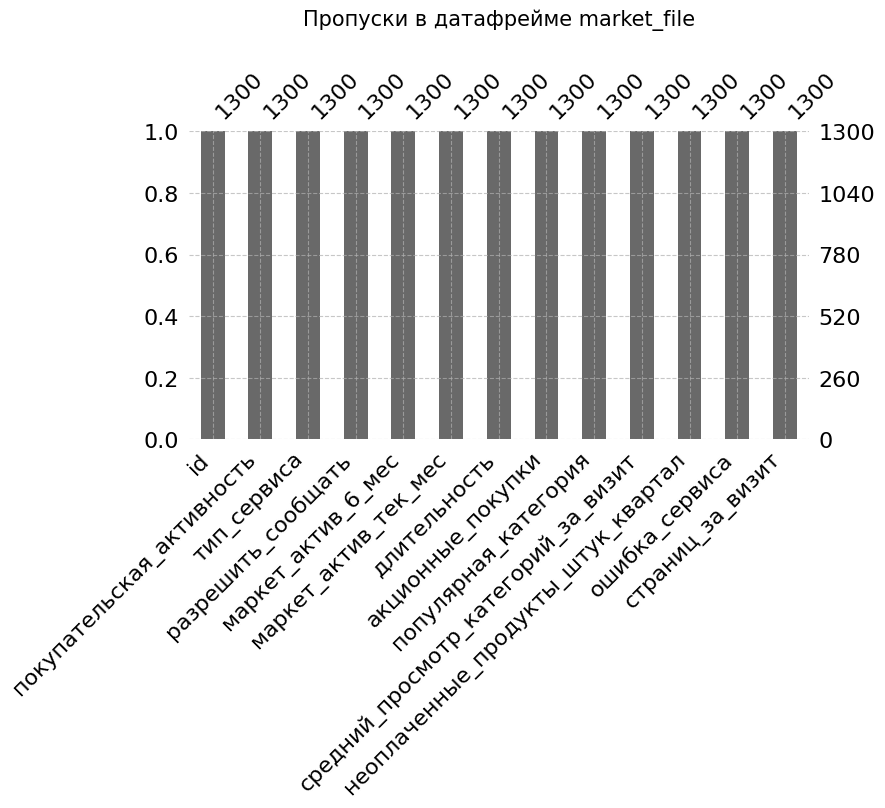

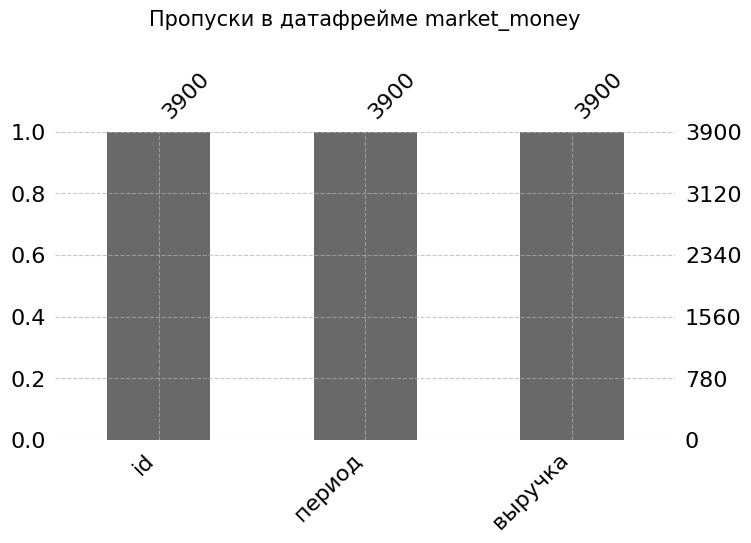

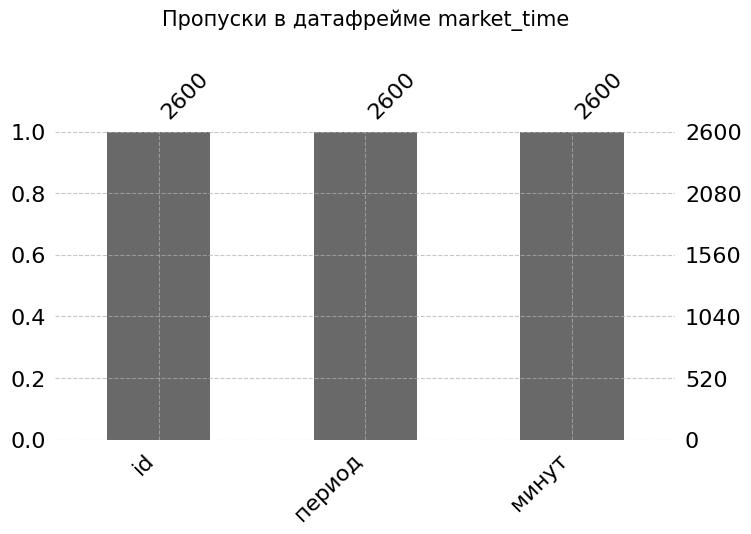

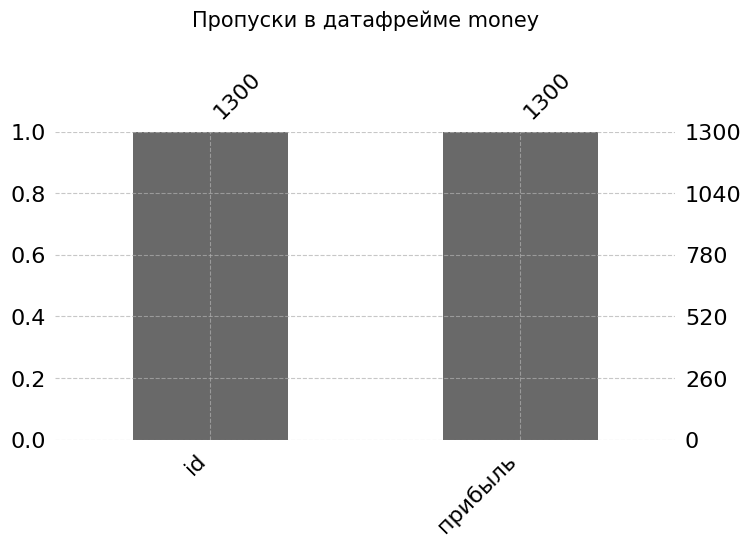

In [280]:
def nan_bar_chart(df, title):
    """
    Строит bar chart для отображения пропущенных значений.
    """
    # Задаём параметры графика
    ax = msno.bar(df, figsize=(8, 4))
    # Задаём параметры сетки
    ax.grid(True, linestyle='--', alpha=0.7)
    # Добавляем заголовок
    plt.title(title, fontsize=15, pad=30)
    # Выводим график на экран
    plt.show()


# Используем созданную функцию для каждого датафрейма
for df, df_name in zip(dfs_list, dfs_names):
    nan_bar_chart(df, f'Пропуски в датафрейме {df_name}')

**Вывод:**

Ни в одном из датафреймов нет пропусков.

#### Шаг 2.3 Проверка неявных дубликатов

Напишем функцию для вывода на экран уникальных значений столбцов.

In [281]:
def unique_values(df):
    """
    Выводит на экран уникальные значения категориальных столбцов переданного датафрейма
    """
    # Выбираем категориальные столбцы
    cat_columns = df.select_dtypes(exclude='number').columns.tolist()
    if len(cat_columns) == 0:
        print('В датафрейме нет категориальных столбцов.')
    else:
        for column in cat_columns:
            print('Название столбца:', column)
            print(df[column].value_counts(), end='\n\n')


# Применяем созданную функцию к датафрейму с данными о поведении покупателей на сайте market_file_df
unique_values(market_file_df)

Название столбца: покупательская_активность
Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

Название столбца: тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

Название столбца: разрешить_сообщать
да     962
нет    338
Name: разрешить_сообщать, dtype: int64

Название столбца: популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64



Исправим значение *"стандартт"* в столбце `тип_сервиса`. Также исправим опечатку в категории *"Косметика и аксесуары"* — добавим недостающую букву *c*.

In [282]:
# Заменяем неправильное значение
market_file_df.loc[market_file_df['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
# Исправляем опечатку в слове аксессуары
market_file_df.loc[market_file_df['популярная_категория'] == 'Косметика и аксесуары', 'популярная_категория'] = 'Косметика и аксессуары'
# Выводим на экран для проверки
print('Уникальные значения столбца тип сервиса:', market_file_df['тип_сервиса'].unique())
# Выводим на экран для проверки
print('Уникальные значения столбца тип сервиса:', market_file_df['популярная_категория'].unique())

Уникальные значения столбца тип сервиса: ['премиум' 'стандарт']
Уникальные значения столбца тип сервиса: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Проверим остальные датафреймы на неявные дубликаты.

In [283]:
# Применяем созданную функцию к датафрейму с данными о выручке market_money_df
unique_values(market_money_df)

Название столбца: период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: период, dtype: int64



Исправим опечатку в слове *"препредыдущий"*.

In [284]:
# Заменяем неправильное значение
market_money_df.loc[market_money_df['период'] == 'препредыдущий_месяц', 'период'] = 'предпредыдущий_месяц'
# Выводим на экран для проверки
print(market_money_df['период'].unique())

['предпредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [285]:
# Применяем созданную функцию к датафрейму с данными о времени, проведённом покупателем на сайте market_time_df
unique_values(market_time_df)

Название столбца: период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64



Исправим опечатку *"предыдцщий_месяц"* в столбце `период`.

In [286]:
# Заменяем неправильное значение
market_time_df.loc[market_time_df['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
# Выводим на экран для проверки
print(market_time_df['период'].unique())

['текущий_месяц' 'предыдущий_месяц']


In [287]:
# Применяем созданную функцию к датафрейму с данными о среднемесячной прибыли продавца money_df
unique_values(money_df)

В датафрейме нет категориальных столбцов.


**Вывод:**

Неявные дубликаты в датафреймах были найдены и обработаны.

#### Шаг 2.4 Проверка явных дубликатов

Напишем функцию для проверки явных дубликатов, а также применим её к каждому датафрейму.

In [288]:
def check_duplicates(df, name):
    """
    Выводит на экран количество явных дубликатов и строки с ними, если они есть,
    или информацию о том, что явных дубликатов нет
    """
    # Количество явных дубликатов
    dups = df.duplicated().sum()
    # Если количество дубликатов больше 0
    if dups > 0:
        # Выводим количество дубликатов в датафрейме users_df
        print(f'Количество явных дубликатов в датафрейме {name}_df = {dups}')
        # Выводим на экран дубликаты и их количество
        display(df.value_counts().loc[lambda x: x > 1])
    else:
        print(f'В датафрейме {name}_df нет явных дубликатов.')


# Применяем созданную функцию ко всем датафреймам
for df, df_name in zip(dfs_list, dfs_names):
    check_duplicates(df, df_name)

В датафрейме market_file_df нет явных дубликатов.
В датафрейме market_money_df нет явных дубликатов.
В датафрейме market_time_df нет явных дубликатов.
В датафрейме money_df нет явных дубликатов.


**Вывод:**

Ни в одном из датафреймов нет явных дубликатов.

#### Шаг 2.5 Вывод

Была выполнена предобработка данных: Названия столбцов приведены к единому виду, выполнена проверка на наличие пропусков, выявлены и обработаны неявные дубликаты, а также выполнена проверка на наличие явных дубликатов.

## Шаг 3. Исследовательский анализ данных

#### Шаг 3.1 Статистический анализ признаков

Выведем на экран основные статистики количественных признаков.

**Датафрейм с данными о поведении покупателя на сайте market_file_df**

In [289]:
market_file_df.describe().drop('id', axis='columns')

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count         1300.000000           1300.000000   1300.000000   
mean             4.253769              4.011538    601.898462   
std              1.014814              0.696868    249.856289   
min              0.900000              3.000000    110.000000   
25%              3.700000              4.000000    405.500000   
50%              4.200000              4.000000    606.000000   
75%              4.900000              4.000000    806.000000   
max              6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

Можно отметить отсутствие аномальных значений.

**Датафрейм с данными о выручке, которую получает магазин с покупателя, market_money_df**

In [290]:
market_money_df.describe().drop('id', axis='columns')

выручка
count    3900.000000
mean     5025.696051
std      1777.704104
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max    106862.200000

Максимальное значение (106862.2) сильно отличается от среднего (5025.7) при стандартном отклонении (1777.7). Посмотрим, сколько значений больше 7500 есть в датафрейме.

In [291]:
market_money_df[market_money_df['выручка'] > 7500]

id         период   выручка
98    215380  текущий_месяц  106862.2
262   215435  текущий_месяц    7605.3
435   215493  текущий_месяц    7799.4
1481  215841  текущий_месяц    7557.0
2388  216144  текущий_месяц    7547.8

Видим, что есть 4 значения в районе 7500-7800, что не настолько сильно отличается от среднего в 5025, а вот значение в 106862.2 всего одно и является аномалией. Скорее всего, его можно объяснить какой-то дорогостоящей покупкой, однако при обучении моделей это значение будет только их путать, поэтому удалим его.

In [292]:
# Оставляем только строки со значением выручки меньше 10000
market_money_df = market_money_df[market_money_df['выручка'] < 10000]

**Датафрейм с данными о времени, которое покупатель провёл на сайте в течение периода, market_time_df**

In [293]:
market_time_df.describe().drop('id', axis='columns')

минут
count  2600.000000
mean     13.336154
std       4.080198
min       4.000000
25%      10.000000
50%      13.000000
75%      16.000000
max      23.000000

Можно отметить отсутствие аномальных значений.

**Датафрейм с данными о среднемесячной прибыли продавца за последние 3 месяца money_df**

In [294]:
money_df.describe().drop('id', axis='columns')

прибыль
count  1300.000000
mean      3.996631
std       1.013722
min       0.860000
25%       3.300000
50%       4.045000
75%       4.670000
max       7.430000

Можно отметить отсутствие аномальных значений.

**Вывод:**

Были рассмотрены основные статистики всех датрафеймов, удалено аномальное значение выручки 106862.2.

#### Шаг 3.2 Отбор клиентов с покупательской активностью не менее трёх месяцев

Проверим, сколько покупателей не делали покупки за последние 3 месяца. Для этого посмотрим общую выручку в датафрейме `market_money_df`.

In [295]:
# Делаем копию датафрейма
months = market_money_df.copy()
# Добавляем столбец с активностью, если выручка за месяц > 0
months['is_active'] = months['выручка'] > 0
# Создаём сводную таблицу, суммируя активные месяцы
active_clients = months.groupby('id')['is_active'].sum().reset_index(name='active_months')

# Добавляем столбец с флагом активности: если пользователь был активен минимум 3 месяца
active_clients['active_flag'] = (active_clients['active_months'] >= 3).astype(int)

# Сверяем количество пользователей в датафрейме с количеством пользователей, подходящих по условию
print('Количество пользователей по id в датафрейме market_file_df:', market_money_df['id'].nunique())
print('Количество пользователей, которые были активны как минимум 3 последних месяца:', len(active_clients[active_clients['active_flag'] == 1]))

Количество пользователей по id в датафрейме market_file_df: 1300
Количество пользователей, которые были активны как минимум 3 последних месяца: 1296


Из 1300 клиентов только трое не соответствуют критерию покупательной активности не менее трёх месяцев. Исключим их из анализа.

In [296]:
# Сохраняем id неподходящих пользователей в список
non_active_ids = list(active_clients[active_clients['active_flag'] == 0]['id'])

# Удаляем строки с id неподходящих клиентов во всех датафреймах
market_file_df, market_money_df, market_time_df, money_df = [df.query('id not in @non_active_ids') for df in dfs_list]
# Обновляем список датафреймов
dfs_list = [market_file_df, market_money_df, market_time_df, money_df]

# Проверяем удаление
print('Количество пользователей по id в датафрейме market_file_df:', market_money_df['id'].nunique())
print('Количество пользователей, которые были активны как минимум 3 последних месяца:', len(active_clients[active_clients['active_flag'] == 1]))

Количество пользователей по id в датафрейме market_file_df: 1296
Количество пользователей, которые были активны как минимум 3 последних месяца: 1296


**Вывод:**

Были отобраны клиенты с покупательской активностью не менее трёх месяцев.

#### Шаг 3.3 Построение графиков для каждого признака

Для построения графиков используем написанные функции из **Шаг 0.2 Основные функции**.

#### Шаг 3.3.1 Датафрейм с данными о поведении покупателя на сайте market_file_df

#### Шаг 3.3.1.1 Количественные признаки

**Маркетинг за 6 месяцев**

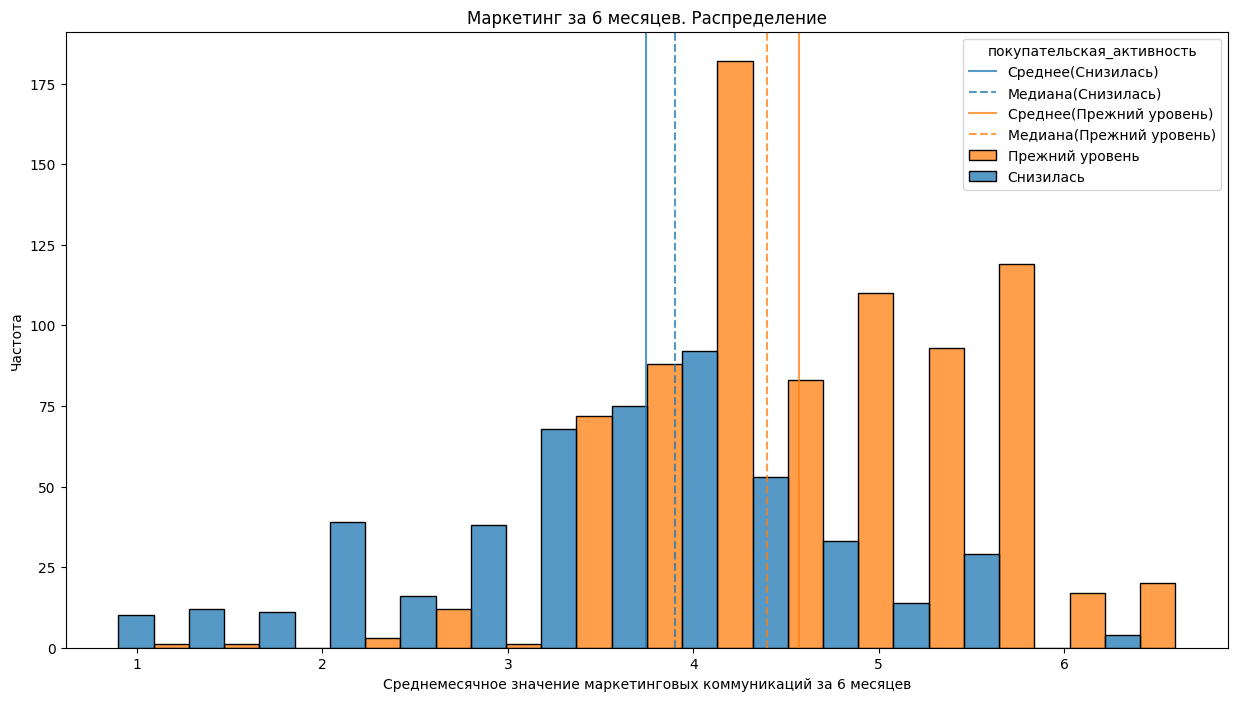

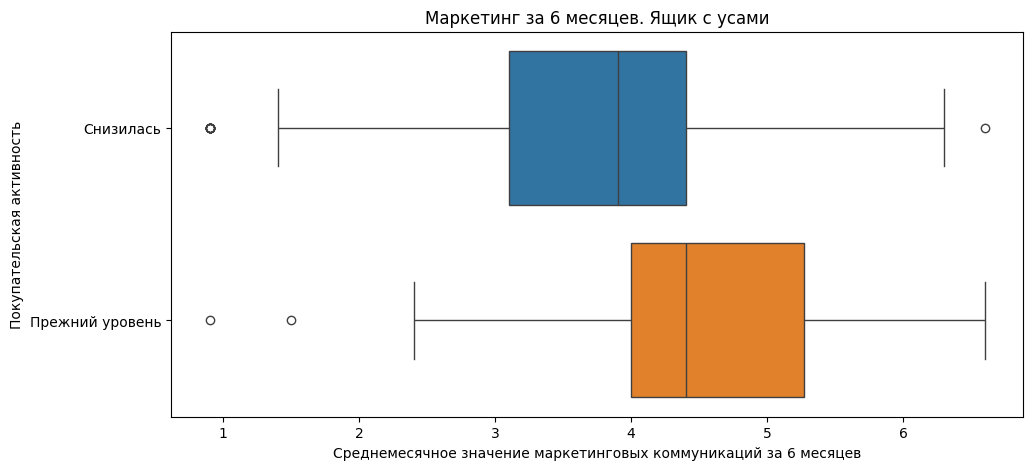

In [297]:
# Используем функцию для построения гистограммы и ящика с усами
hist_and_boxplot(
    df=market_file_df,
    x_col='маркет_актив_6_мес', 
    hue_col='покупательская_активность', 
    title='Маркетинг за 6 месяцев',
    x_label='Среднемесячное значение маркетинговых коммуникаций за 6 месяцев',
    bins=15
)

Распределения в обеих группах отличаются от нормального: отсутствуют симметрия и колоколообразная форма. 

- У пользователей с прежним уровнем покупательской активности распределение имеет смещение вправо. Среднее примерно равно 4.5, медиана 4.4.
- У пользователей с пониженным уровнем покупательской активности распределение имеет смещение влево. Среднее примерно равно 3.8, медиана 3.9.

Это указывает на наличие связи между числом маркетинговых коммуникаций и уровнем покупательской активности.

Ящик с усами показывает, что у пользователей с пониженной покупательной активностью есть несколько выбросов с обеих сторон от усов, у пользователей с прежним уровнем покупательной активности есть выбросы только слева от левого уса.

**Маркетинг текущего месяца**

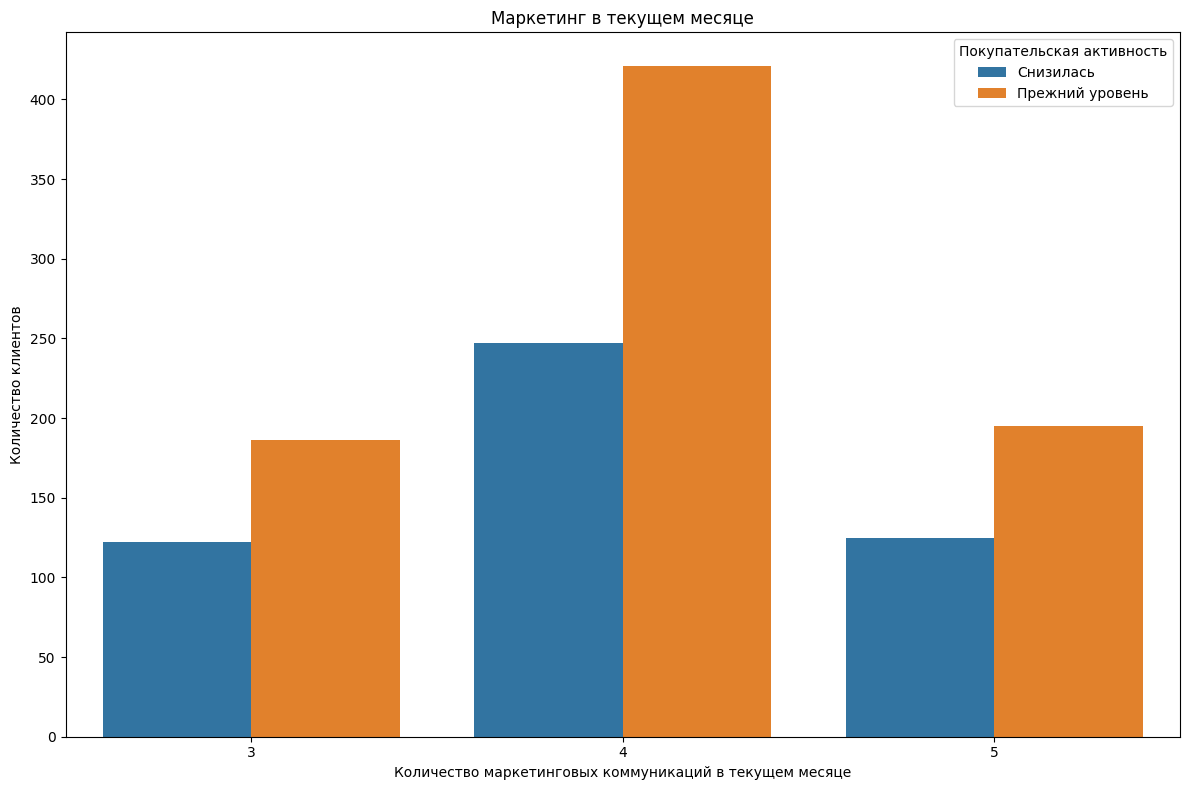

In [298]:
# Используем созданную функцию для построения столбчатой диаграммы с учётом пользовательской активности
countplot_with_hue(
    df=market_file_df,
    x_col='маркет_актив_тек_мес',
    hue_col='покупательская_активность',
    title='Маркетинг в текущем месяце',
    x_label='Количество маркетинговых коммуникаций в текущем месяце'
)

График показывает, что наибольшее значение количества маркетинговых коммуникаций в текущем месяце в обеих группах - 4. Значения количества коммуникаций 3 и 5 практически одинаковые в обеих группах.

**Акционные покупки**

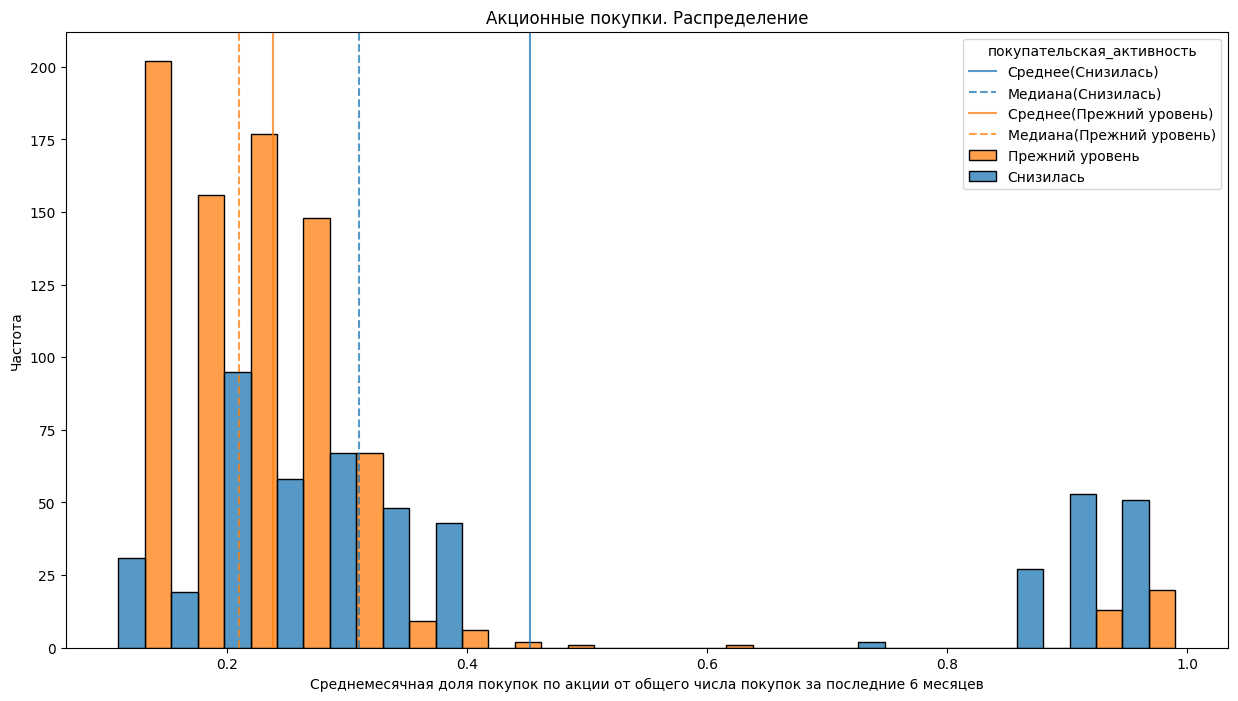

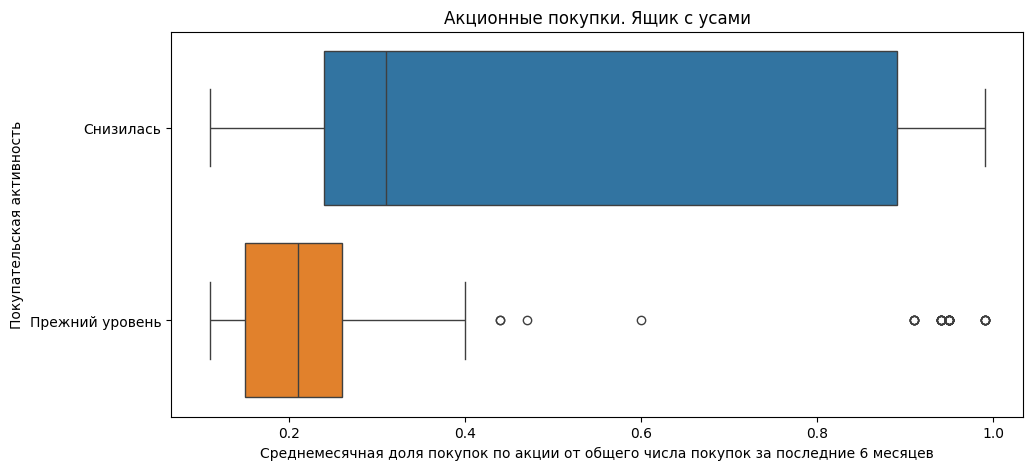

In [299]:
# Используем функцию для построения гистограммы и ящика с усами
hist_and_boxplot(
    df=market_file_df,
    x_col='акционные_покупки', 
    hue_col='покупательская_активность', 
    title='Акционные покупки',
    x_label='Cреднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев',
    bins=20
)

Распределение доли акционных покупок имеет ярко выраженный разрыв: большинство значений сосредоточено в диапазоне до 0.4, далее наблюдается резкое снижение частоты и лишь единичные случаи, а затем — всплеск в районе 0.85-1.0. Это может свидетельствовать о наличии двух поведенческих стратегий: часть пользователей делает покупки преимущественно по акциям. Особенно это характерно для группы с пониженной покупательской активностью — значительная доля таких пользователей совершает почти все покупки по акциям. Это может указывать на повышенную ориентированность на акционные условия и использоваться как стратегия для удержания клиентов.

Ящик с усами группы пользователей с прежним уровнем пользовательской активности показывает, что основная масса данных находится в диапазоне от 0.1 до 0.4, значения выше 0.4 считаются выбросами, однако они отображают реальное положение вещей.

**Средний просмотр категорий за визит**

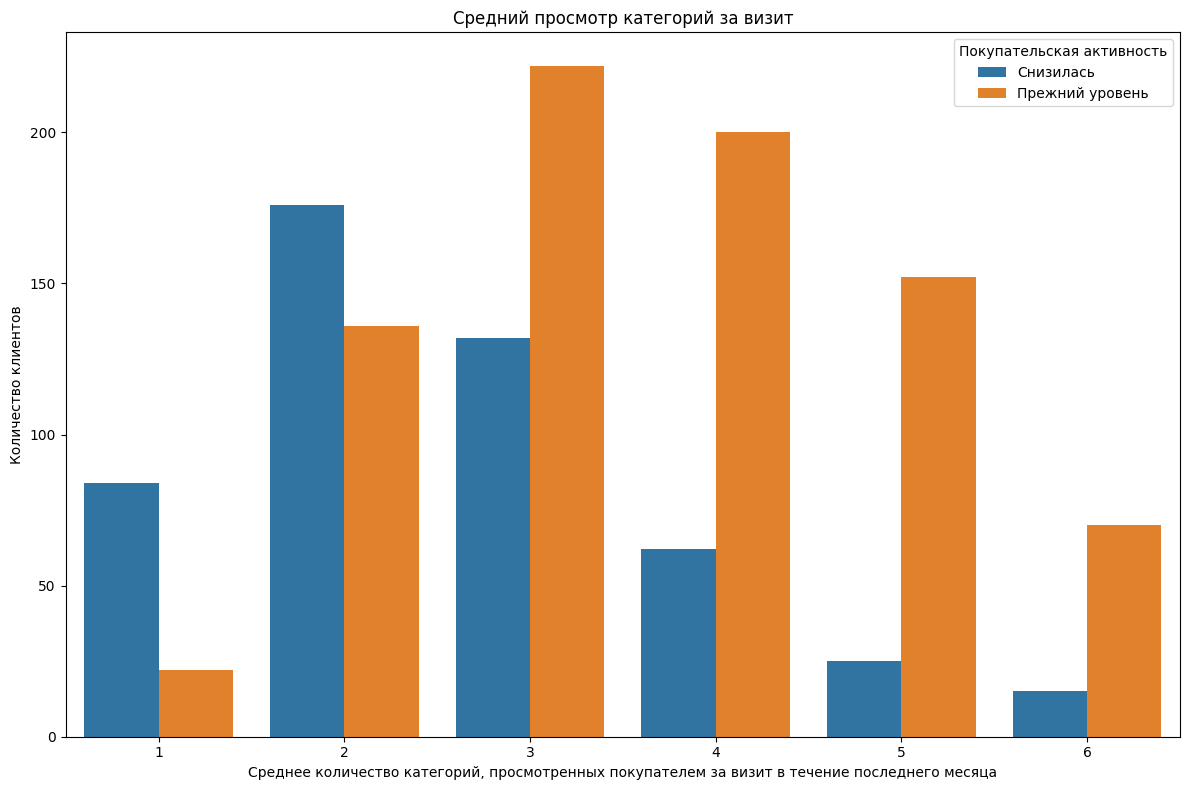

In [300]:
# Используем созданную функцию для построения столбчатой диаграммы с учётом пользовательской активности
countplot_with_hue(
    df=market_file_df,
    x_col='средний_просмотр_категорий_за_визит', 
    hue_col='покупательская_активность',
    title='Средний просмотр категорий за визит',
    x_label='Среднее количество категорий, просмотренных покупателем за визит в течение последнего месяца',
)

График показывает, что группа с пониженной покупательской активностью, имеет большее количество пользователей с 1 и 2 просмотренными категориями за последний месяц, чем группа с прежним уровнем покупательской активности. В диапазоне от 3 до 6 категорий гораздо больше пользователей с прежним уровнем покупательской активности, также чем больше значение количества категорий, тем меньше пользователей с пониженной активностью.

**Неоплаченные продукты в корзине за последние 3 месяца**

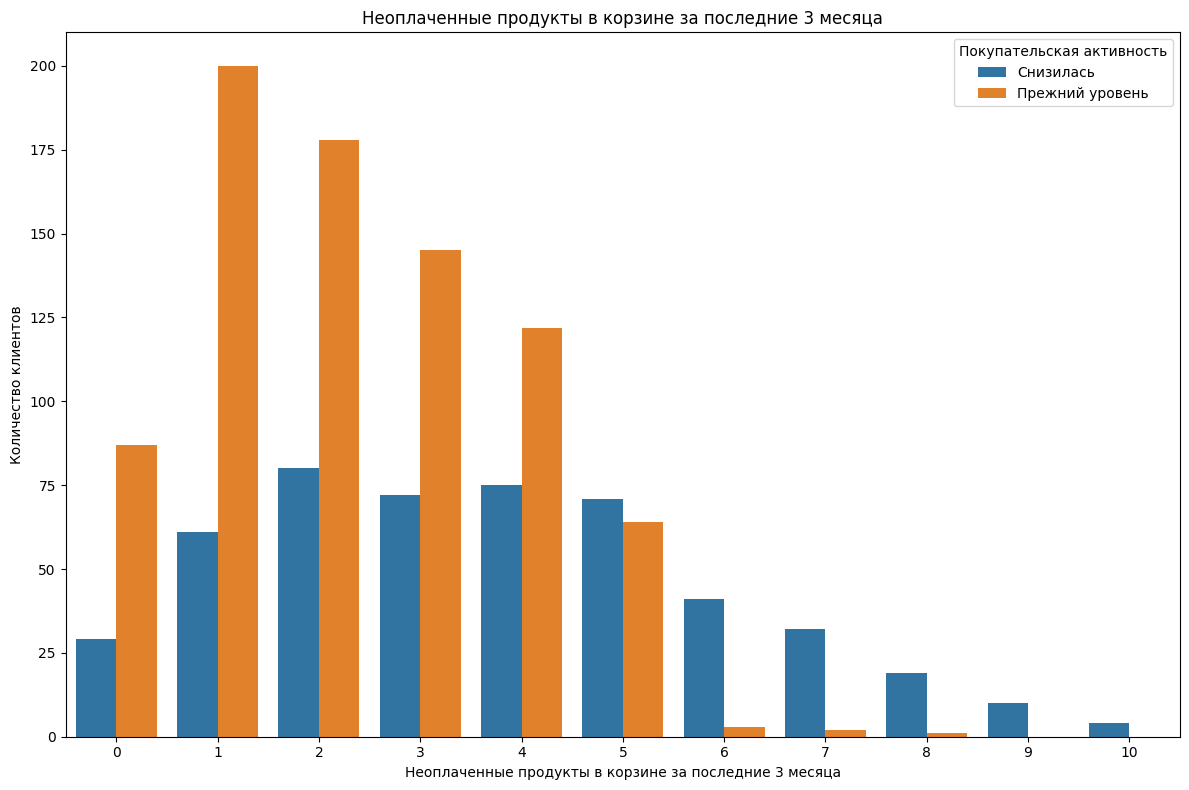

In [301]:
# Используем созданную функцию для построения столбчатой диаграммы с учётом пользовательской активности
countplot_with_hue(
    df=market_file_df,
    x_col='неоплаченные_продукты_штук_квартал', 
    hue_col='покупательская_активность',
    title='Неоплаченные продукты в корзине за последние 3 месяца',
    x_label='Неоплаченные продукты в корзине за последние 3 месяца',
)

Можно отметить то, что пользователей с шестью и более неоплаченных товаров в корзине гораздо больше из группы с пониженной активностью. Возможно, имеет смысл предлагать таким пользователям какие-то акции на выбранные товары, чтобы стимулировать покупки у таких пользователей, тем самым повышая их покупательскую активность.

**Число сбоев**

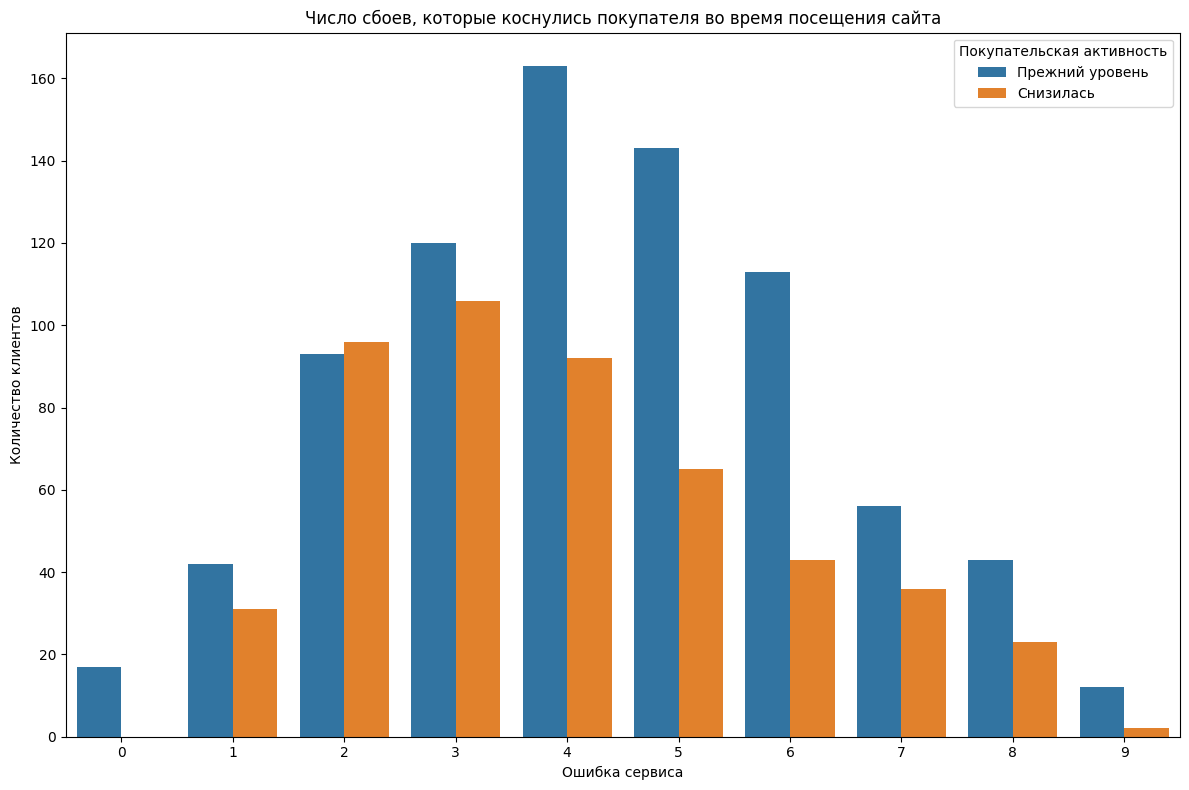

In [302]:
# Используем созданную функцию для построения столбчатой диаграммы с учётом пользовательской активности
countplot_with_hue(
    df=market_file_df,
    x_col='ошибка_сервиса', 
    hue_col='покупательская_активность',
    title='Число сбоев, которые коснулись покупателя во время посещения сайта',
    x_label='Ошибка сервиса',
)

Распределения обеих групп похожи на нормальные. Среднее количество ошибок примерно равно 4 для обеих групп.

**Среднее количество страниц, просмотренные покупателем за один визит на сайт за последние 3 месяца**

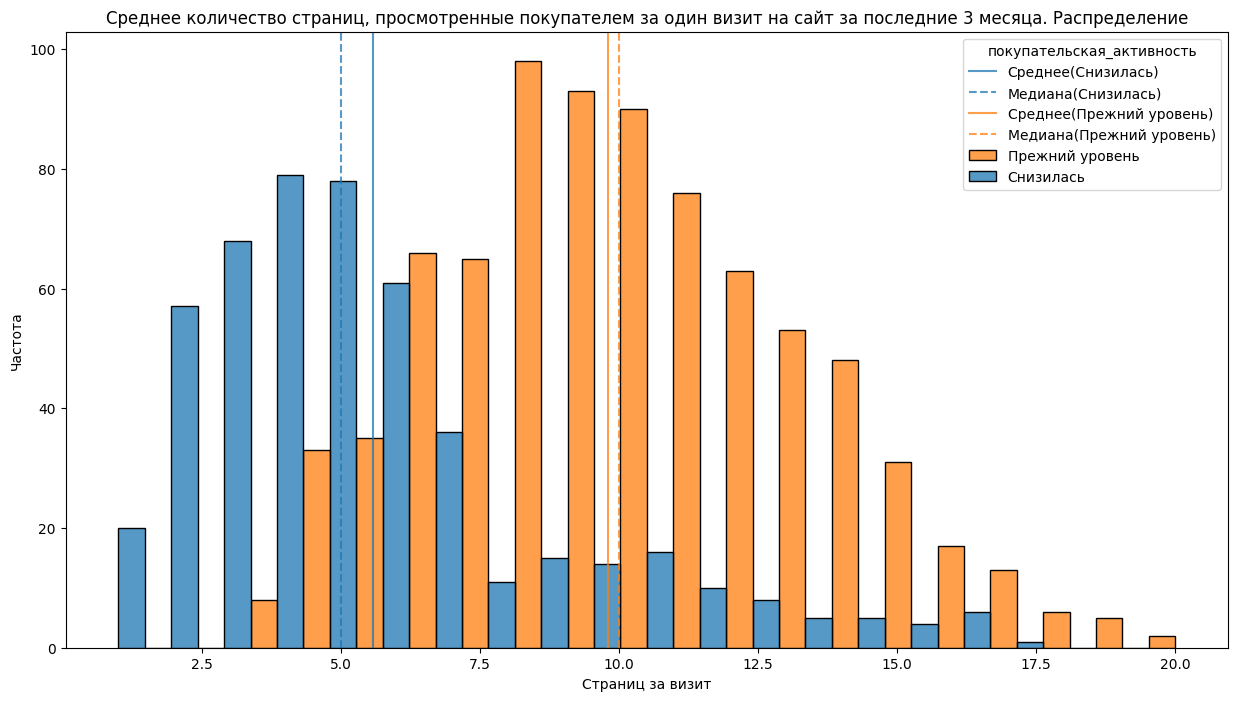

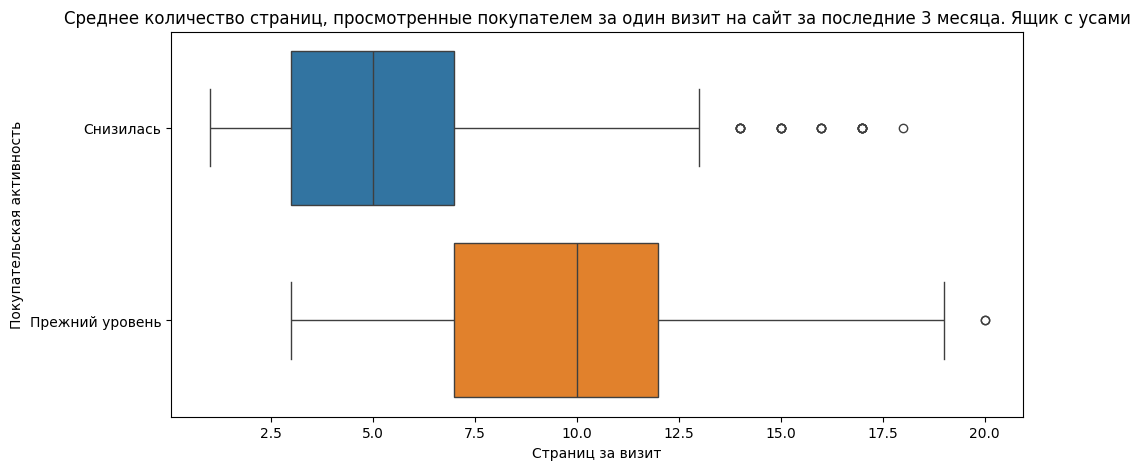

In [303]:
hist_and_boxplot(
    df=market_file_df,
    x_col='страниц_за_визит', 
    hue_col='покупательская_активность', 
    title='Среднее количество страниц, просмотренные покупателем за один визит на сайт за последние 3 месяца',
    x_label='Страниц за визит',
    bins=20
)

Распределение среднего количества страниц, просмотренных за визит, для пользователей с пониженной активностью скошено вправо с пиком около 4-5 страниц, тогда как у пользователей с прежним уровнем активности пик выше, около 7-10 страниц, само распределение более растянуто, до 20 страниц. Это говорит о том, что пользователи с пониженной активностью смотрят меньше страниц.

Ящики с усами подтверждают гистограмму: медиана у группы с пониженной активностью равна 5 страницам, а у второй 10, что подтверждает меньшую активность. Пользователи с пониженной активностью просматривают значительно меньше страниц, что логично, учитывая снижение их общей покупательской активности.

#### Шаг 3.3.1.2 Категориальные признаки

**Покупательская активность**

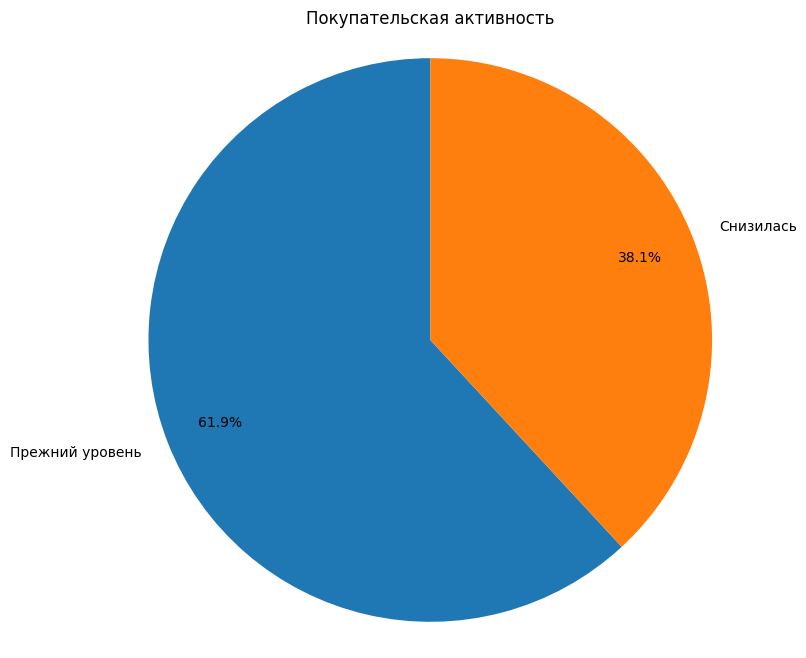

Покупательская активность  Количество
0           Прежний уровень         802
1                 Снизилась         494

In [304]:
# Используем созданную функцию для построения круговой диаграммы
pie_plot(market_file_df['покупательская_активность'], 'Покупательская активность')

Покупательская активность осталась на прежнем уровне у 802 покупателей (61.8%), а снизилась у 494 покупателей (38.1%).

**Тип сервиса**

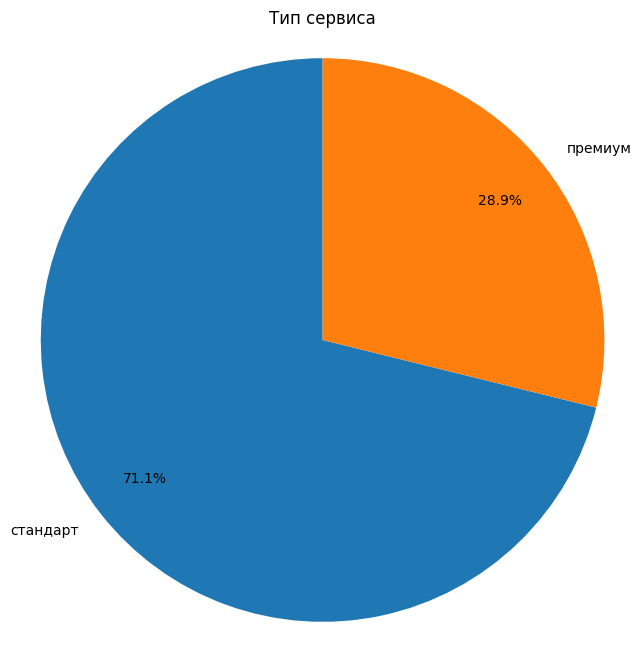

Тип сервиса  Количество
0    стандарт         922
1     премиум         374

In [305]:
# Используем созданную функцию для построения круговой диаграммы
pie_plot(market_file_df['тип_сервиса'], 'Тип сервиса')

922 пользователя (71.1%) используют тип сервиса "стандарт", 374 пользователя (28.9%) используют тип сервиса "премиум". Получается, что пользователей, которые используют тип сервиса "премиум", практически в 2.5 раза меньше.

Построим столбчатую диаграмму.

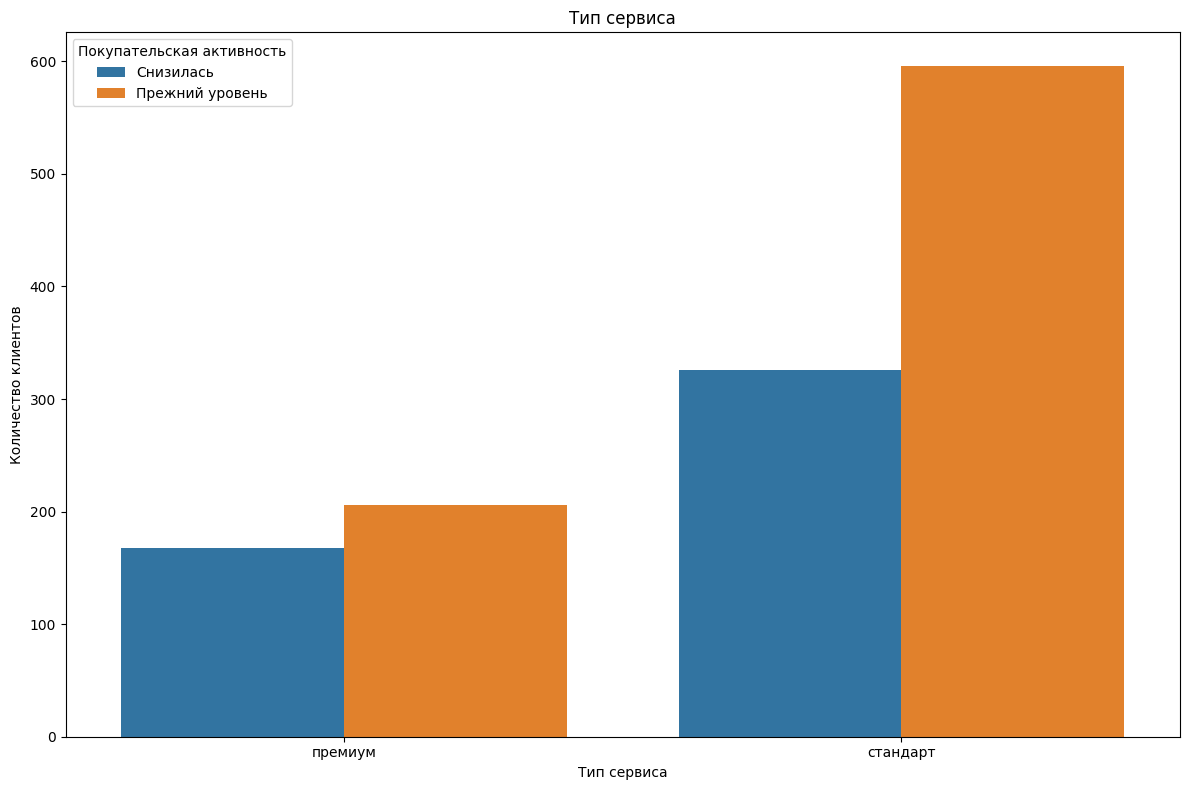

In [306]:
# Используем созданную функцию для построения столбчатой диаграммы с учётом пользовательской активности
countplot_with_hue(
    df=market_file_df,
    x_col='тип_сервиса',
    hue_col='покупательская_активность',
    title='Тип сервиса',
    x_label='Тип сервиса'
)

Можно отметить, что количество пользователей, использующих тип сервиса "премиум", у которых снизилась покупательская активность, примерно равно количеству пользователей с прежним уровнем покупательской активности. Возможно, стоит задуматься об улучшении условий при использовании "премиум" сервиса, чтобы удерживать пользователей, которые решили его оформить.

**Разрешение сообщать о дополнительных предложениях о товаре**

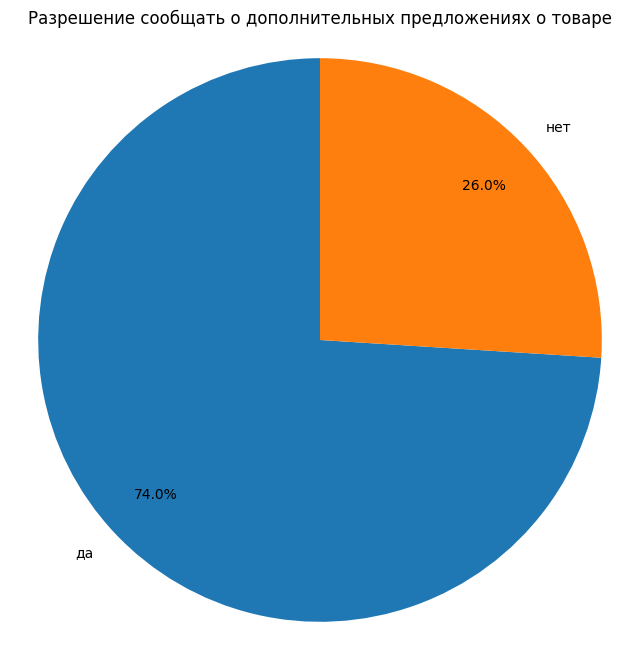

Разрешение сообщать о дополнительных предложениях о товаре  Количество
0                                                 да                 959
1                                                нет                 337

In [307]:
# Используем созданную функцию для построения круговой диаграммы
pie_plot(market_file_df['разрешить_сообщать'], 'Разрешение сообщать о дополнительных предложениях о товаре')

74.0% (959 пользователя) дали согласие на рассылку дополнительных предложений о товаре, в то время как 26% (337 пользователей) не дали согласия.

Построим столбчатую диаграмму с учётом покупательской активности.

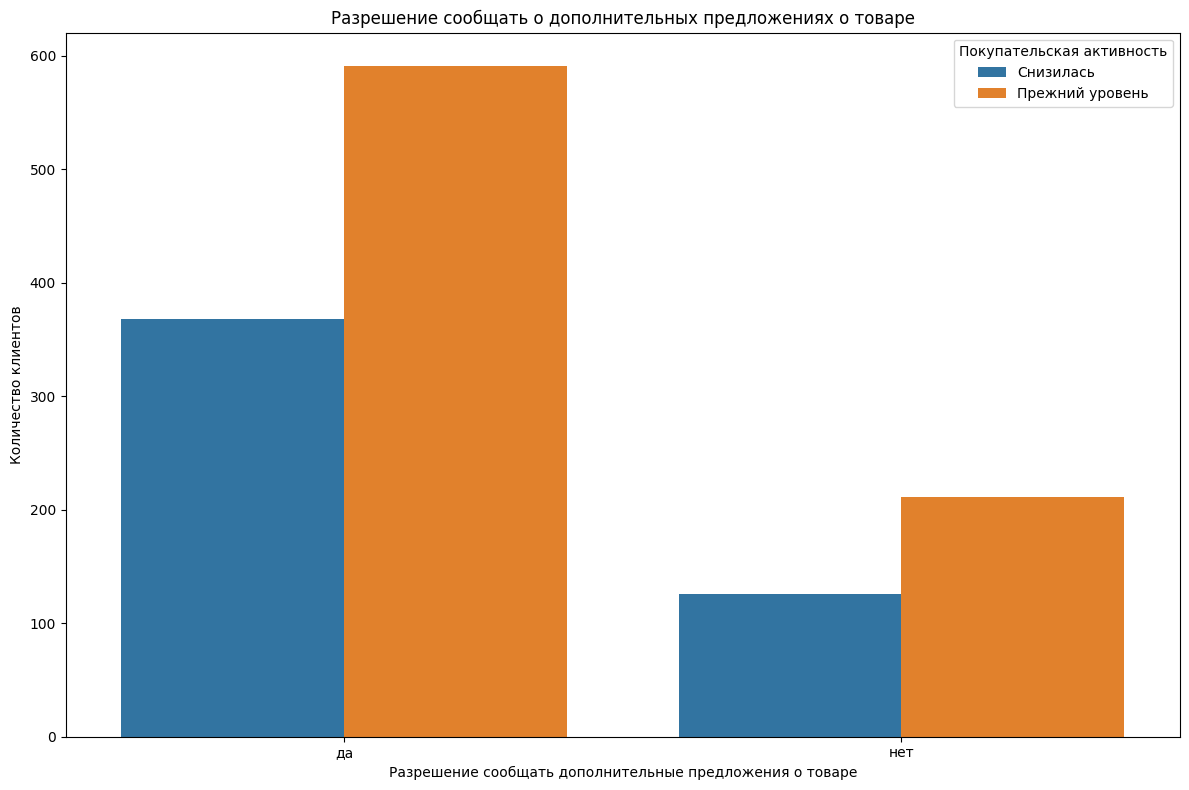

In [308]:
# Используем созданную функцию для построения столбчатой диаграммы с учётом пользовательской активности
countplot_with_hue(
    df=market_file_df,
    x_col='разрешить_сообщать',
    hue_col='покупательская_активность',
    title='Разрешение сообщать о дополнительных предложениях о товаре',
    x_label='Разрешение сообщать дополнительные предложения о товаре'
)

Разрешение на дополнительные предложения распределено схожим образом в обеих группах, вне зависимости от уровня покупательской активности. Мы знаем, что пользователей с пониженной активностью значительно меньше (38.2%) по сравнению с группой с прежним уровнем активности (61.8%), что видно на данной диаграмме.

**Популярная категория**

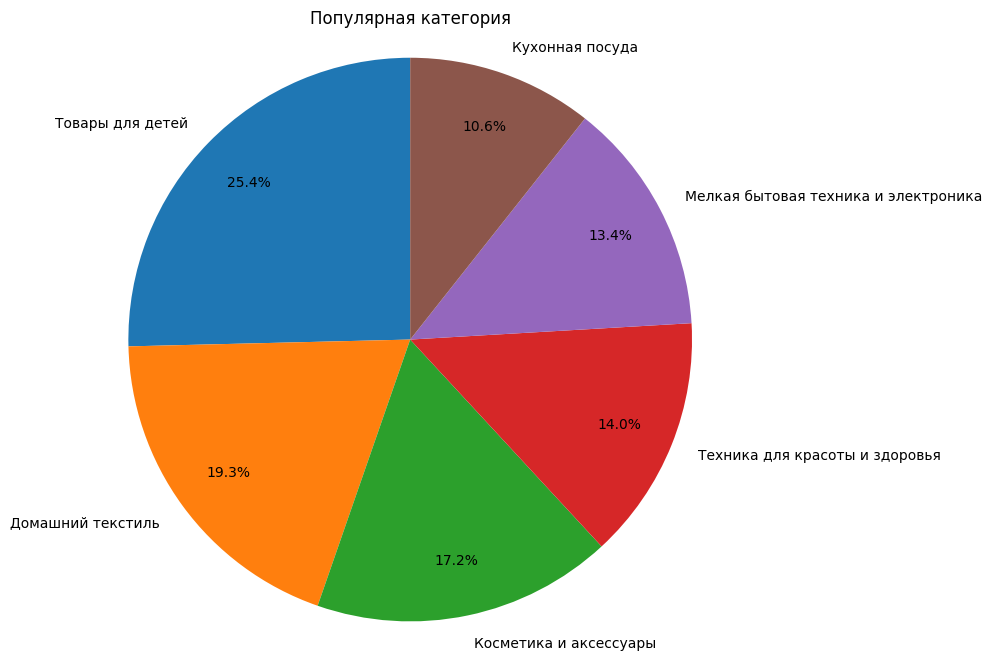

Популярная категория  Количество
0                      Товары для детей         329
1                     Домашний текстиль         250
2                Косметика и аксессуары         223
3        Техника для красоты и здоровья         182
4  Мелкая бытовая техника и электроника         174
5                       Кухонная посуда         138

In [309]:
# Используем созданную функцию для построения круговой диаграммы
pie_plot(market_file_df['популярная_категория'], 'Популярная категория')

Категории товаров по популярности:
1. Товары для детей — самая популярная категория у пользователей (329 — 25.4%)
2. Домашний текстиль — 250 пользователь (19.3%)
3. Косметика и аксессуары — 223 пользователя (17.2%)
4. Техника для красотыы и здоровья — 182 пользователя (14.0%)
5. Мелкая бытовая техника и электроника — 174 пользователя (13.4%)
6. Кухонная посуда — 138 пользователя (10.6%).

Построим столбчатую диаграмму с учётом покупательской активности.

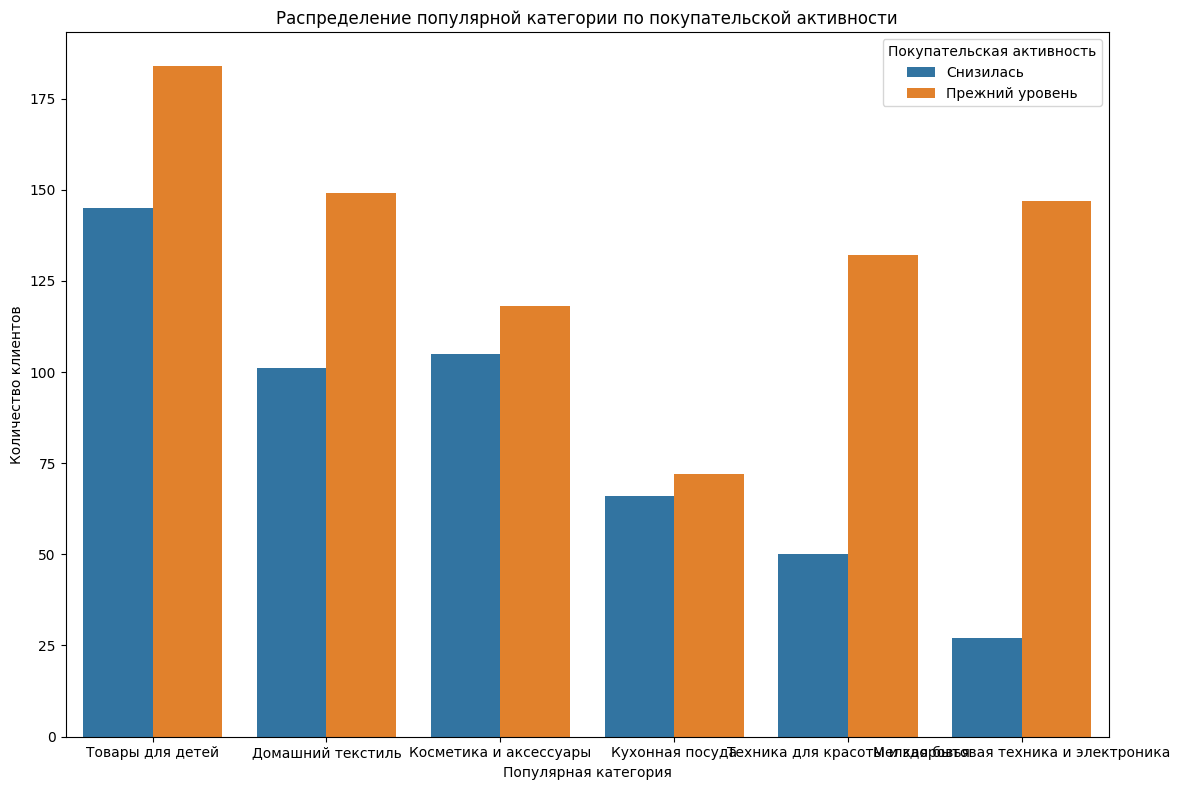

In [310]:
# Используем созданную функцию для построения столбчатой диаграммы с учётом пользовательской активности
countplot_with_hue(
    df=market_file_df,
    x_col='популярная_категория',
    hue_col='покупательская_активность',
    title='Распределение популярной категории по покупательской активности',
    x_label='Популярная категория'
)

Можно заметить, что покупательская активность снизилась меньше всего в категориях "Мелкая бытовая техника и электроника", "Техника для красоты и здоровья" и "Кухонная посуда". Больше всего покупательская активность снизилась в категории "Товары для детей".

Это говорит о том, что разные категории имеют разное влияние на снижение покупательской активности.

#### Шаг 3.3.2 Датафрейм с данными о выручке, которую получает магазин с покупателя

Напишем функцию для построения столбчатой диаграммы с разделением по категориальной переменной.

**Выручка, которую получает магазин с покупателя, за разные периоды**

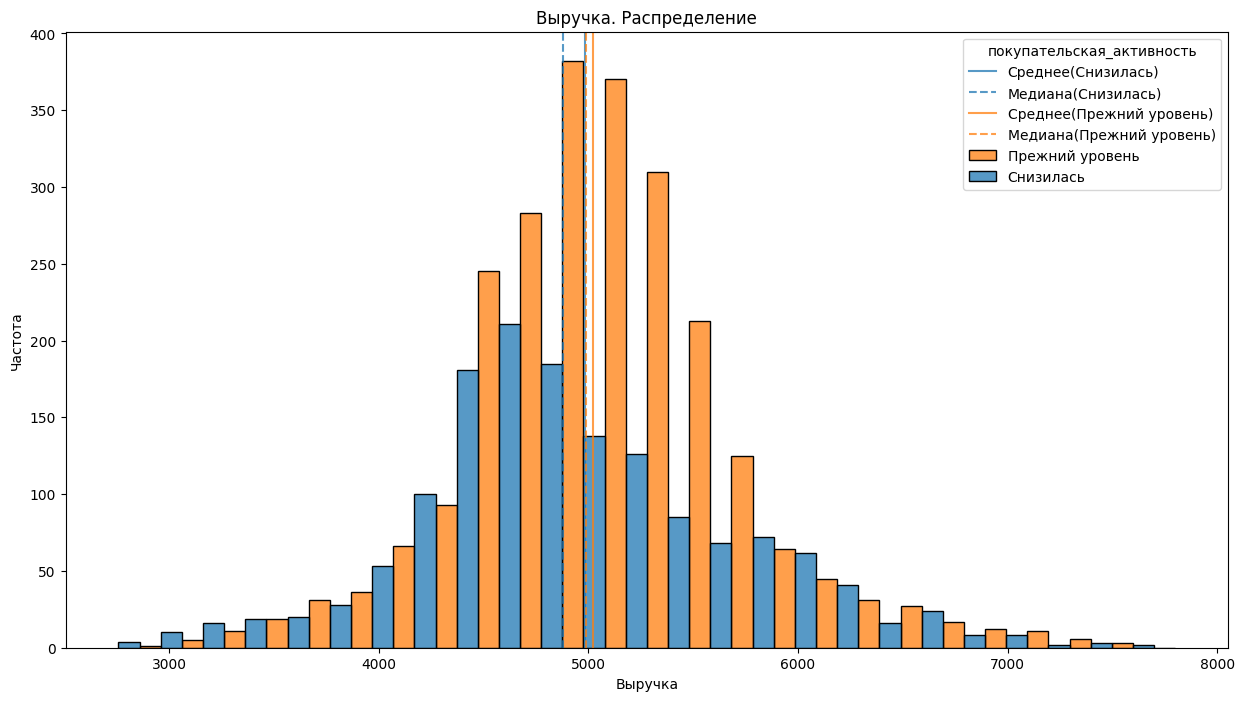

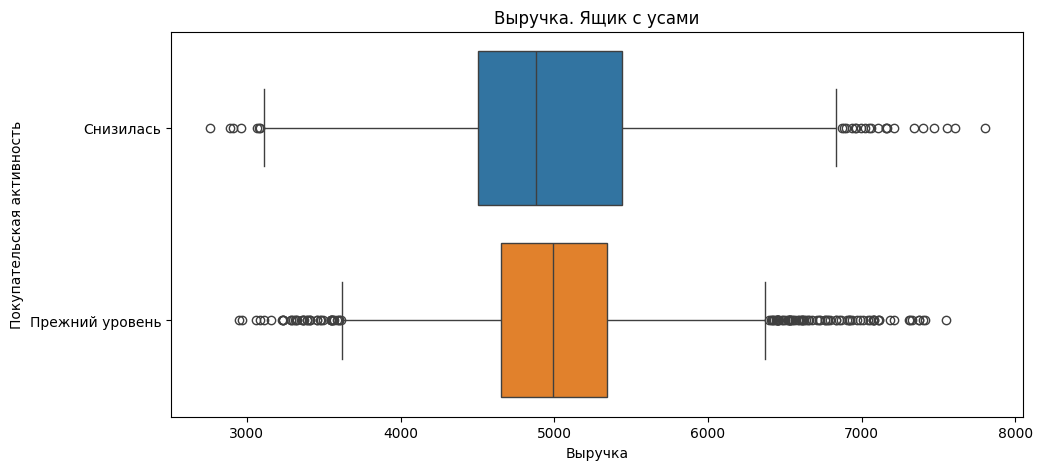

In [311]:
# Создаём сводную таблицу
pivot_df = market_file_df.merge(market_money_df, on='id', how='left')
# Строим график распределения
hist_and_boxplot(
    df=pivot_df,
    x_col='выручка', 
    hue_col='покупательская_активность', 
    title='Выручка',
    x_label='Выручка',
    bins=25
)

Распределение обеих групп напоминает нормальное распределение. Распределение группы с пониженной покупательской активностью имеет довольно-таки выраженное правостороннее смещение.

Ящики с усами показывают, что выбросы есть в обеих группах с обеих сторон распределения. Несмотря на это, выбросы не выбиваются критически, поэтому оставим их, так как они могут содержать полезную информацию для обучения моделей.

Построим гистограммы для выручки по каждому периоду.

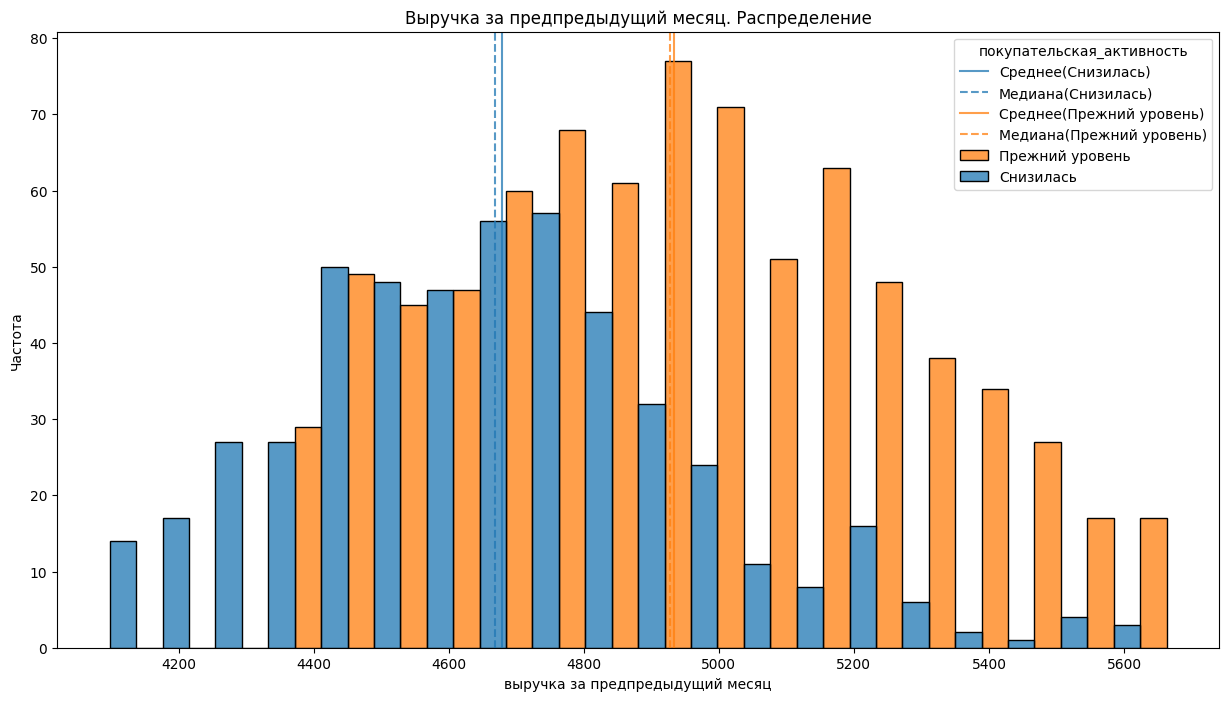

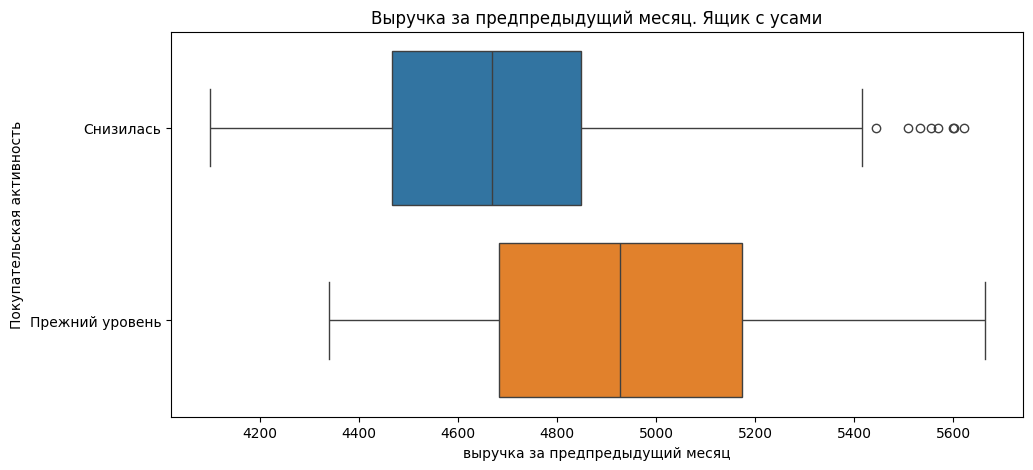

In [312]:
# Создаём сводную таблицу с выручкой по месяцам
revenue_by_month = market_file_df[['id', 'покупательская_активность']].merge(
    market_money_df.pivot_table(index='id', columns='период', values='выручка'), on='id')

# Строим график распределения выручки за предпредыдущий месяц по группам
hist_and_boxplot(
    df=revenue_by_month,
    x_col='предпредыдущий_месяц', 
    hue_col='покупательская_активность', 
    title='Выручка за предпредыдущий месяц',
    x_label='выручка за предпредыдущий месяц',
    bins=20
)

Распределение группы с прежним уровнем напоминает нормальное, у распределения группы с пониженным уровнем покупательской активности имеет длинный правый хвост. Это же подтверждает и ящик с усами: видны выбросы справа от верхнего уса. Среднее и медиана группы с пониженной активностью (около 4650) меньше, чем у группы с прежним уровнем активности (около 4950).

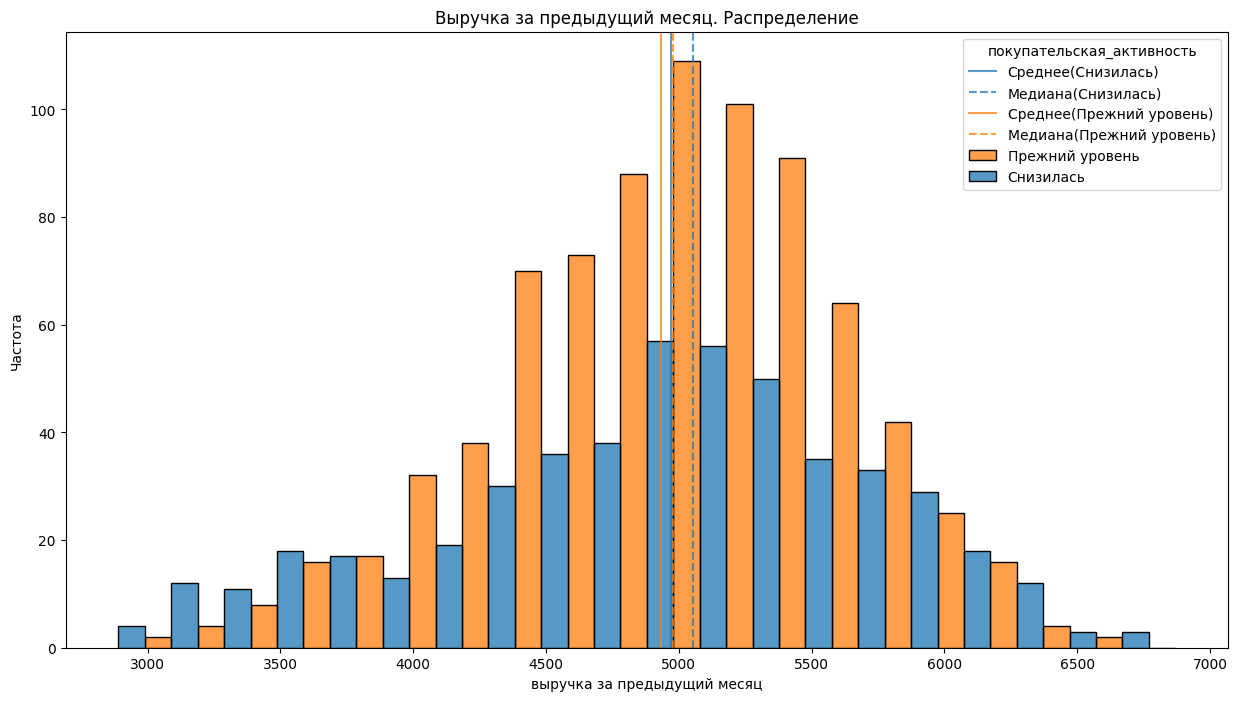

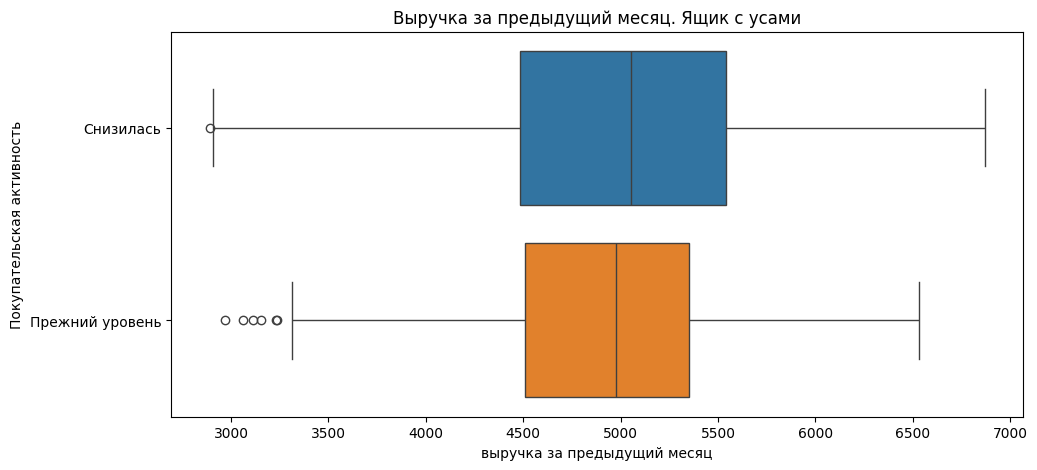

In [313]:
# Строим график распределения выручки за предыдущий месяц по группам
hist_and_boxplot(
    df=revenue_by_month,
    x_col='предыдущий_месяц', 
    hue_col='покупательская_активность', 
    title='Выручка за предыдущий месяц',
    x_label='выручка за предыдущий месяц',
    bins=20
)

В сравнении с распределением выручки за предпредыдущий месяц можно увидеть, что медианное значение группы с пониженной покупательской активностью немного больше, чем у группы с прежним уровнем.

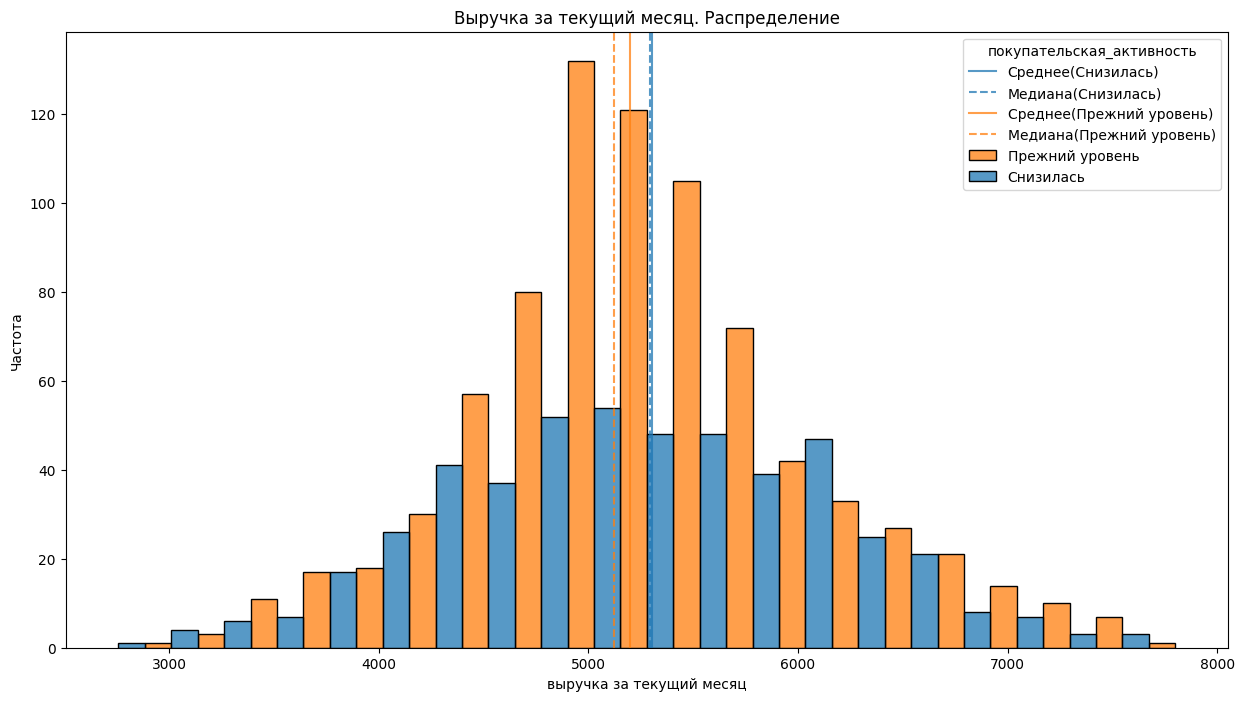

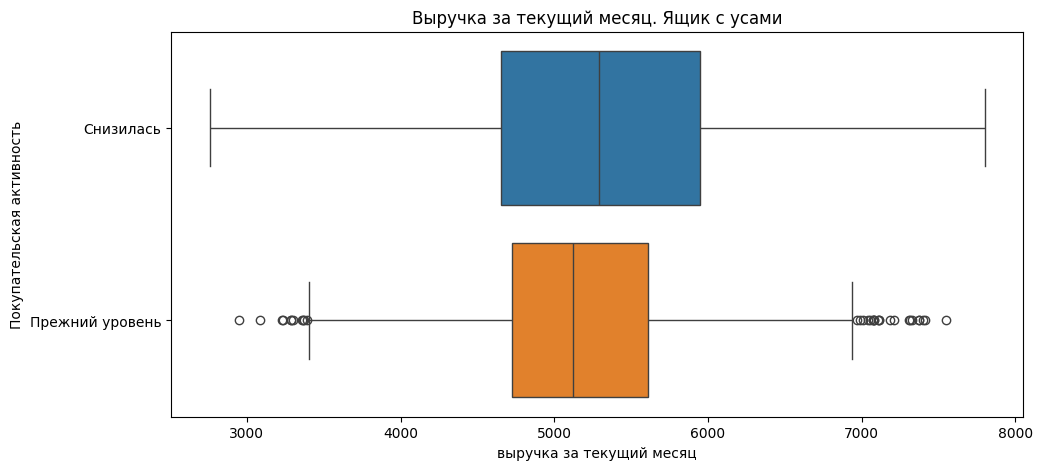

In [314]:
# Строим график распределения выручки за предыдущий месяц по группам
hist_and_boxplot(
    df=revenue_by_month,
    x_col='текущий_месяц', 
    hue_col='покупательская_активность', 
    title='Выручка за текущий месяц',
    x_label='выручка за текущий месяц',
    bins=20
)

В текущем месяце и среднее и медиана группы с пониженной активностью больше, чем у группы с прежним уровнем активности. У группы с прежним уровнем активности основная часть значений находится около среднего значения, об этом также говорит и наличие довольно-таки большого количества выбросов по обе стороны от усов на ящике с усами.

#### Шаг 3.3.3 Датафрейм с данными о времени, которое покупатель провёл на сайте в течение периода

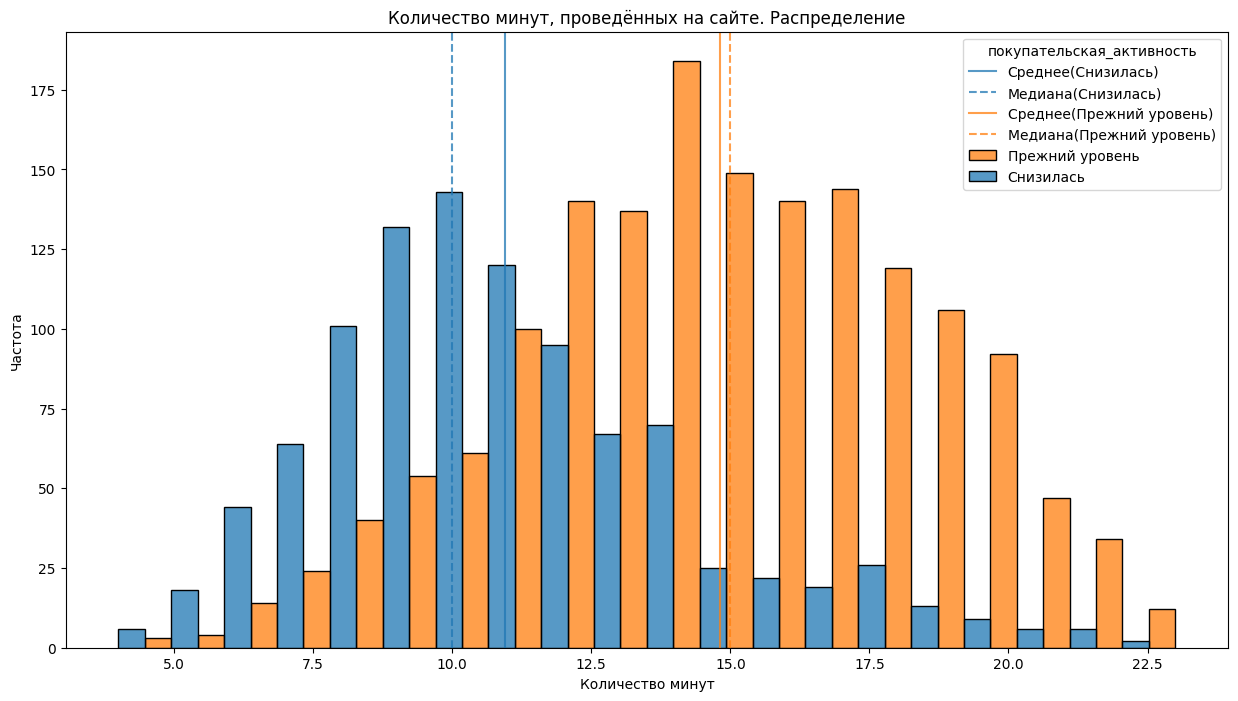

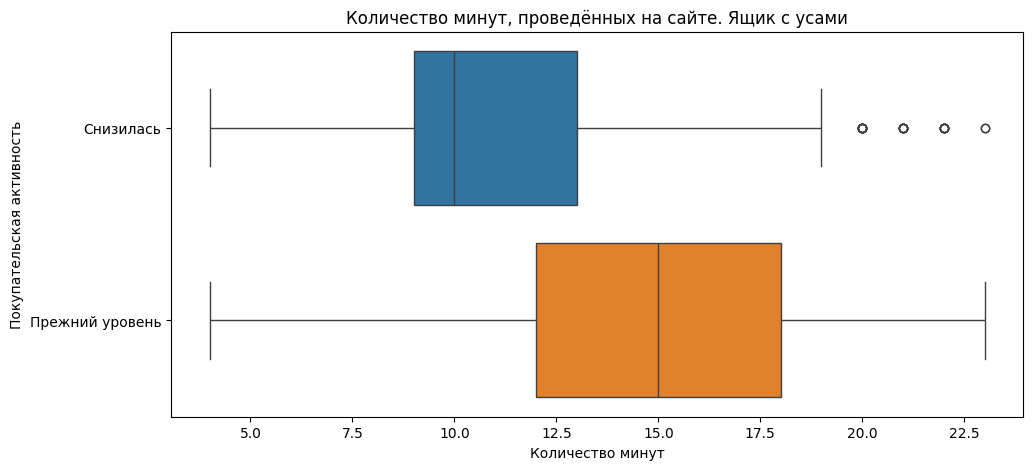

In [315]:
# Создаём сводную таблицу
pivot_df = market_file_df.merge(market_time_df, on='id', how='left')

# Строим график распределения
hist_and_boxplot(
    df=pivot_df,
    x_col='минут', 
    hue_col='покупательская_активность', 
    title='Количество минут, проведённых на сайте',
    x_label='Количество минут',
    bins=20
)

Распределения количества минут, проведенных на сайте, для пользователей с пониженной активностью скошено вправо с пиком в районе 10 минут, тогда как для пользователей с прежним уровнем активности пик выше, около 14-15 минут. Это показывает, что пользователи с прежним уровнем активности проводят больше времени на сайте.

Ящик с усами показывает, что медиана у группы с пониженной активностью равна 10, а у группы с прежним уровнем активности — 15 минут, что подтверждает данные гистограммы. Пользователи с пониженной активностью проводят меньше времени на сайте, что логично, учитывая их сниженную вовлеченность.

График показывает, что пользователи с пониженной покупательской активностью проводят на сайте меньше времени, чем пользователи с прежней покупательской активностью, что абсолютно логично.

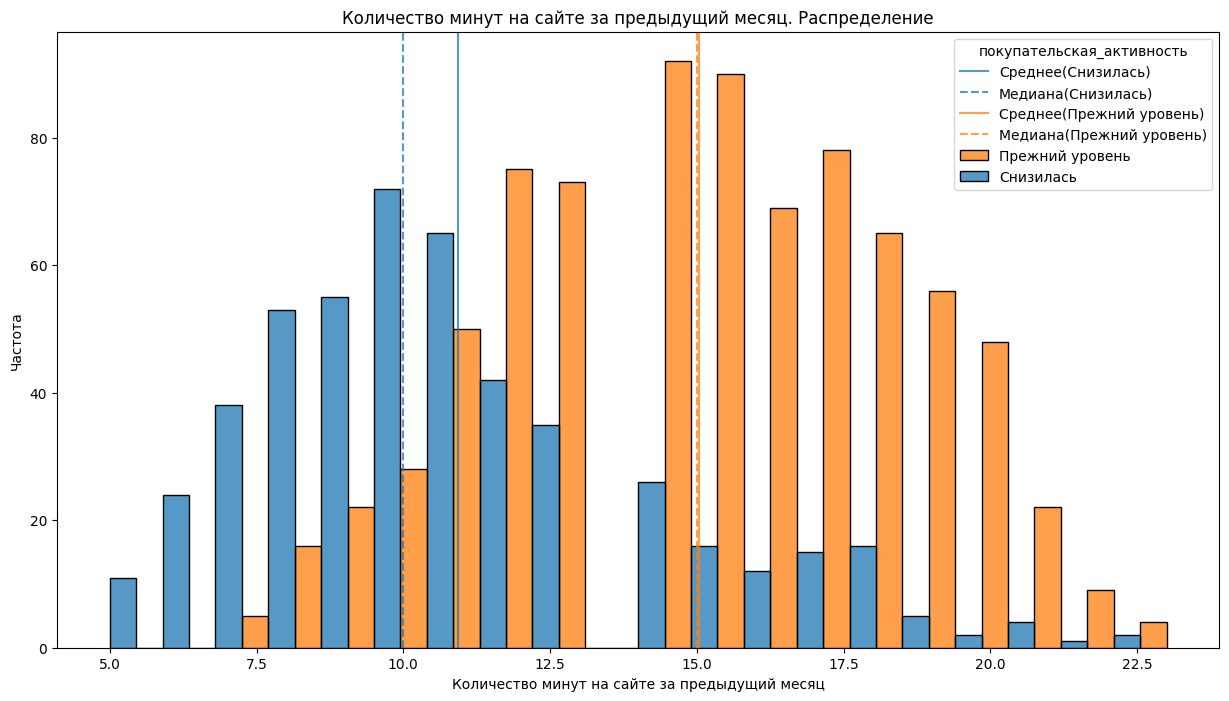

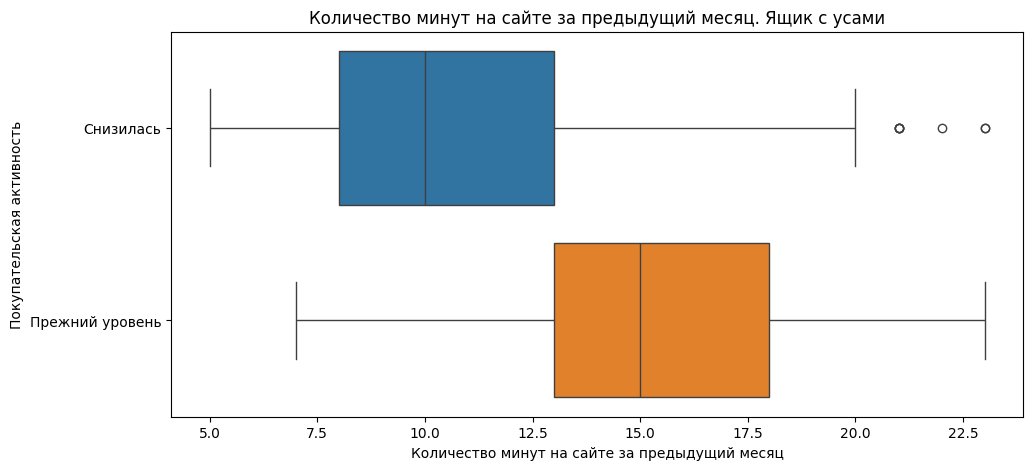

In [316]:
# Создаём сводную таблицу с выручкой по месяцам
minutes_by_month = market_file_df[['id', 'покупательская_активность']].merge(
    market_time_df.pivot_table(index='id', columns='период', values='минут'), on='id')

# Строим график распределения количества минут на сайте за предыдущий месяц по группам
hist_and_boxplot(
    df=minutes_by_month,
    x_col='предыдущий_месяц', 
    hue_col='покупательская_активность', 
    title='Количество минут на сайте за предыдущий месяц',
    x_label='Количество минут на сайте за предыдущий месяц',
    bins=20
)

Графики показывают, что пользователи с прежним уровнем активности проводили гораздо больше времени на сайте в предыдущем месяце.

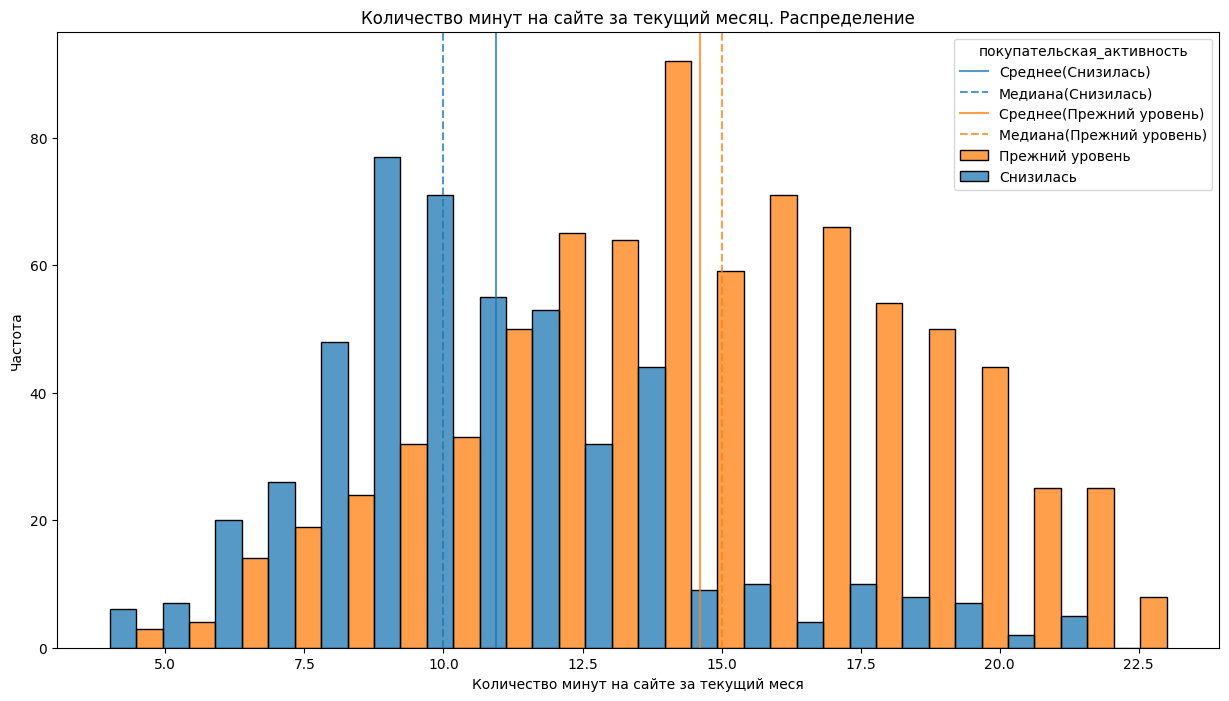

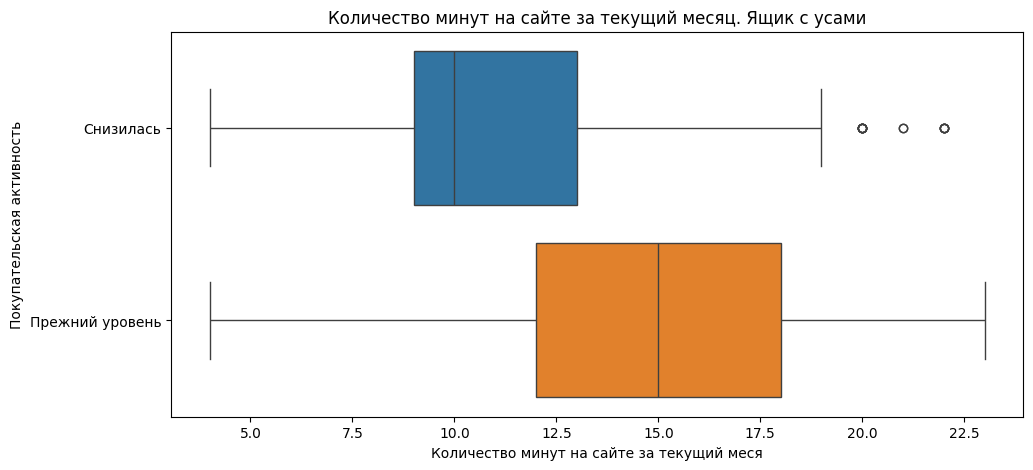

In [317]:
# Строим график распределения количества минут на сайте за предыдущий месяц по группам
hist_and_boxplot(
    df=minutes_by_month,
    x_col='текущий_месяц', 
    hue_col='покупательская_активность', 
    title='Количество минут на сайте за текущий месяц',
    x_label='Количество минут на сайте за текущий меся',
    bins=20
)

В текущем месяце ситуация такая же как и в предыдущем: пользователи с пониженным уровнем покупательской активности проводят на сайте меньше времени.

#### Шаг 3.3.4 Датафрейм с данными о среднемесячной прибыли продавца за последние 3 месяца

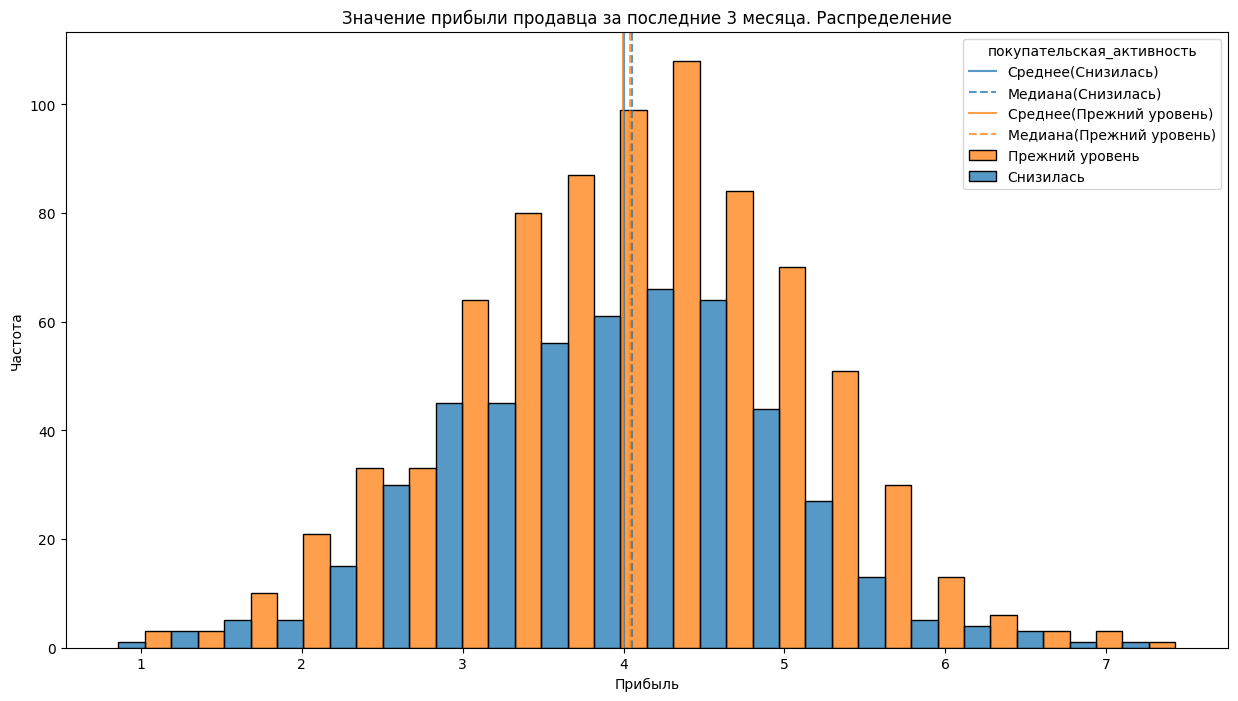

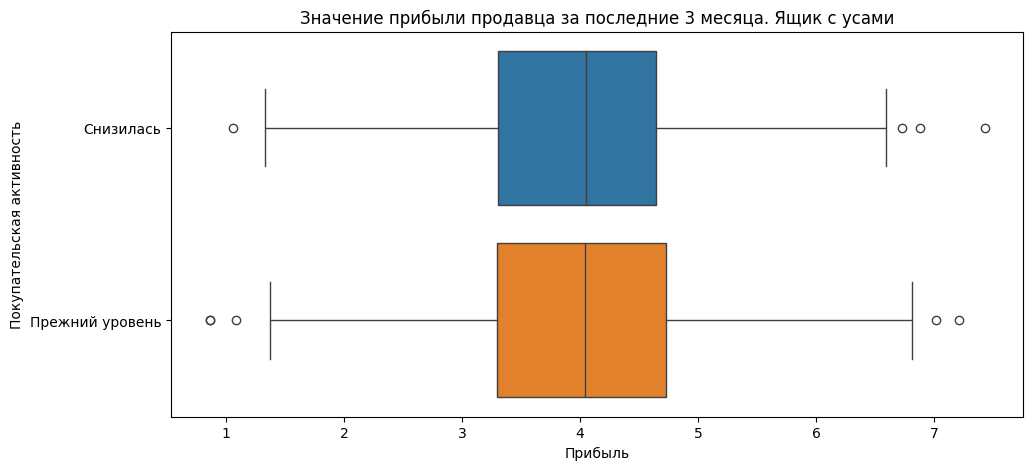

In [318]:
# Создаём сводную таблицу
pivot_df = market_file_df.merge(money_df, on='id', how='left')

# Строим график распределения
hist_and_boxplot(
    df=pivot_df,
    x_col='прибыль', 
    hue_col='покупательская_активность', 
    title='Значение прибыли продавца за последние 3 месяца',
    x_label='Прибыль',
    bins=20
)

Распределения являются нормальными: имеют форму колокола и симметрию. Основная масса значений находится в середине, средние значения и медианы находятся практически в одном месте в районе 4.

Ящики с усами подтверждает нормальность распределений.

#### Шаг 3.4 Вывод

Был проведён статистический анализ всех количественных признаков. Было обнаружено и удалено аномальное значение выручки.

Были отобраны клиенты с покупательской активностью не менее трёх месяцев.

Были построены и описаны графики для каждого признака:
- для количественных признаков были построены гистограммы распределений с учётом покупательской активности, ящики с усами, а также столбчатые диаграммы.
- для категориальных признаков были построены круговые диаграммы, выведены значения количества признаков. Также были построены столбчатые диаграммы `countplot` и `barplot` с учётом покупательской активности.

## Шаг 4. Объединение таблиц

#### Шаг 4.1 Объединение трёх датафреймов в один с разделением столбцов по периодам

Объединим датафреймы `market_file_df`, `market_money_df`, `market_time_df`. Учитывая то, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов, сделаем отдельные столбцы для каждого периода.

In [319]:
# Присваиваем первый датафрейм в новую переменную
merged_df = market_file_df


def merge_dfs(initial_df, df_to_merge, values):
    """
    Объединяет датафреймы, разделяя на столбцы по периодам
    """
    # Создаём сводную таблицу
    pivot = df_to_merge.pivot_table(index='id', columns='период', values=values)
    # Убираем название группировки колонок
    pivot.columns.name = None
    # Превращаем индекс в обычный столбец
    pivot = pivot.reset_index()
    # Меняем названия столбцов
    pivot.columns = [
        values + '_за_' + str(col) if 'месяц' in str(col) else str(col)
        for col in pivot.columns
    ]
    initial_df = initial_df.merge(pivot, on='id')
    return initial_df


# Объединяем с датафреймом market_money_df
merged_df = merge_dfs(merged_df, market_money_df, 'выручка')
# Объединяем с датафреймом market_time_df
merged_df = merge_dfs(merged_df, market_time_df, 'минут')
# Делаем столбец id индексом датафрейма
merged_df = merged_df.set_index('id')
# выводим на экран для проверки
display(merged_df.head())
merged_df.info()

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   
215353               0.26    Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        выручка_за_предпредыдущий_месяц  выручка_за_предыдущий_месяц  \
id                                                                     
215349                           4472.0                       5216.0   
215350                           4826.0                       5457.5   
215351                           4793.0                       6158.0   
215352                           4594.0                       5807.5   
215353                           5124.0                       4738.5   

        выручка_за_текущий_месяц  минут_за_предыдущий_месяц  \
id                                                            
215349                    4971.6                         12   
215350                    5058.4                          8   
215351                    6610.4                         11   
215352                    5872.5                          8   
215353                    5388.5                         10   

        минут_за_текущий_месяц  
id                              
215349                      10  
215350                      13  
215351                      13  
215352                      11  
215353                      10

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

#### Шаг 4.2 Вывод

Три датафрейма `market_file_df`, `market_money_df`, `market_time_df` был объединены в один датафрейм `merged_df`. Данные о выручке и времени на сайте были разделены по периодам в отдельные столбцы.

## Шаг 5. Корреляционный анализ

#### Шаг 5.1 Построение матрицы корреляций Спирмена для количественных признаков

Для того чтобы провести корреляционны анализ признаков в количественной шкале, построим матрицу корреляций Спирмена, так как не все количественные признаки имеют нормального распределения.

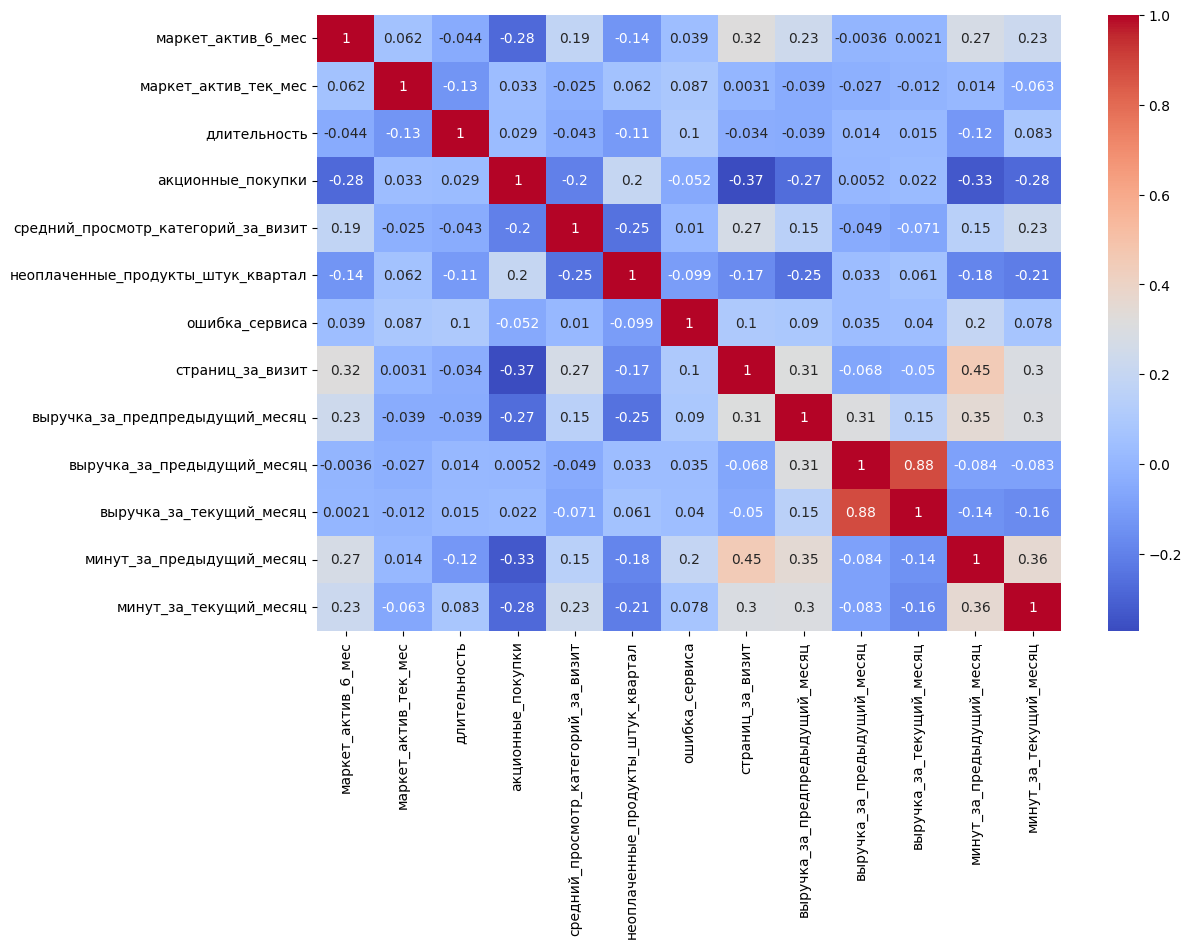

In [320]:
# Задаём список столбцов с количественными переменными
interval_cols = merged_df.select_dtypes(include='number').columns.tolist()

# Строим тепловую карту матрицы корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[interval_cols].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.show()

Единственное большое значение коэффициента корреляции Спирмена — 0.88 между выручкой за текущий месяц и выручкой за предыдущий месяц, что не дотягивает до 0.9-0.95 по модулю для мультиколлинеарности. Все остальные признаки в целом коррелируют довольно слабо.

Выручка за текущий и предыдущий месяц сильно коррелируют. Также у этих признаков довольно высокие коэффициенты VIF. Добавим новый столбец `сумма_выручки`, в котором суммируем столбцы `выручка_за_предыдущий_месяц` и `выручка_за_предпредыдущий_месяц` для дальнейшего проведения анализа.

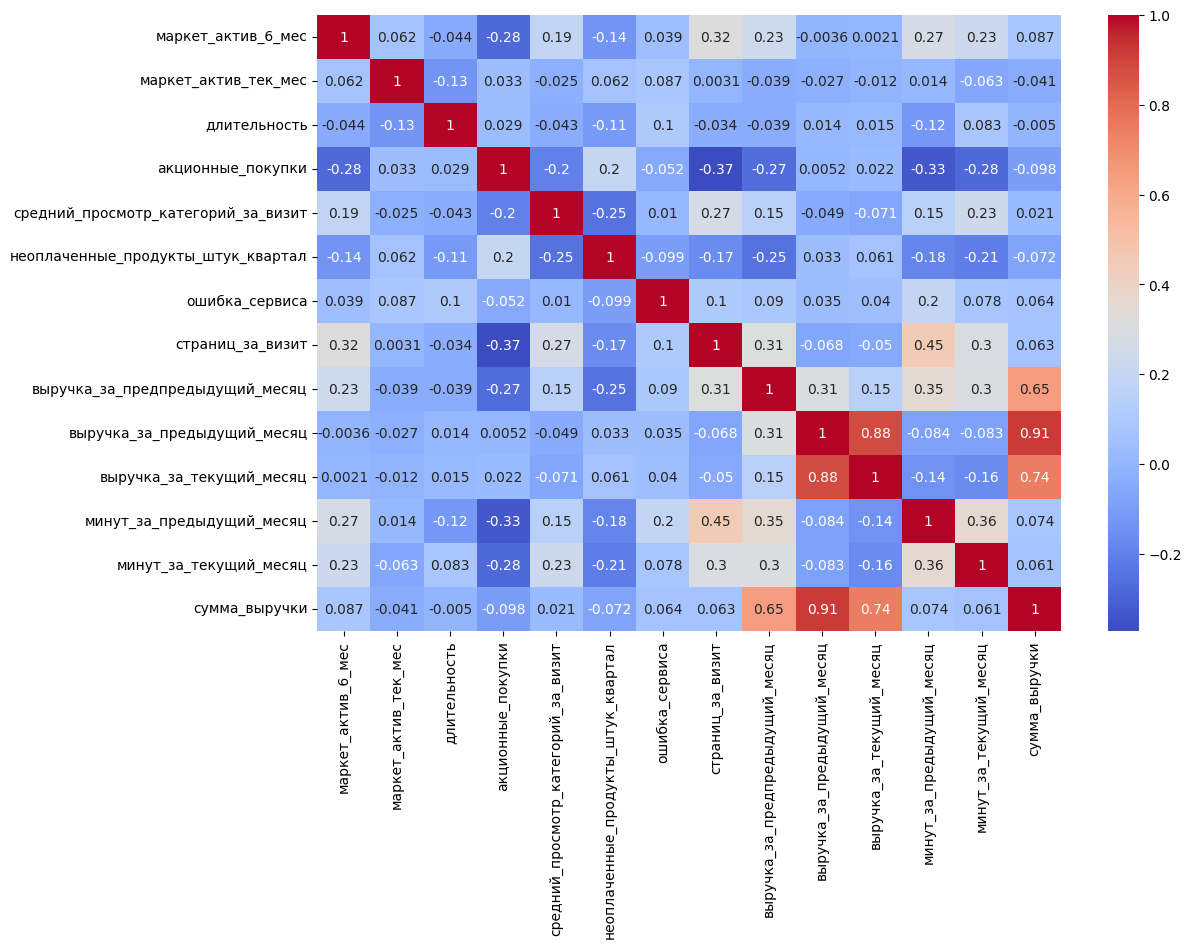

In [321]:
# Добавляем столбец с суммой выручки за предпредыдущий и предыдущий месяцы
merged_df['сумма_выручки'] = merged_df['выручка_за_предыдущий_месяц'] + merged_df['выручка_за_предпредыдущий_месяц']
# Выделяем количественные признаки
interval_cols = merged_df.select_dtypes(include='number').columns.tolist()

# Строим тепловую карту матрицы корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[interval_cols].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.show()

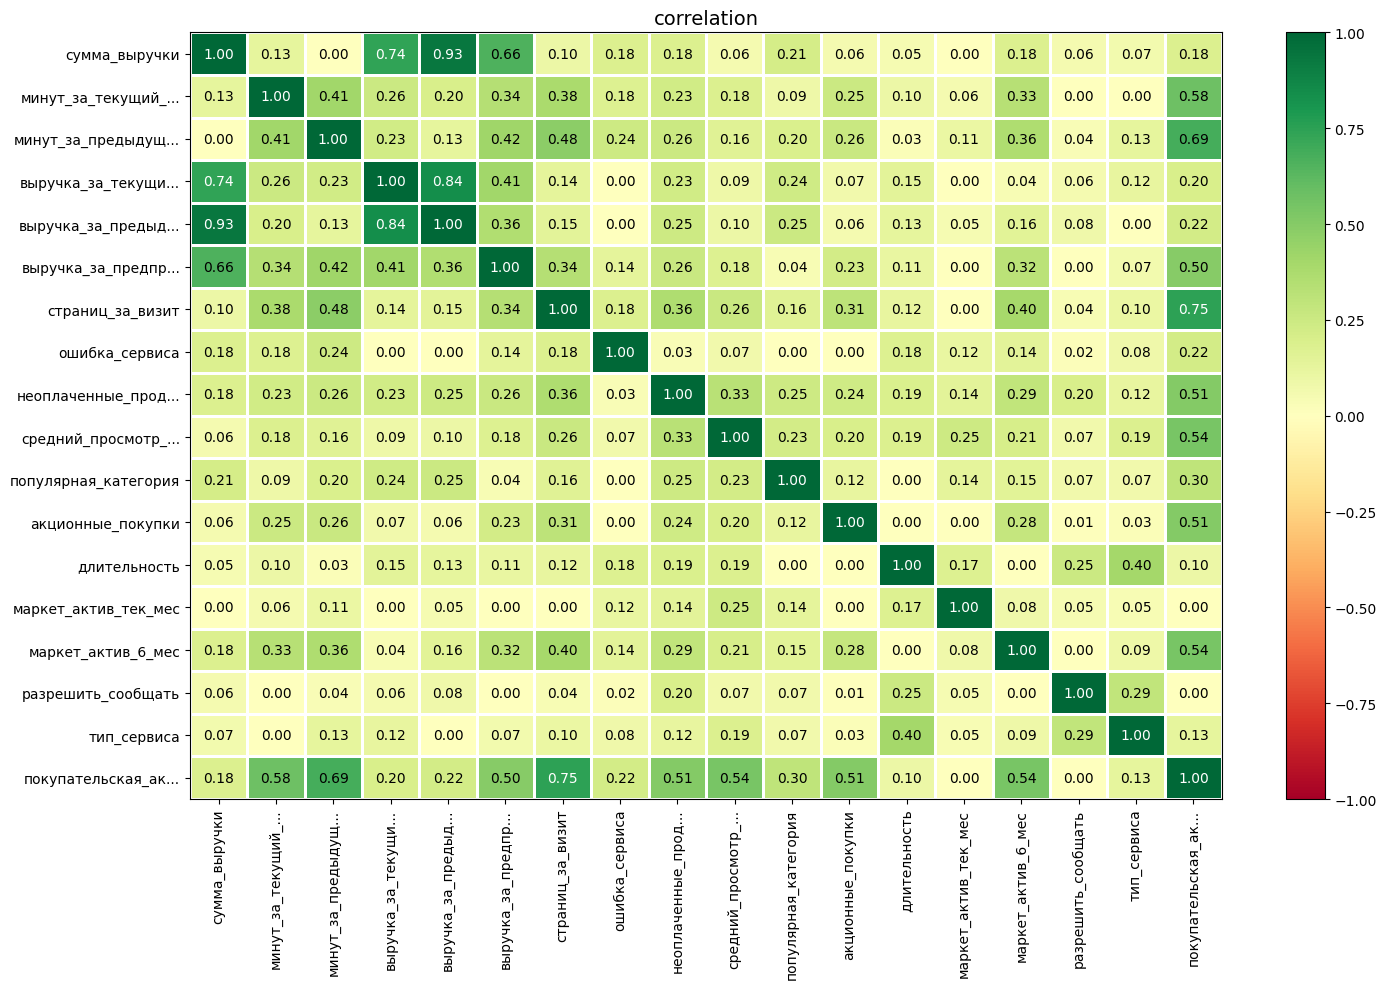

In [322]:
# Создаём phik матрицу
phik_overview = phik_matrix(merged_df, interval_cols=interval_cols)

# Строим график матрицы корреляций phik
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(15, 10)
)

Матрица корреляций Phik также показывает отсутствие мультиколлинеарности между признаками.

#### Шаг 5.2 Вывод

Был проведён корреляционый анализ количественных признаков: построена тепловая карта матрицы корреляций Пирсона. Мультиколлинеарность между признаками не была обнаружена.

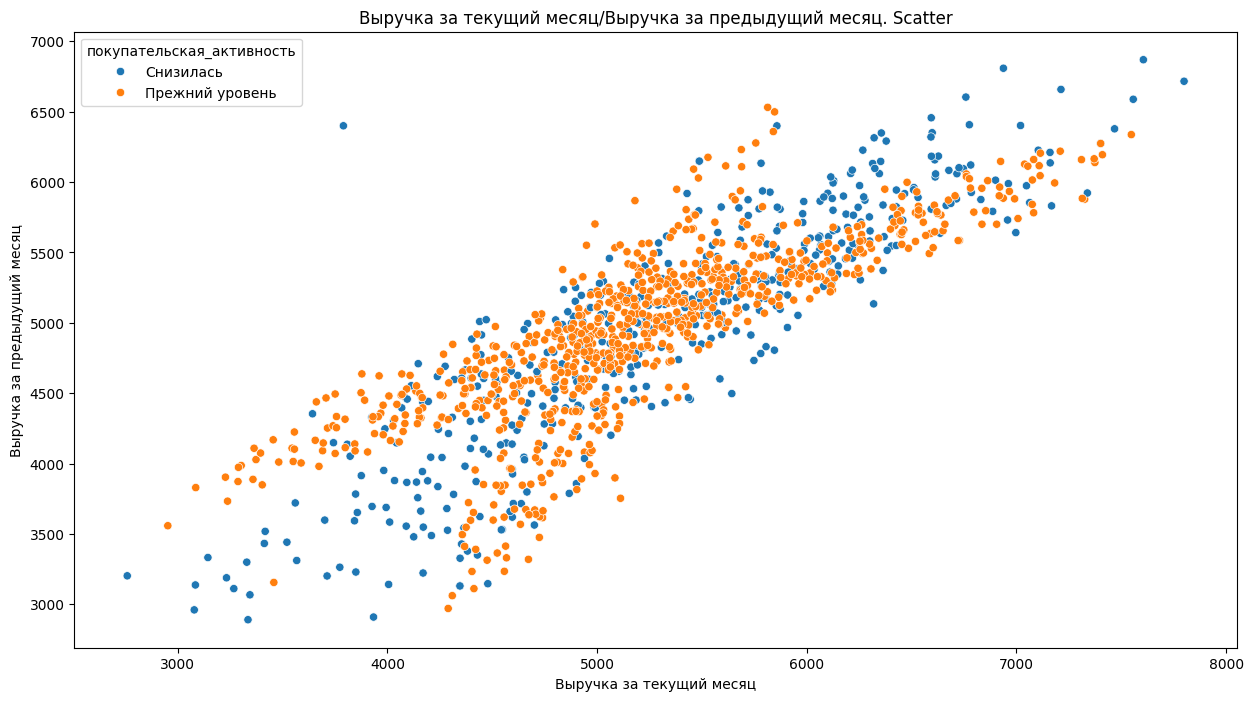

In [323]:
create_scatter(merged_df, 'выручка_за_текущий_месяц', 'выручка_за_предыдущий_месяц')

Видим, что у класса "Прежний уровень" точки выстроены по двум прямым. У класса "Снизилась" просто можно увидеть линейную зависимость: с увеличением выручки за предыдущий месяц растёт выручка и в текущем.

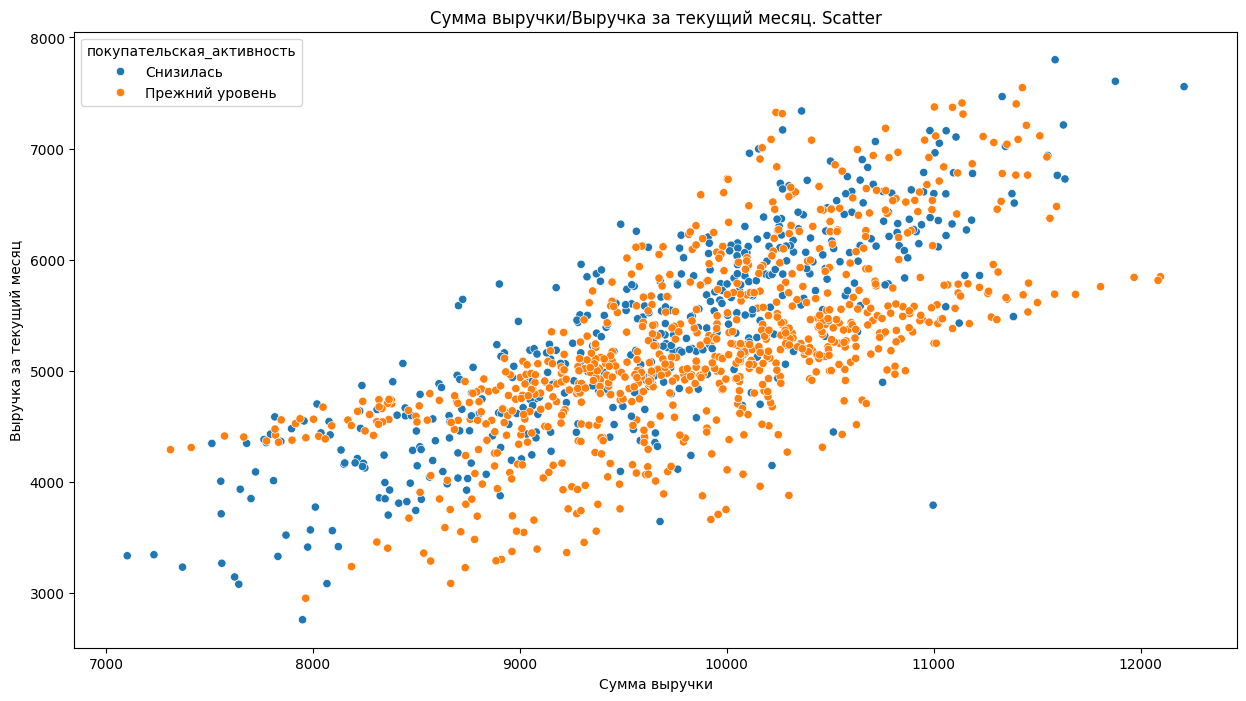

In [324]:
create_scatter(merged_df, 'сумма_выручки', 'выручка_за_текущий_месяц')

Видим довольно-таки выраженную линейную зависимост между суммой выручки за предпредыдущий и предыдущий месяцы и выручкой за текущий месяц.

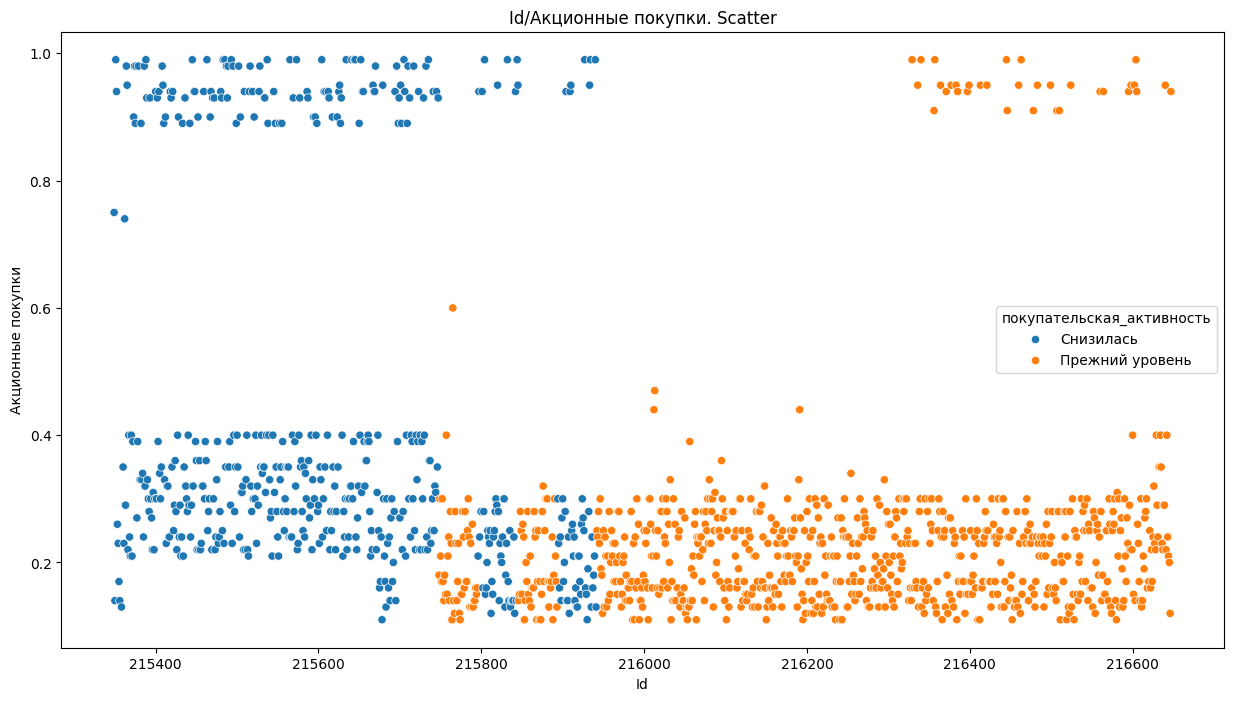

In [325]:
create_scatter(merged_df, 'id', 'акционные_покупки')

Пользователи в таблице сгруппированы по id с учётом покупательской активности: более низкие id — пониженная покупательская активность, более высокие — прежний уровень.

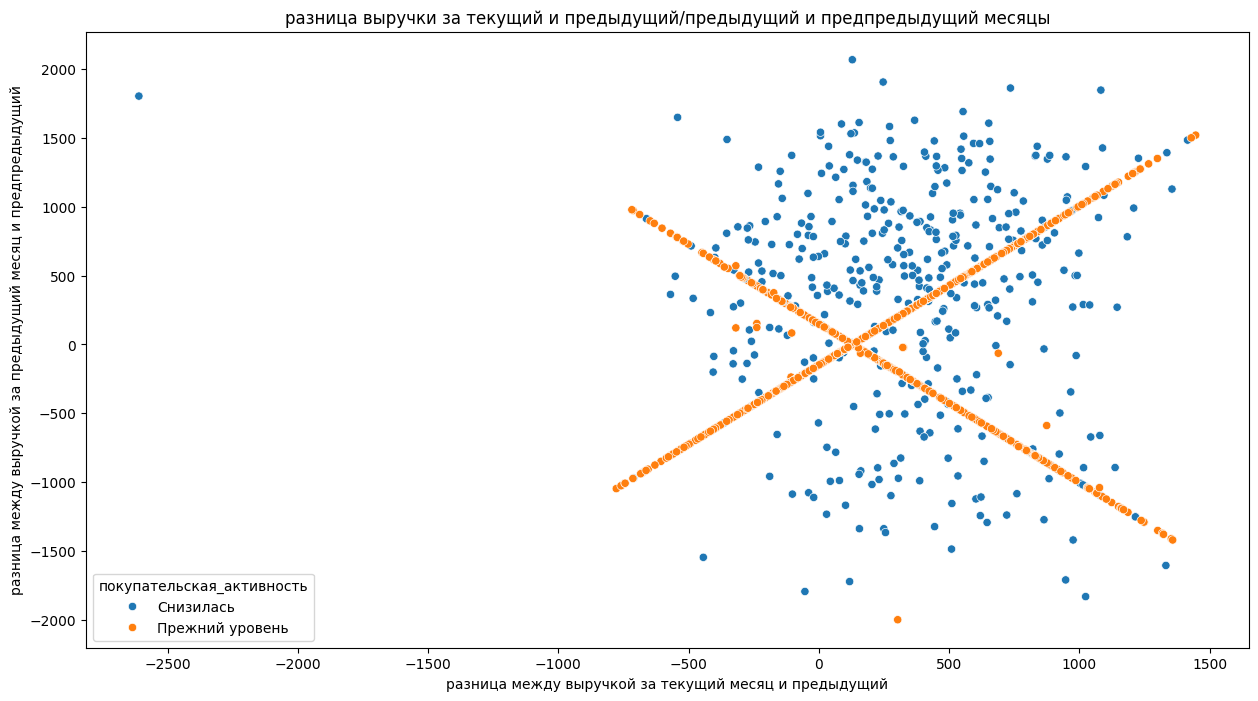

In [326]:
# Вычисляем разницу между выручкой за текущий и предыдущий месяцы
merged_df['разница_1'] = merged_df['выручка_за_текущий_месяц'] - merged_df['выручка_за_предыдущий_месяц']
# Вычисляем разницу между выручкой за предыдущий и предпредыдущий месяцы
merged_df['разница_2'] = merged_df['выручка_за_предыдущий_месяц'] - merged_df['выручка_за_предпредыдущий_месяц']

plt.figure(figsize=(15, 8))
sns.scatterplot(data=merged_df, x='разница_1', y='разница_2', hue='покупательская_активность')
plt.xlabel('разница между выручкой за текущий месяц и предыдущий')
plt.ylabel('разница между выручкой за предыдущий месяц и предпредыдущий')
plt.title(f'разница выручки за текущий и предыдущий/предыдущий и предпредыдущий месяцы')
plt.show()

Можно увидеть, что у класса с прежним уровнем пользовательской активности точки образуют крест. Это говорит о выраженном линейном соотношении между разностью выручки за текущий и предыдущий месяц и разностью выручки за предыдущий и предпредыдущий месяц.

Не будем использовать признак `выручка_за_предыдущий_месяц` при обучении моделей, чтобы избежать мультиколлинеарности.

## Шаг 6. Использование пайплайнов

#### Шаг 6.1 Проверка на дисбаланс классов

Выведем на экран соотношение классов целевого признака `Покупательская активность`.

Прежний уровень    802
Снизилась          494
Name: покупательская_активность, dtype: int64

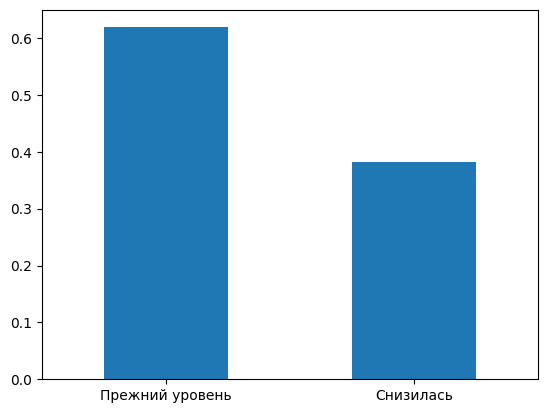

In [327]:
display(merged_df['покупательская_активность'].value_counts())

merged_df['покупательская_активность'].value_counts(normalize=True).plot(kind='bar', rot=0);

В датафрейме содержится 802 наблюдения класса `Прежний уровень` и 494 класса `Снизилась`, что даёт распределение классов примерно 0.62 к 0.38. Это указывает на умеренный дисбаланс. При разбиении на тренировочную и тестовую выборки применим стратификацию, чтобы пропорции классов в тренировочной и тестовой выборке были одинаковыми.

#### Шаг 6.2 Создание пайплайна

Создадим пайплайн, который будет состоять из нескольких пайплайнов:
1. Пайплайн с заполнением пропусков и OHE-кодированием категориальных признаков.
2. Пайплайн с заполнением пропусков и Ordinal-кодированием категориальных признаков.
3. Общий пайплайн для подготовки данных.
4. Итоговый пайплайн.

Для начала разобьём данные на тренировочную и тестовую выборки. Не будем использовать признак `выручка_за_предыдущий_месяц`, так как он сильно коррелирует с признаком `выручка_за_текущий_месяц`.

In [328]:
model_df = merged_df.drop('выручка_за_предыдущий_месяц', axis=1).copy()

# Разбиваем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    model_df.drop('покупательская_активность', axis=1),
    model_df['покупательская_активность'],
    random_state = RANDOM_STATE,
    stratify = model_df['покупательская_активность']
)

Закодируем целевой признак с помощью LabelEncoder. LabelEncoder кодирует в легксикографическом порядке, значит "Прежний уровень" будет классом 0, а "Снизилась" классом 1, однако выполним проверку, чтобы быть уверенными.

In [329]:
# Создаём экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# Обучаем модель и трансформируем тренировочную выборку
y_train = label_encoder.fit_transform(y_train)
# Трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)

# Задаём список закодированных класов
pred_classes = [0, 1]

encoded_classes = pd.DataFrame({
    'оригинал': label_encoder.inverse_transform(pred_classes), # оригинальный класс
    'закодировано': pred_classes # закодированный класс
})
# Выводим на экран для проверки
encoded_classes

оригинал  закодировано
0  Прежний уровень             0
1        Снизилась             1

Проверка показывает, что "Прежний уровень" точно закодировано как 0, а "Снизилась" как 1.

Создадим списки с названиями признаков для OneHotEncoder, OrdinalEncoder, а также список с названиями количественных признаков.

In [330]:
# Создаём список с названиями признаков для OHE
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
# Создаём список с названием признакоа для OrdinalEncoder
ord_columns = ['тип_сервиса']
# Задаём список столбцов с названиями количественных признаков
num_columns = [col for col in model_df.select_dtypes(include='number').columns]

Создадим пайплайн.

In [331]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns: Ordinal-кодирование
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['стандарт', 'премиум']
            ],
            handle_unknown='use_encoded_value',
            unknown_value=np.nan
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)

# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough',
)

# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#### Шаг 6.3 Использование GridSearchCV

Для поиска лучшей модели исползуем `GridSearchCV`, чтобы протестировать несколько моделей с разными гиперпараметрами. Для этого создадим словарь `param_grid`.

При обучении логистической регрессии и SVC для учёта дисбаланса классов будем использовать параметр `class_weight='balanced'`.

Задача состоит в предсказании вероятности снижения покупательской активности. На первый взгляд, может показаться, что нужно минимизировать ложноотрицательные ошибки FN, чтобы не пропустить случаи снижения активности. Однако минимизация FN за счёт увеличения ошибок FP (ложноположительных) нас не устраивает, так как ошибочное предсказание снижения активности для пользователей с прежним уровнем приведёт к лишним затратам на стимулирование.

Поэтому в качестве метрики качества возьмём `ROC-AUC`, которая позволяет оценить модель независимо от порога классификации и учитывает дисбаланс классов, где объектов класса `Прежний уровень` больше, чем класса `Снизилась`.

In [332]:
# Создаём словарь гиперпараметров
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(probability=True, kernel='rbf', class_weight='balanced')],
        'models__C': np.arange(0.1, 2, 0.1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

]

# Создаём список с названиями метрик
metrics = ['accuracy', 'average_precision', 'roc_auc']

# Ищем лучшую модель
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring=metrics,
    n_jobs=-1,
    verbose=3,
    refit='roc_auc'
)

# Время старта
start = time.time()
# Перебираем все модели и варианты масштабирования
grid.fit(X_train, y_train)
# Время окончания
end = time.time()
# Выводим на экран время выполнения
print(f"\nВремя выполнения GridSearchCV: {end - start:.2f} секунд", end='\n\n')

# Создаём датафрейм с результатами работы GridSearchCV
results = pd.DataFrame(grid.cv_results_)

# Выводим на экран лучшую модель и её параметры
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_, end='\n\n')

# Распечатываем метрики лучшей модели
for metric in metrics:
    print(f'Метрика {metric} лучшей модели:', end='')
    print(results.iloc[grid.best_index_, :][f'mean_test_{metric}'])

Fitting 5 folds for each of 336 candidates, totalling 1680 fits

Время выполнения GridSearchCV: 3.40 секунд

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                              

Лучшей моделью оказалась модель `SVC` с параметром C = 0.5. Выведем на экран лучшие метрики для каждой модели для сравнения.

In [333]:
# Добавим имя модели как строку, чтобы было удобно группировать
results['model_name'] = results['param_models'].astype(str).str.extract(r'^(\w+)')
best_models_idxs = results.groupby('model_name')['mean_test_roc_auc'].idxmax()
# Группируем по имени модели и берём лучший результат по mean_test_roc_auc
best_by_model = results.loc[best_models_idxs, ['model_name', 'mean_test_roc_auc', 'mean_score_time']].sort_values(by='mean_test_roc_auc', ascending=False)

# Выводим на экран лучшие метрики всех моделей
display(best_by_model)
# Выводим на экран полные параметры лучшей модели
display(grid.best_params_)

model_name  mean_test_roc_auc  mean_score_time
291                     SVC           0.912592         0.033265
267    KNeighborsClassifier           0.907098         0.021544
66   DecisionTreeClassifier           0.840357         0.014734

{'models': SVC(class_weight='balanced', probability=True),
 'models__C': 0.5,
 'preprocessor__num': StandardScaler()}

Можно увидеть, что `SVC` с параметром `C` = 0.5, а также скейлером `StandardScaler` довольно-таки сильно отрывается от остальных моделей по метрике `ROC-AUC`. Однако, если посмотреть на среднее время пронгозирования, то у модели SVC оно самое большое — 0.031. К примеру, у KNN время равно 0.02, у логистической регрессии = 0.018. На имеющемся датафрейме разница во времени прогнозирования несущественная, однако, если будет стоять задача сделать прогноз на датафрейме с гораздо большим количеством строк, модель с меньшим средним временем прогнозирования может быть предпочтительнее, если есть возможность немного пожертвовать метрикой.

Выполним предсказания на тестовых данных, используя модель, а также выведем метрику ROC-AUC.

In [334]:
# Выполняем предсказания на тестовых данных
y_test_pred_proba = grid.predict_proba(X_test)[:, 1]
print(f'Метрика лучшей модели на тестовой выборке:', round(roc_auc_score(y_test, y_test_pred_proba), 3))

Метрика лучшей модели на тестовой выборке: 0.918


In [335]:
# Создаём массив порогов от 0.0 до 1.0
thresholds = np.linspace(0.0, 1.0, num=101)
best_score = -1
best_threshold = 0.5

results = []

for threshold in thresholds:
    # Предсказываем классы с текущим порогом
    y_test_pred = (y_test_pred_proba >= threshold).astype(int)
    # Сохраняем в переменные верные и неверные предсказания
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()
    # Вычисляем метрики
    precision = precision_score(y_test, y_test_pred , pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_test_pred , pos_label=1, zero_division=0)

    if recall > best_score:
        best_score = recall
        best_threshold = threshold

    # Сохраняем результаты в список
    results.append({
        'threshold': threshold,
        'precision': round(precision, 3),
        'recall': round(recall, 3),
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'tn': tn
    })

# Выводим лучший порог и соответствующую метрику
print(f'Лучший порог = {best_threshold:.3f}, {recall} = {best_score:.3f}')
# Преобразовываем список результатов в DataFrame
thresholds_df = pd.DataFrame(results)

# Выводим верхние 5 строк, где ошибка FP = 0
thresholds_df[thresholds_df['fn'] == 0].head()

Лучший порог = 0.000, 0.0 = 1.000


threshold  precision  recall   fp  fn   tp  tn
0       0.00       0.38     1.0  201   0  123   0
1       0.01       0.38     1.0  201   0  123   0

Показатель метрики `ROC-AUC` на тренировочной выборке был равен 0.912, на тестовой выборке равен 0.914, что свидетельствует о высоком качестве модели. 

Построим Confusion Matrix, чтобыы посмотреть на результаты работы модели.

array([[191,  10],
       [ 22, 101]], dtype=int64)

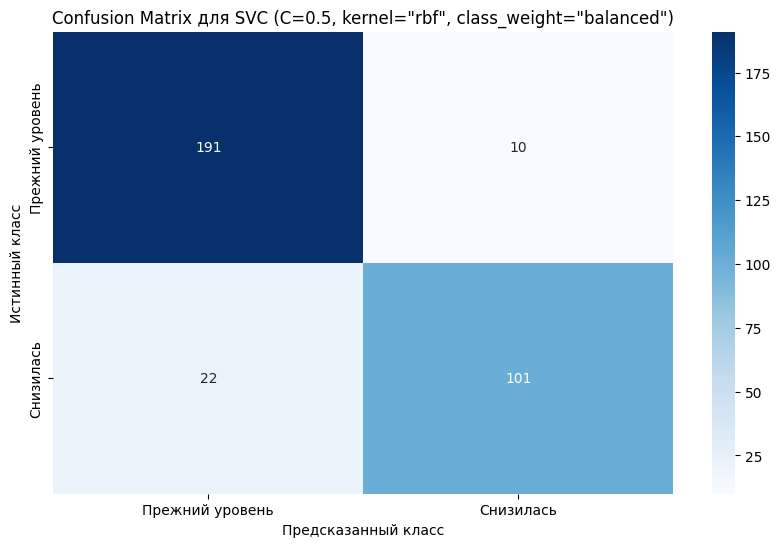

In [336]:
# Рассчитать Confusion Matrix
cm = confusion_matrix(y_test, grid.best_estimator_.predict(X_test), labels=[0, 1])
display(cm)
# Визуализация матрицы
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Прежний уровень', 'Снизилась'], 
            yticklabels=['Прежний уровень', 'Снизилась'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Confusion Matrix для SVC (C=0.5, kernel="rbf", class_weight="balanced")')
plt.show()

Видно, что модель имеет меньше ошибок FP — 5, чем ошибок FN — 22. Это можно объяснить наличием дисбаланса классов, где объектов класса `Прежний уровень` (802) больше, чем класса `Снизилась` (494). В целом, модель демонстрирует хорошую производительность.

#### Шаг 6.4 Вывод

Был создан пайплайн, состоящий из нескольких пайплайнов:
- OHE кодирование
- OrdinalEncoder кодирование
- Общий пайплайн для подготовки данных
- Итоговый пайплайн

Был создан словарь `param_grid` для использования в `GridSearchCV` для поиска лучшей модели.

Лучшей моделью оказалась `SVC` с параметром `C` = 0.5 и скейлером `StandardScaler`. Для неё были выведены метрики `ROC-AUC` на тренировочной и тестовой выборках, а также построена матрица ошибок.

## Шаг 7 Анализ важности признаков

#### Шаг 7.1 Вычисление SHAP-значений для признаков

Оценим важность признаков для лучшей модели (`SVC`) и построим графики важности с помощью метода `SHAP`.

In [337]:
# Инициализируем JS-компонент визуализаций shap
shap.initjs()

# Получаем обученный пайплайн с лучшей моделью из GridSearchCV
best_model = grid.best_estimator_

# Разделяем препроцессор и модель
preprocessor = best_model.named_steps['preprocessor']
svc_model = best_model.named_steps['models']

# Получаем названия признаков после трансформации
feature_names = preprocessor.get_feature_names_out()
# Чистим названия признаков от num__, ohe__
feature_names = [re.sub(r'\w+__', '', name )for name in feature_names]

# Трансформируем обучающую и тестовую выборки
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Создаём KernelExplainer; в качестве data берём 10 кластерных центров из обучающей выборки для ускорения расчёта
explainer = shap.KernelExplainer(
    model=svc_model.predict_proba, 
    data=shap.kmeans(X_train_transformed, k=10), 
    feature_names=feature_names)
# Считаем shap-значения на подвыборке из 50 строк X_test_transformed
shap_values = explainer(X_test_transformed[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

#### Шаг 7.2 Построение графиков

Построим график `beeswarm` из библиотеки `Shap`. Класс 1 — покупательская активность `Снизилась`, класс 0 — покупательская активность `Прежний уровень`.

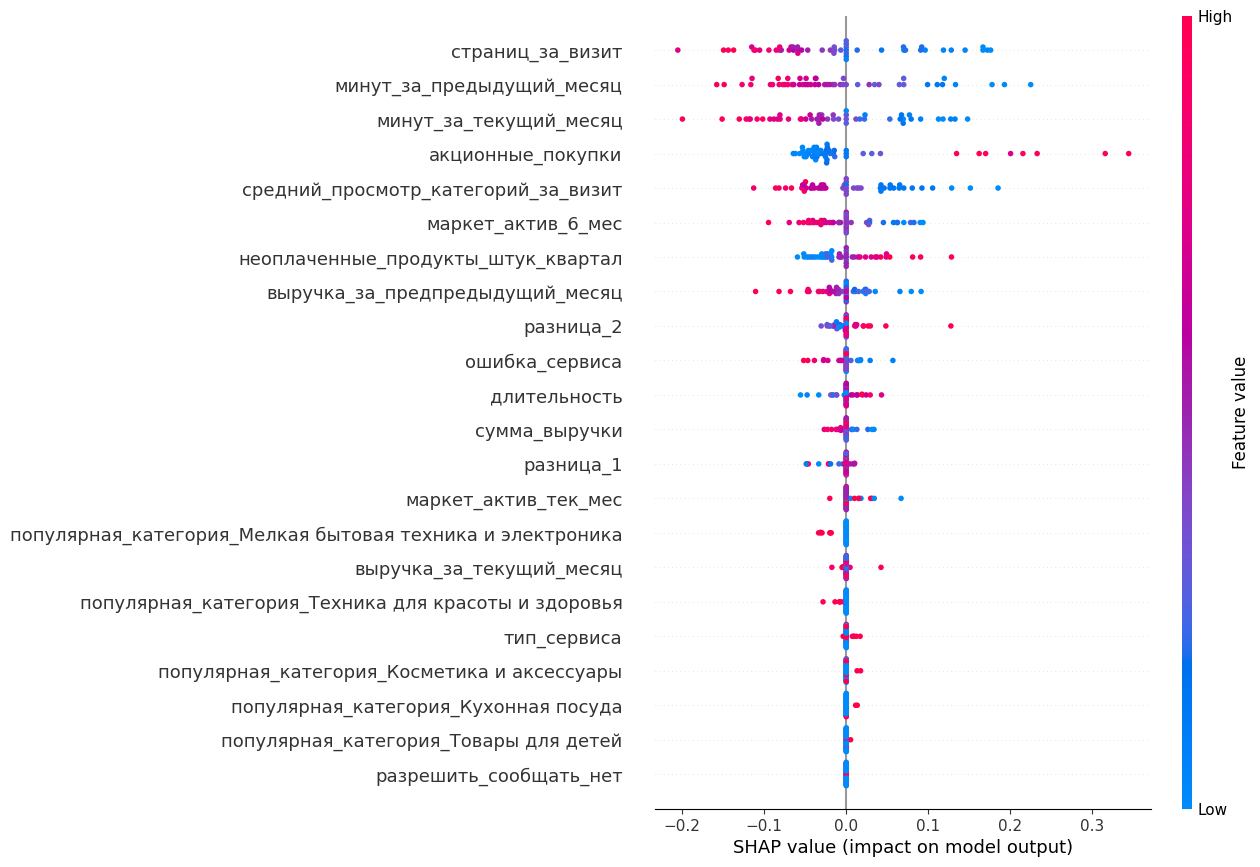

In [338]:
# Строим диаграмма beeswarm для рассчитанных shap-значений
shap.plots.beeswarm(shap_values[:, :, 1], max_display=25)

Признаки, которые сильнее всего влияют на предсказание снижения покупательской активности:
- `страниц_за_визит`, `минут_за_предыдущий_месяц`, `минут_за_текущий_месяц`, `cредний_просмотр_категорий_за_визит`, `маркет_актив_6_мес`, `выручка_за_предпредыдущий_месяц`. У этих признаков низкие значения увеличивают вероятность предсказания класса 1 `Снизилась`, высокие класса 0 `Прежний уровень`.
- `акционные_покупки`, `неоплаченные_продукты_штук_квартал`. У этих признаков низкие значения увеличивают вероятность предсказания класса 0 `Прежний уровень`, а высокие класса 1 `Снизилась`. 

Признаки, которые умеренно влияют на на предсказание снижения покупательской активности:
- `ошибка_сервиса`. Высокие значения увеличивают вероятность предсказания класса 0, низкие — класса 1.
- `длительность`. Высокие значения увеличивают вероятность предсказания класса 0, низкие — класса 1. Это говорит о том, что чем дольше пользователь зарегистрирован, тем вероятнее у него будет пониженная покупательская активность.

- `маркет_актив_тек_мес`, `выручка_за_текущий_месяц`. У этих признаков в основном низкие значения увеличивают предсказание класса 1 `Снизилась`, а низкие класса 0, однако можно заметить, что некоторые высокие значения увеличивают вероятность предсказания класса 1. Это может быть связано с тем, что эти признаки по-разному влияют в разных группах данных.
- `популярная_категория_Мелкая бытовая техника и электроника` высокие shap-значения увеличивают вероятность предсказания класса 0 `Прежний уровень`.

Признаки, которые слабее всего влияют на предсказание снижения покупательской активности:
1. Популярные категории: "Товары для детей", "Кухонная посуда", "Косметика и аксессуары" и "Техника для красоты и здоровья" не оказывают значительного влияния на предсказание модели.
2. `тип_сервиса` — уровень сервиса также почти не оказывает влияния на предсказание.
3. `разрешить_сообщать_нет` — разрешение присылать покупателю дополнительные предложения о товаре меньше всего влияет на предсказание модели.

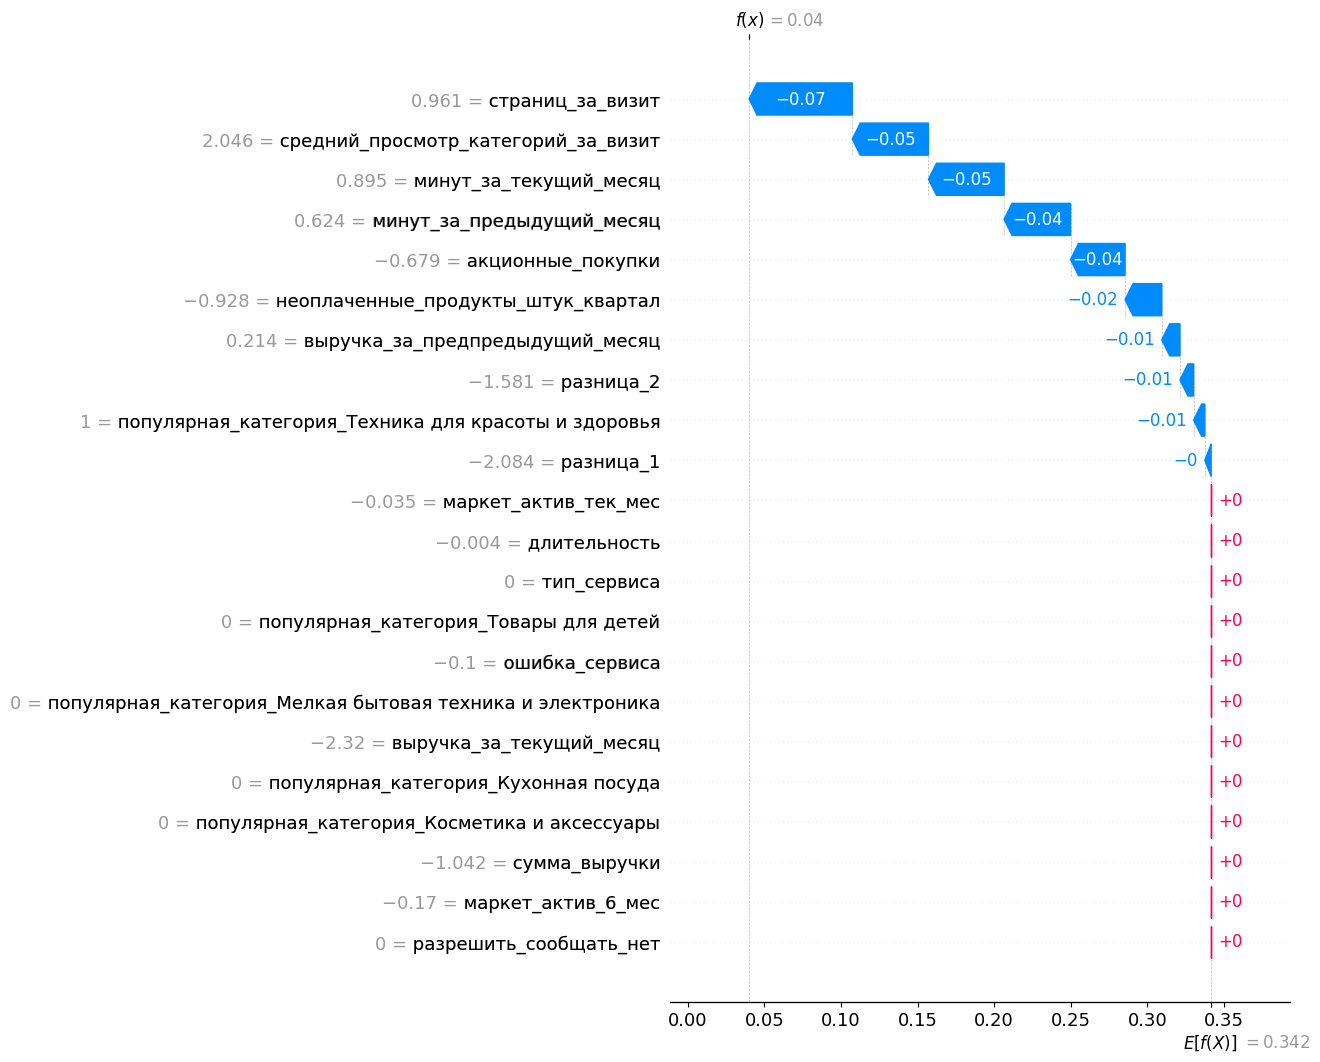

In [339]:
# Строим график waterfall для первого объекта класса 1 "Снизилась" в выборке
shap.plots.waterfall(shap_values[:, :, 1][0], max_display=25)

График показывает, что для выбранного объекта большинство признаков либо снижают вероятность класса 1, либо не оказывают никакого влияния. Несмотря на это, снижение вероятности не достаточно значительно, чтобы отнести объект к классу 0 ("Прежний уровень"), и финальное предсказание остаётся ближе к классу 1.

Для сравнения, построим график `waterfall` для следующего объекта.

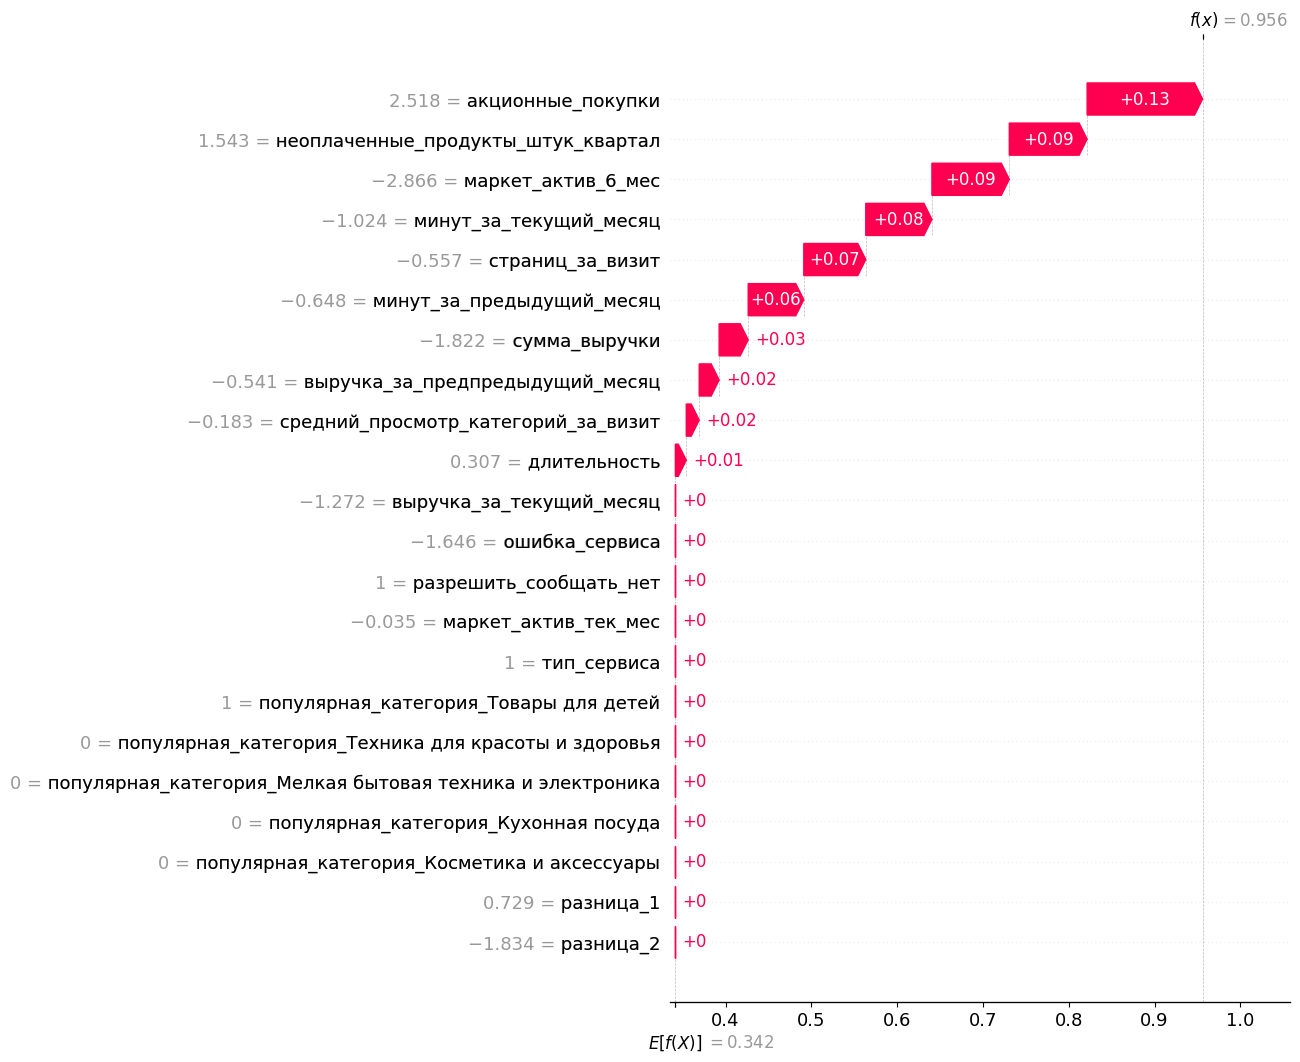

In [340]:
# Строим график waterfall для первого объекта класса 1 "Снизилась" в выборке
shap.plots.waterfall(shap_values[:, :, 1][1], max_display=25)

Здесь мы видим противоположную картину: все признаки, которые оказывают влияние на предсказание модели, повышают вероятность класса 1 "Снизилась".

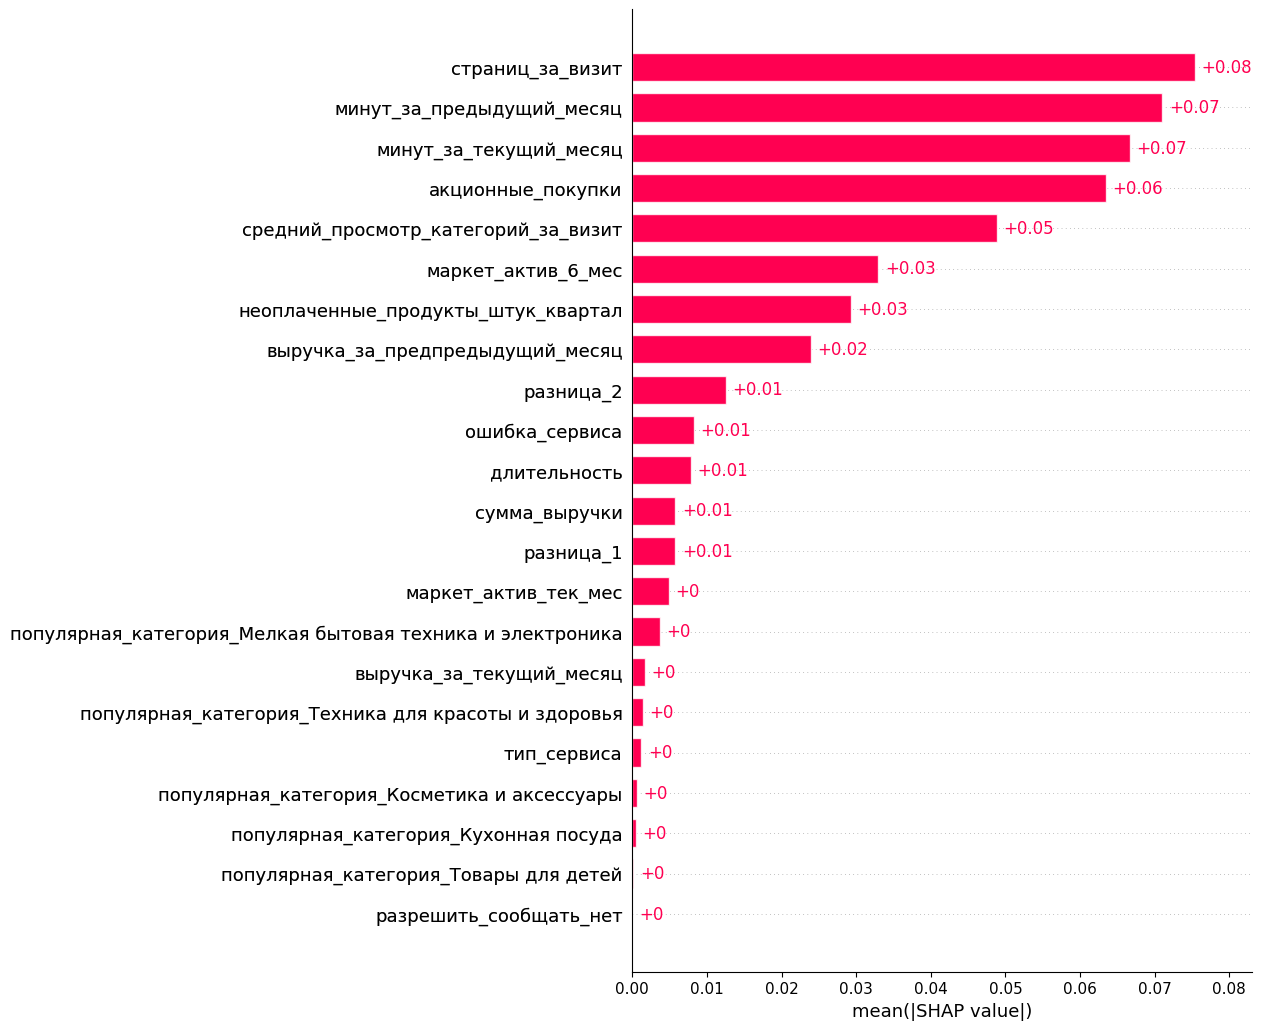

In [341]:
shap.plots.bar(shap_values[:, :, 1], max_display=25)

Данный график показывает средние SHAP-значения по каждому признаку. Самый большой вес у признака `страниц_за_визит`, он оказывает самое сильное влияние на прогнозы.

#### Шаг 7.3 Вывод

Анализ SHAP-значений показал, что ля прогноза активности являются наиболее важны признаки, связанные с количеством просмотренных страниц за визит на сайт (`страниц_за_визит`), акционными покупками (`акционные_покупки`), а также временем, проведённым на сайте. (`минут_за_текущий_месяц` и `минут_за_предыдущий_месяц`).

Для удержания покупателей стоит усилить маркетинговые усилия: продумать разнообразные акционные предложения, чтобы стимулировать покупки, возможно, изменить дизайн, а также улучшить удобство сайта, чтобы пользователи проводили на нём больше времени. Также важно напоминать о неоплаченных товарах в корзине, например, предлагая на них скидки или персонализированные уведомления, что может мотивировать к совершению покупки.

## Шаг 8. Сегментация покупателей

#### Шаг 8.1 Выполнение сегментации

Для анализа возьмём группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Класс 0 — `Прежний уровень`, класс 1 — `Снизилась`.

In [342]:
# Добавляем вероятности снижения активности в датафрейм с объединенными таблицами
merged_df['вероятность_снижения_активности'] = grid.predict_proba(merged_df.drop(columns=['покупательская_активность']))[:, 1]

# Объединяем с датафреймом money_df
segment_df = merged_df.merge(money_df, on='id', how='left').drop(columns=['покупательская_активность'])

# Оставляем только пользователей с наиболее высокой прибыльностью
segment_df = segment_df[segment_df['прибыль'] > segment_df['прибыль'].mean()]

# Создаём флаг с уровнем риска
segment_df['риск_снижения_активности'] = np.where(
    segment_df['вероятность_снижения_активности'] >= 0.75,
    'Высокий',
    'Низкий'
)

# Выводим на экран для проверки
segment_df.head()

id тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
0  215349     премиум                 да                 4.4   
2  215351    стандарт                 да                 3.2   
3  215352    стандарт                нет                 5.1   
6  215355    стандарт                нет                 4.7   
7  215356    стандарт                 да                 4.2   

   маркет_актив_тек_мес  длительность  акционные_покупки  \
0                     4           819               0.75   
2                     5           896               0.99   
3                     3          1064               0.94   
6                     4           284               0.17   
7                     4           192               0.14   

     популярная_категория  средний_просмотр_категорий_за_визит  \
0        Товары для детей                                    4   
2        Товары для детей                                    5   
3        Товары для детей                                    3   
6        Товары для детей                                    5   
7  Косметика и аксессуары                                    2   

   неоплаченные_продукты_штук_квартал  ...  выручка_за_предыдущий_месяц  \
0                                   4  ...                       5216.0   
2                                   0  ...                       6158.0   
3                                   2  ...                       5807.5   
6                                   1  ...                       3263.0   
7                                   2  ...                       4146.5   

   выручка_за_текущий_месяц  минут_за_предыдущий_месяц  \
0                    4971.6                         12   
2                    6610.4                         11   
3                    5872.5                          8   
6                    3772.6                         12   
7                    4566.4                          6   

   минут_за_текущий_месяц  сумма_выручки  разница_1  разница_2  \
0                      10         9688.0     -244.4      744.0   
2                      13        10951.0      452.4     1365.0   
3                      11        10401.5       65.0     1213.5   
6                      10         8012.0      509.6    -1486.0   
7                       7         8579.5      419.9     -286.5   

   вероятность_снижения_активности  прибыль  риск_снижения_активности  
0                         0.956734     4.16                   Высокий  
2                         0.823401     4.87                   Высокий  
3                         0.933173     4.21                   Высокий  
6                         0.415870     5.26                    Низкий  
7                         0.971411     4.93                   Высокий  

[5 rows x 23 columns]

#### Шаг 8.2 Выявление признаков для анализа по матрице корреляций PHIK

Построим матрицу корреляций Phik для обнаружения коррелирующих признаков с признаком `вероятность_снижения_активности`.

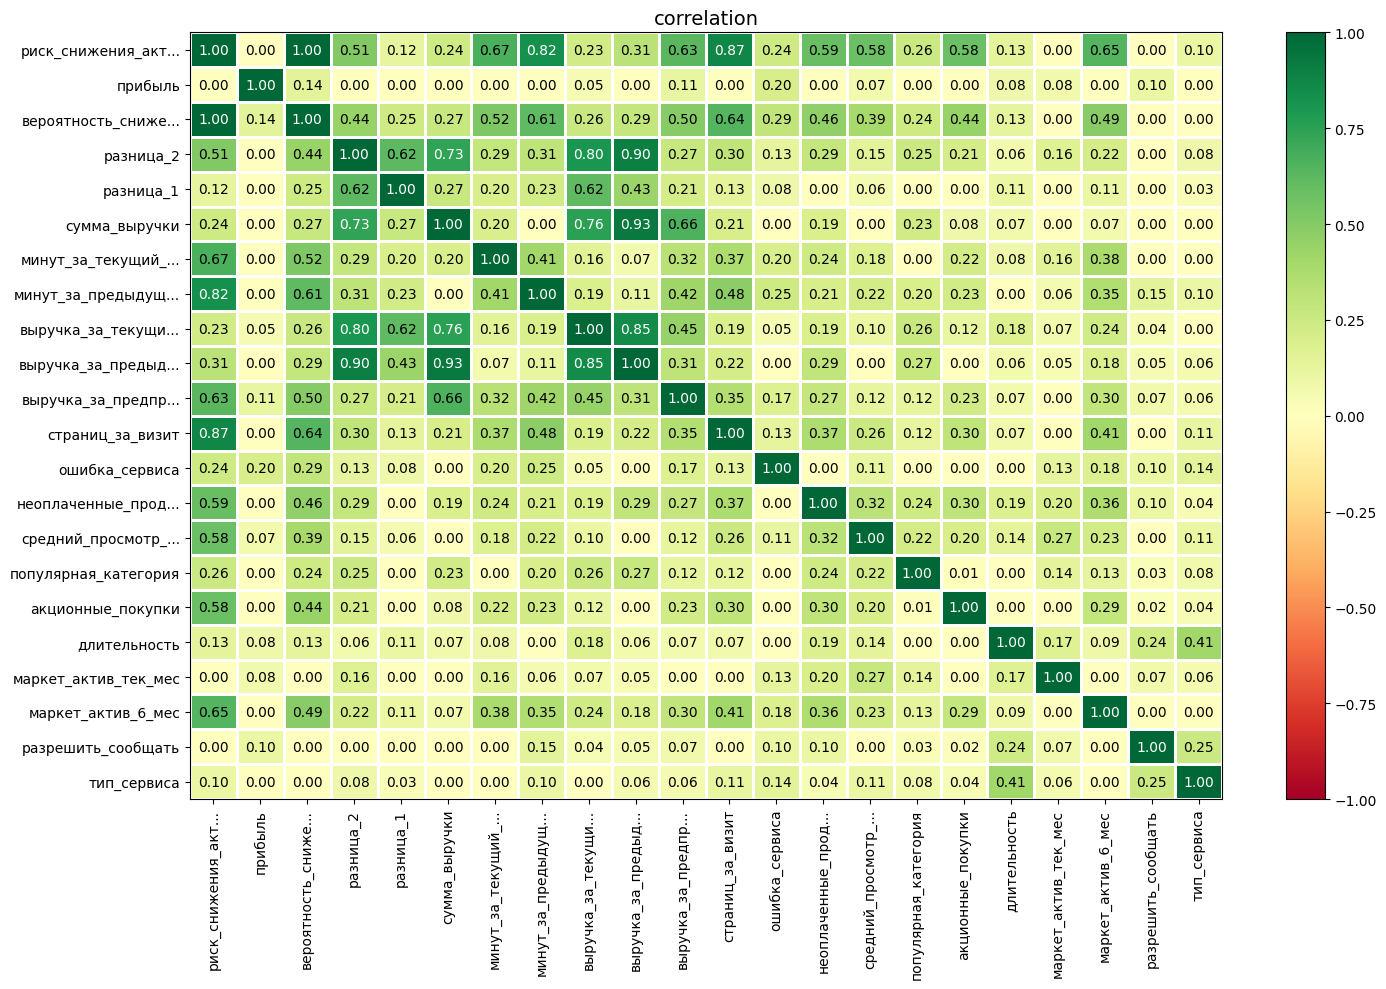

In [343]:
# Выделяем количественные признаки
interval_cols = segment_df.select_dtypes(include='number').columns.tolist()
# Создаём phik матрицу
phik_overview = phik_matrix(segment_df.drop(columns='id'), interval_cols=interval_cols)

# Строим график матрицы корреляций phik
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(15, 10)
) 

Больше всего коррелируют признаки: `минут_за_текущий_месяц`, `минут_за_предыдущий_месяц`, `страниц_за_визит`, `неоплаченные_продукты_штук_квартал`, `средний_просмотр_категорий_за_визит`, `акционные_покупки`, `маркет_актив_6_мес`.

#### Шаг 8.3 Построение графиков

Построим графики `create_barplot` с разделением на группы риска (Высокий или Низкий) для этих признаков и вероятности снижения активности.

Напишем функцию для построения графиков barplot, где hue=`риск_снижения_активности`.

In [344]:
def create_barplot(df, x_column):
    """
    Строит график scatter
    """
    plt.figure(figsize=(12, 6))
    hue_column = 'риск_снижения_активности'
    sns.barplot(data=df, x=x_column,
                    hue=hue_column)
    title = x_column.capitalize().replace('_', ' ')
    plt.title(f'{title}. Barplot')
    plt.xlabel(title)
    plt.legend(title=hue_column.capitalize().replace('_', ' '))
    plt.show()

Можно увидеть, что пользователи сегмента с низким риском снижения активности больше времени проводят на сайте.

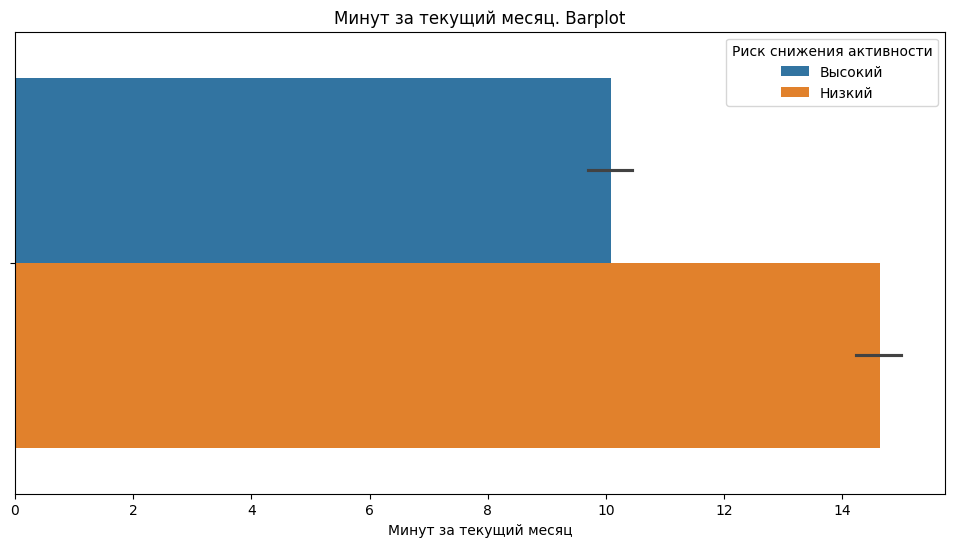

In [345]:
# Используем созданную функцию
create_barplot(segment_df, 'минут_за_текущий_месяц')

Пользователи сегмента с низким риском снижения активности в среднем просматривают больше страниц за визит на сайт.

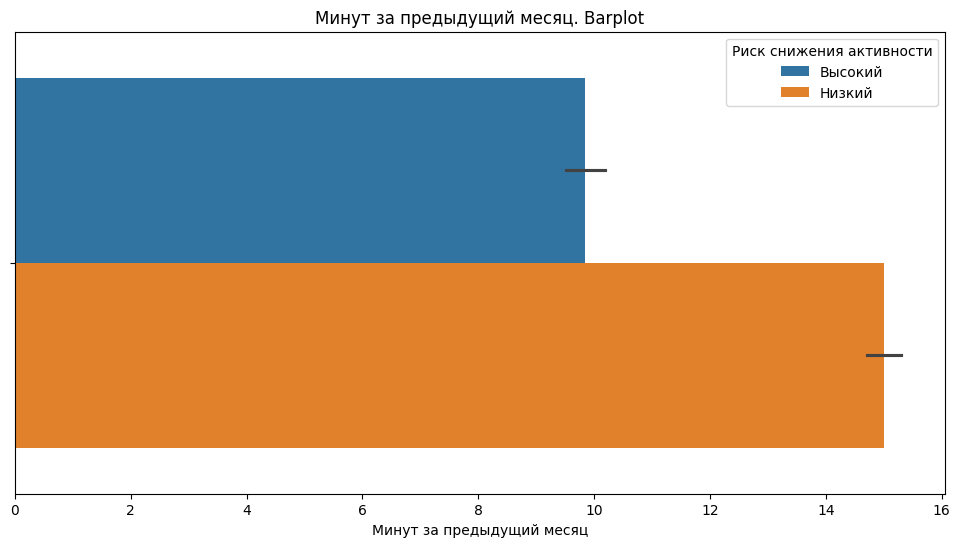

In [346]:
# Используем созданную функцию
create_barplot(segment_df, 'минут_за_предыдущий_месяц')

Ситуация такая же, как и с количеством страниц за визит: пользователи с низким риском снижения активности в среднем проводят больше времени на сайте.

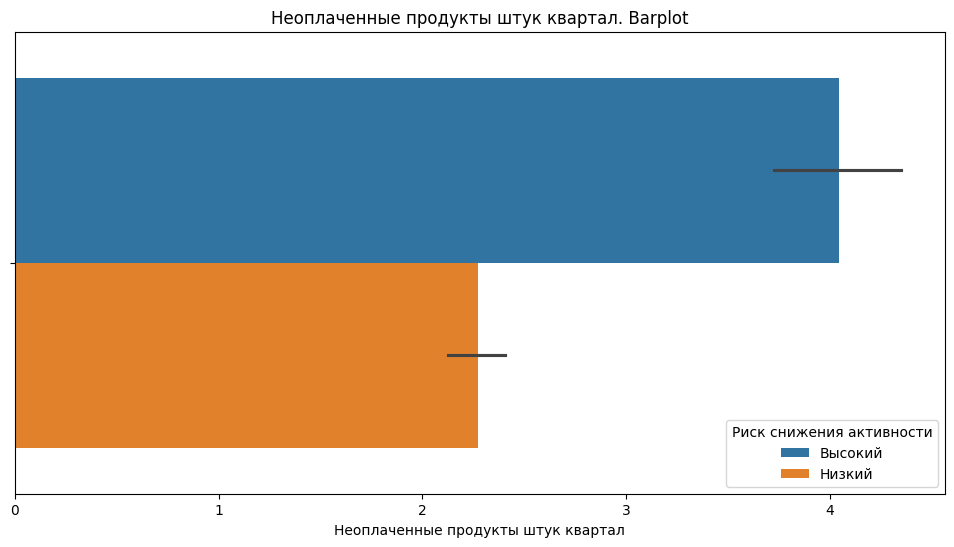

In [347]:
# Используем созданную функцию
create_barplot(segment_df, 'неоплаченные_продукты_штук_квартал')

У пользователей с высоким риском снижения активности в среднем больше неоплаченных товаров в корзине за квартал.

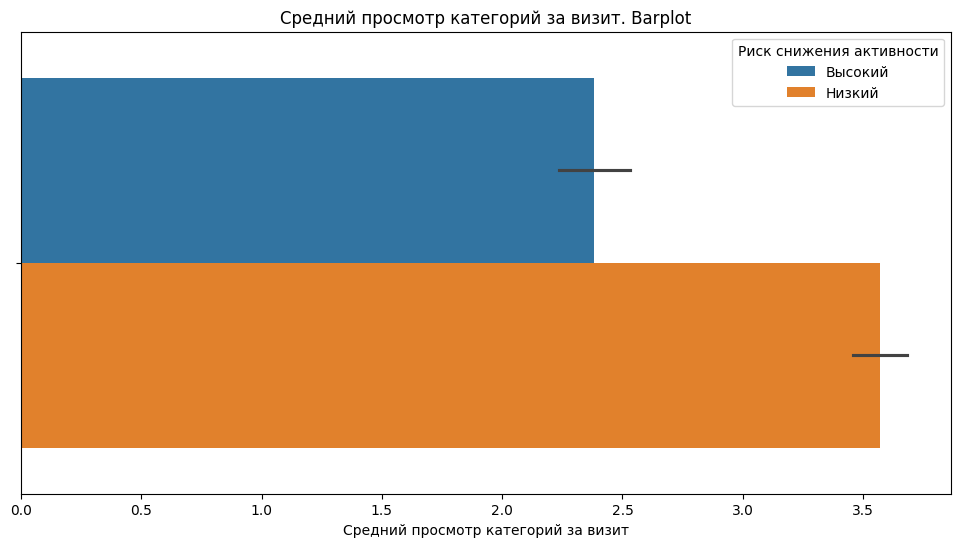

In [348]:
# Используем созданную функцию
create_barplot(segment_df, 'средний_просмотр_категорий_за_визит')

Пользователи с высоким риском снижения активности в среднем просматривают 2.3 категории за визит на сайт, а с низким уровнем — чуть больше 3.5.

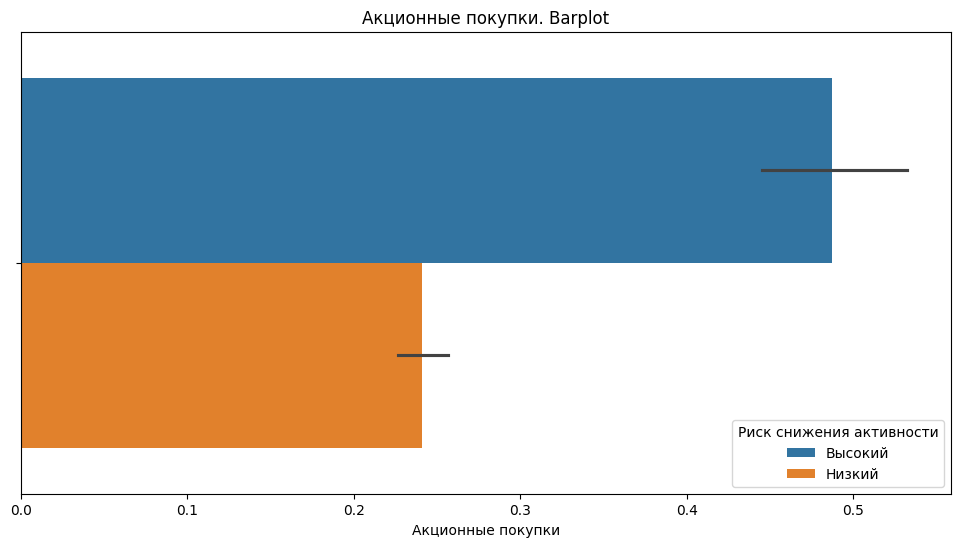

In [349]:
# Используем созданную функцию
create_barplot(segment_df, 'акционные_покупки')

Можно увидеть, что пользователи с высоким риском снижения активности в среднем делают больше покупок по акциям.

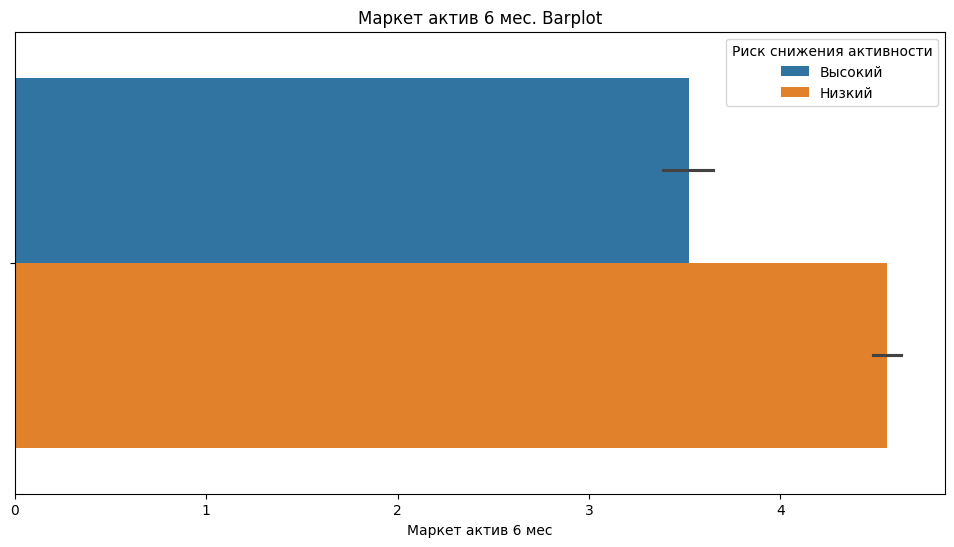

In [350]:
# Используем созданную функцию
create_barplot(segment_df, 'маркет_актив_6_мес')

Пользователи с низким уровнем снижения активности в среднем за 6 месяцев получали больше маркетинговых коммуникаций, чем пользователи с высоким уровнем снижения активности.

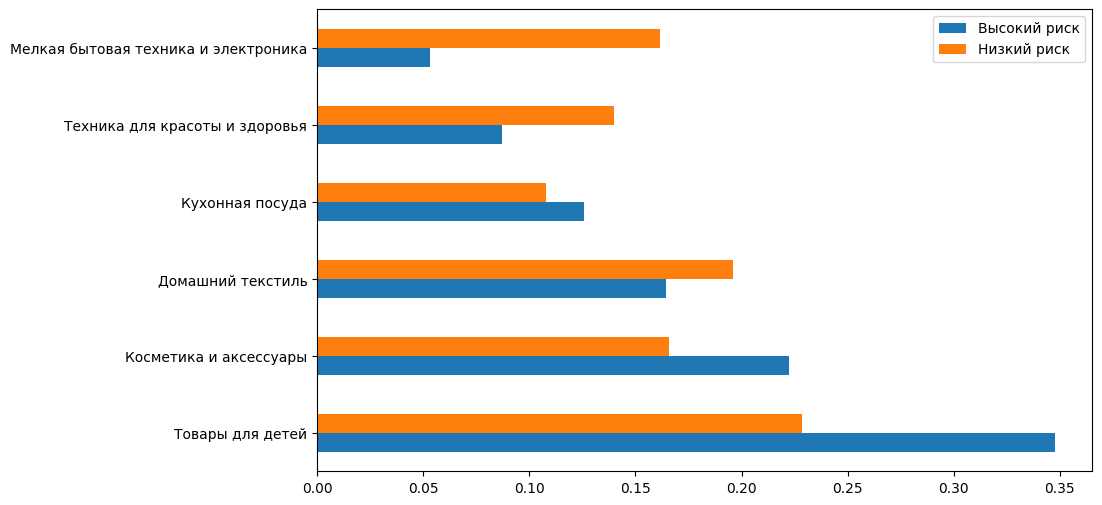

In [351]:
# Считаем вхождения по категориям для каждой группы
high_risk = segment_df[segment_df['риск_снижения_активности'] == 'Высокий']['популярная_категория'].value_counts(normalize=True)
low_risk = segment_df[segment_df['риск_снижения_активности'] == 'Низкий']['популярная_категория'].value_counts(normalize=True)

# Объединяем в один датафрейм
comparison_df = pd.concat([high_risk, low_risk], axis=1, keys=['Высокий риск', 'Низкий риск'])

# Строим горизонтальный barplot
comparison_df.plot(kind='barh', figsize=(10, 6), legend='Риск снижения активности');

Можно увидеть, что у пользователей с наиболее высокой прибыльностью и высоким риском снижения покупательской активности самыми популярными категориями являются «Товары для детей» и «Косметика и аксессуары». Эти категории встречаются значительно чаще, чем у стабильных клиентов (доли нормализованы для учёта разного размера групп). Для удержания клиентов с высоким риском снижения покупательской активности стоит сфокусировать основное внимания маркетинговых коммуникаций на этих категориях.

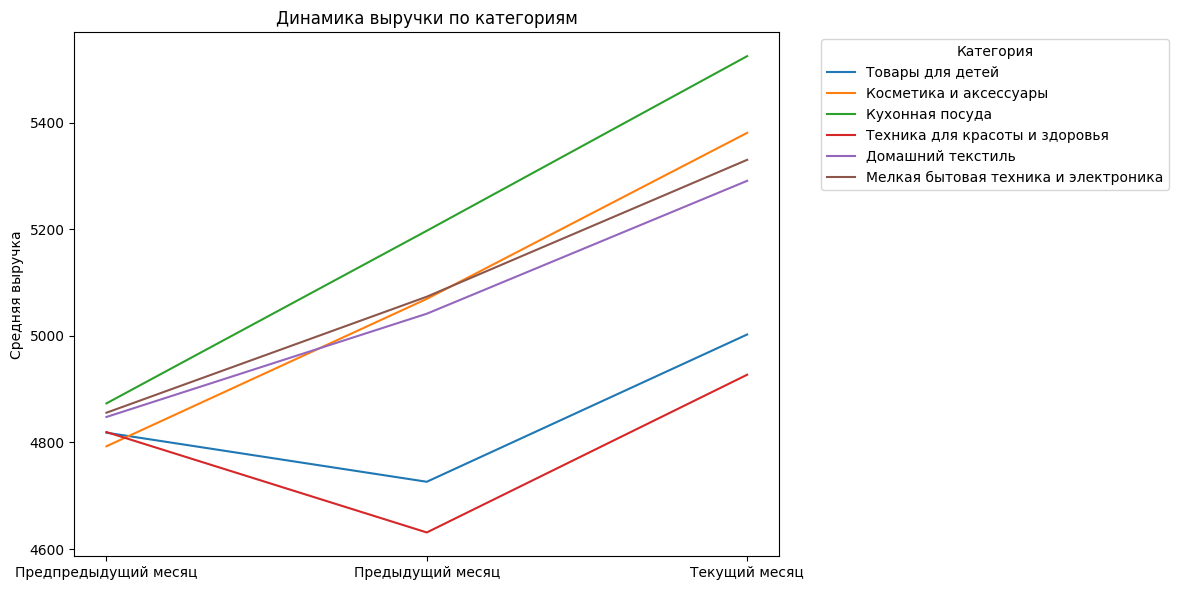

In [352]:
# Преобразуем данные в длинный формат
df_melted = segment_df.melt(
    id_vars=['популярная_категория'],
    value_vars=[
        'выручка_за_предпредыдущий_месяц',
        'выручка_за_предыдущий_месяц',
        'выручка_за_текущий_месяц'
    ],
    var_name='месяц',
    value_name='выручка'
)

# Переименовываем значения месяца для лучшего отображения
df_melted['месяц'] = df_melted['месяц'].replace({
    'выручка_за_предпредыдущий_месяц': 'Предпредыдущий месяц',
    'выручка_за_предыдущий_месяц': 'Предыдущий месяц',
    'выручка_за_текущий_месяц': 'Текущий месяц'
})

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_melted,
    x='месяц',
    y='выручка',
    hue='популярная_категория',
    estimator='mean',
    errorbar=None
)
plt.title('Динамика выручки по категориям')
plt.ylabel('Средняя выручка')
plt.xlabel('')
plt.legend(title='Категория', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Можно увидеть снижение средней выручки в категориях "Техника для красоты и здоровья" и "Товары для детей" в предыдущем месяце по сравнению с предпредыдущим, однако в текущем месяце виден рост, значения больше чем в предредыдущем месяце. Также можно отметить, что значения средней выручки по этим категориям одни из самых меньших.

В остальных категориях можно отметить рост средней выручки с каждым месяцем. Самое высокое значение средней выручки во всех месяцах у категории "Кухонная посуда".

#### Шаг 8.4 Вывод

1. **Поведение пользователей:**
- Пользователи с низким риском снижения покупательской активности проводят больше времени на сайте и просматривают больше страниц за визит.
- Пользователи с высоким риском чаще оставляют неоплаченные товары в корзине и реже просматривают большое количество категорий за визит.
2. **Маркетинговые коммуникации:**
- У пользователей с высокой вероятностью снижения активности часто фиксируется низкий уровень маркетинговой активности (1-2 коммуникации за полгода).
- При количестве коммуникаций более 5 почти не встречаются пользователи с высоким риском, что может говорить о положительном влиянии активных маркетинговых взаимодействий.
3. **Акции:**
- Пользователи с высокой прибыльностью совершают мало покупок по акциям. Это значит, что у компании есть потенциал для увеличения активности через промоакции.
4. **Популярные категории:**
- В группе пользователей с высокой прибыльностью и высоким риском чаще всего встречаются категории «Товары для детей» и «Косметика и аксессуары»

**Рекомендации**
1. Увеличить количество маркетинговых коммуникаций для пользователе с высоким риском — это может помочь сохранить активность.
2. Сконцентрировать предложения на популярных категориях — особенно на «Товарах для детей» и «Косметике и аксессуарах».
3. Добавить больше акционных предложений для прибыльных пользователей — эта группа пользователей редко покупает по акциям, и это можно использовать, чтобы их удержать.

## Шаг 9. Общий вывод

**1. Загрузка данных**

Данные из четырёх CSV-файлов (`market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`) были считаны и сохранены в отдельные датафреймы.

После первичного вывода данных, было отмечено что данные в таблицах соответствуют описанию.

**2. Предобработка данных**

Была выполнена предобработка данных:
1. Названия столбцов в датафреймах были приведены к единому виду в стиле `snake_case`.
2. Была выполнена проверка на наличие пропусков; пропуски во всех датафреймах отсутствуют.
3. Были выявлены и обработаны неявные дубликаты:
    - В датафрейме `market_file_df` значение *"стандартт"* в столбце `тип_сервиса` было исправлено.
    - В датафрейме `market_time_df` значение *"предыдцщий_месяц"* в столбце `период` было исправлено.
4. Была выполнена проверка на наличие явных дубликатов: явные дубликаты отсутствуют во всех датафреймах.

**3. Исследовательский анализ данных**

Был проведён статистический анализ всех количественных признаков. Был найдено и удалено аномальное значение выручки.

Были построены и описаны графики для каждого признака:
- Для количественных признаков были построены гистограммы, ящики с усами, а также столбчатые диаграммы с разделением по целевому признаку `Покупательская активность`. 
- Для категориальных признаков были построен круговые и столбчатые диаграммы `countplot` и `barplot`.

**4. Объединение таблиц**

Три таблицы `market_file_df.csv`, `market_money_df.csv`, `market_time_df.csv` был объединены в один датафрейм `merged_df` для дальнейшего обучения моделей. Данные о выручке и времени на сайте были разделены по периодам в отдельные столбцы.

**5. Корреляционный анализ**

Была построена матрица корреляций Пирсона, а также матрица корреляций Phik. Мультиколлинеарность между признаками не была обнаружена.

**6. Использование пайплайнов**

Был создан пайплайн, состоящий из нескольких пайплайнов:
1. Пайплайн с заполнением пропусков и OHE-кодированием категориальных признаков.
2. Пайплайн с заполнением пропусков и Ordinal-кодированием категориальных признаков.
3. Общий пайплайн для подготовки данных.
4. Итоговый пайплайн.

Был создан словарь `param_grid` для использования в `GridSearchCV` для поиска лучшей модели. Было обучено четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и `SVC()`. Для каждой модели были отобраны разные гиперпараметры

Лучшей моделью оказалась `SVC` с параметром `C` = 0.5 и скейлером `StandardScaler`. Для неё были выведены метрики `ROC-AUC` на тренировочной и тестовой выборках, а также построена и выведена матрица ошибок.

**7. Анализ важности признаков**

Были оценены важности признаков для модели `SVC`, а также построены графики важности с помощью метода SHAP.

Сильнее всего на целевой признак влияют признаки:
1. `страниц_за_визит` — количество просмотренных страниц за визит.
2. `акционные_покупки` —  среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
3. `минут_за_предыдущий_месяц`, `минут_за_текущий_месяц` — количество минут, проведённых на сайте за предыдущий и текущий месяц.
4. `cредний_просмотр_категорий_за_визит` — cреднее количество просмотренных категорий за визит в течение последнего месяца.
5. `маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев.
6. `неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
7. `выручка_за_предпредыдущий_месяц` — сумма выручки за предпредыдущий месяц.

Cлабее всего на целевой признак влияют признаки:
1. Популярные категории: "Товары для детей", "Кухонная посуда", "Косметика и аксессуары" и "Техника для красоты и здоровья" не оказывают значительного влияния на предсказание модели.
2. `тип_сервиса` — уровень сервиса также почти не оказывает влияния на предсказание.
3. `разрешить_сообщать_нет` — разрешение присылать покупателю дополнительные предложения о товаре меньше всего влияет на предсказание модели.

Также было отмечено, что наибольшее влияние на снижение покупательской активности оказывают признаки, связанные с количеством проведённого пользователем времени на сайте, а также количество акций и маркетинговых коммуникаций. Для удержания покупателей было предложено усилить маркетинговые усилия: 
- продумать разнообразные акционные предложения
- улучшить удобство сайта, чтобы пользователи проводили на нём больше времени
- использовать напоминания о неоплаченных товарах в корзине

**8. Сегментация покупателей**

Была выполнена сегментация покупателей. Для анализа и формулирования предложений по увеличению покупательской активности была выбрана группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Наиболее значимыми оказались поведенческие признаки — такие как время на сайте, количество просмотренных страниц и доля акционных покупок. Также важную роль играют маркетинговые коммуникации: активное взаимодействие с пользователями связно с более стабильной покупательской активностью.

Также выяснилось, что для выбранной группы особенно важны категории «Товары для детей» и «Косметика и аксессуары». Это позволяет сформулировать конкретные меры по удержанию таких клиентов: усиление маркетинговых коммуникаций, расширение акционных предложений и акцент на интересующих категориях.

**9. Рекомендации заказчику**
1. Стоит рассмотреть увеличение количества маркетинговых коммуникаций для клиентов с высоким риском снижения активности, поскольку активное взаимодействие способствует сохранению их покупательского интереса.
2. Сконцентрировать рекламные и акционные усилия на популярных категориях у пользователей.
3. Разработка персонализированных промоакций для клиентов, редко участвующих в акциях, но приносящих высокий доход — это позволит удержать их покупательскую активность на высоком уровне.
4. Оптимизация пользовательского пути на сайте — улучшение интерфейса и вовлекающих механик может увеличить время на сайте, а также увеличить количество просмотренных страниц, что снижает риск потери активности.
5. Добавление механизмов напоминания о товарах в корзине, особенно для пользователей с признаками снижения вовлечённости.